In [78]:
import json
import os
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import copy
import shutil
import os.path

from copy import deepcopy
from os.path import exists, join
from collections import defaultdict

In [79]:
FEATURES_FOLDER = '/home/cdragancea/MastersThesis/FBACode/analyze'
DATA_ANALYSIS_FOLDER = '/home/cdragancea/MastersThesis/FBACode/data_analysis'

def load_algo_names():
    with open(f'{DATA_ANALYSIS_FOLDER}/stl_algo_names.txt') as f:
        content = f.readlines()
    content = [line for line in content if not line.startswith('//')]
    content = [line.replace(',', '') for line in content]
    content = [x.replace('"', '') for line in content for x in line.split()]
    # flatten list

    return content

def load_algo_names_by_kind():
    with open(f'{DATA_ANALYSIS_FOLDER}/stl_algo_names_by_kind.json') as f:
        content = json.load(f)

    return content

# FEATURES_FOLDER = '/home/constantin/Projects/MastersThesis/FBACode/analyze'


In [80]:
# load the outputs from the analyze/ folder
stats = dict()
analyze_summary = dict()

with open(f"{FEATURES_FOLDER}/analyze_summary.json", "r") as fin:
    analyze_summary = json.load(fin)

counter = 0
for project_name in os.listdir(FEATURES_FOLDER):
    # print(f"Loading overall_stats for {project_name}")
    # if project_name == "analyze_summary.json":
    # if project_name == "analyze_summary.json" or project_name == "analyze_summary2.json":
    if project_name.startswith("analyze_summary") or project_name.startswith("job_distribution"):
        continue
    if not exists(join(FEATURES_FOLDER, project_name, 'overall_stats')) or project_name not in analyze_summary:
        print(f"Skipping {project_name} because it does not have overall_stats.")
        counter += 1
        # if project_name in analyze_summary:
        #     analyze_summary.pop(project_name)
        # shutil.rmtree(join(FEATURES_FOLDER, project_name), ignore_errors=True)
        continue
    if analyze_summary[project_name]["analysis status"] != "success":
        continue

    with open(join(FEATURES_FOLDER, project_name, 'overall_stats')) as f:
        content = f.read()
    try:
        overall_stats = json.loads(content)
    except json.JSONDecodeError as e:
        str_err = str(e)
        line = int(str_err.split()[3]) - 1
    
    individual_features = json.loads('\n'.join(content.split('\n')[:line]))
    overall_features = json.loads('\n'.join(content.split('\n')[line:]))
    stats[project_name] = {
        'individual_features': individual_features,
        'overall_features': overall_features
    }

project_names = list(stats.keys())
# with open(f"{FEATURES_FOLDER}/analyze_summary2.json", "w") as fout:
#     fout.write(json.dumps(analyze_summary, indent=4))

In [81]:
print(len(list(stats.keys())))
print(f"Skipped {counter} projects.")
print(len([(k,v) for (k,v) in analyze_summary.items() if v['analysis status'] == 'success']))
print(len([(k,v) for (k,v) in analyze_summary.items() if v['analysis status'] != 'success']))

4311
Skipped 0 projects.
4311
0


In [82]:

counter = 0
no_loops_project = 0
for pname, project in stats.items():
    if project['individual_features'] is None:
        continue
    if len(project['individual_features'].keys()) > 0:
        counter += 1
    total_loops = sum([apps for (loop, apps) in project['overall_features']['loop kind prevalences'].items()])
    if total_loops == 0:
        # print(f"{pname} uses 0 loops")
        no_loops_project += 1
    
print(f"Projects with at least 1 feature file: {counter}")
print(f"Projects with 0 loops: {no_loops_project}")

print(f"Projects marked as successful but have non-zero ret code: {len([pname for pname, project in stats.items() if analyze_summary[pname]['analysis status'] == 'success' and (analyze_summary[pname]['analysis emit-features retcode'] != 0 or analyze_summary[pname]['analysis emit-stats retcode'] != 0)])}")

possible_retcodes_emit_features = set([analyze_summary[pname]['analysis emit-features retcode'] for pname in stats.keys()])
possible_retcodes_emit_stats = set([analyze_summary[pname]['analysis emit-stats retcode'] for pname in stats.keys()])

print(f"Possible return codes for emit-features: {possible_retcodes_emit_features}")
print(f"Possible return codes for emit-stats: {possible_retcodes_emit_stats}")

bad_retcodes = [pname for pname, project in stats.items() if analyze_summary[pname]['analysis status'] == 'success' and (analyze_summary[pname]['analysis emit-features retcode'] != 0 or analyze_summary[pname]['analysis emit-stats retcode'] != 0)]

feature_sizes_for_bad_retcode = set([len(stats[pname]['individual_features']) for pname in bad_retcodes if stats.get(pname, None) is not None and stats[pname].get('individual_features', None) is not None])
print(feature_sizes_for_bad_retcode)

for pname in bad_retcodes:
    if stats.get(pname, None) is not None and stats[pname].get('individual_features', None) is not None:
        print(f"{pname} has {len(stats[pname]['individual_features'])} feature files")
        if len(stats[pname]['individual_features']) < 10:
            print(stats[pname]['individual_features'])
print(stats['abseil']['individual_features'])

Projects with at least 1 feature file: 3802
Projects with 0 loops: 108
Projects marked as successful but have non-zero ret code: 0
Possible return codes for emit-features: {0}
Possible return codes for emit-stats: {0}
set()
{'/home/fba_code/analyze/shared/CMakeFiles/3.25.1/CompilerIdCXX/CMakeCXXCompilerId.ast.json': {'algorithm type prevalence': {}, 'container type prevalence': {}, 'container instantiation type arguments': {}, 'promise, future usage': {'tia explicit class insts': {}, 'tia templated class uses': {}}, 'async usage': {'tia templated func uses': {}, 'tia explicit func insts': {}}, 'atomic usage': {'tia explicit class insts': {}, 'tia templated class uses': {}}, 'thread usage': {'as variable declarations': 0, 'total count': 0, 'as function return types': 0, 'as temporary expressions': 0, 'as new pointer expressions': 0}, 'mutex usage': {'as variable declarations': 0, 'total count': 0, 'as function return types': 0, 'as temporary expressions': 0, 'as new pointer expressions'

In [83]:
nr_of_algos = []
algo_names = load_algo_names()
# nr_of_algo_uses = {name: 0 for name in algo_names}
nr_of_algo_uses = defaultdict(int)

project_to_algo_calls = defaultdict(int)
project_to_distinct_algo_calls = defaultdict(int)

for name in algo_names:
    nr_of_algo_uses[name] = 0

for project_name in project_names:
    project = stats[project_name]
    if project['overall_features'] is None:
        # print(f"{project_name} has empty overall_features")
        nr_of_algos.append(0)
        project_to_algo_calls[project_name] = 0
        project_to_distinct_algo_calls[project_name] = 0
        continue

    if 'algorithm type prevalence' not in project['overall_features']:
        # print(f"{project_name} has no algorithm type prevalence")
        project_to_algo_calls[project_name] = 0
        project_to_distinct_algo_calls[project_name] = 0
        nr_of_algos.append(0)
        continue
    # print(f'project name: {project_name}')
    if project['overall_features']['algorithm type prevalence'] is None:
        # print(f"{project_name} has empty algorithm type prevalence")
        project_to_algo_calls[project_name] = 0
        project_to_distinct_algo_calls[project_name] = 0
        nr_of_algos.append(0)
        continue
    project_to_algo_calls[project_name] = sum([v for (_, v) in project['overall_features']['algorithm type prevalence'].items()])
    project_to_distinct_algo_calls[project_name] = len([k for (k, v) in project['overall_features']['algorithm type prevalence'].items() if v > 0])

    nr_of_algos.append(sum([v for (_, v) in project['overall_features']['algorithm type prevalence'].items()]))
    for algo_name, algo_uses in project['overall_features']['algorithm type prevalence'].items():
        nr_of_algo_uses[algo_name] += algo_uses

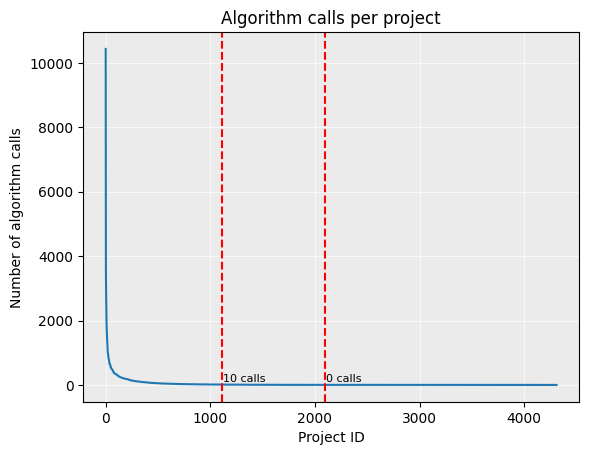

In [84]:
# number of algos used per project
# unique_values, frequencies = np.unique(nr_of_algos, return_counts=True)
nr_of_algos_per_project = sorted(nr_of_algos, reverse=True)
first_0 = nr_of_algos_per_project.index(0)
first_10 = nr_of_algos_per_project.index(10)

# Step 4: Plot the frequencies
fig, ax = plt.subplots(1, 1)
fig.patch.set_facecolor('xkcd:white')

plt.grid(color='w', linestyle='-', linewidth=0.5)
ax.set_facecolor((0.92, 0.92, 0.92))

plt.plot(nr_of_algos_per_project)
plt.axvline(x = first_0, color='r', linestyle='--')
plt.text(first_0 + 10, 100, '0 calls', color='black', fontsize=8, ha='left')

plt.axvline(x = first_10, color='r', linestyle='--')
plt.text(first_10 + 10, 100, '10 calls', color='black', fontsize=8, ha='left')

# plt.bar(nr_of_algos_per_project, align='center', alpha=0.5)
plt.xlabel('Project ID')
plt.ylabel('Number of algorithm calls')
plt.title('Algorithm calls per project')
# plt.xticks([])
# plt.grid(True)
# plt.savefig(f'{DATA_ANALYSIS_FOLDER}/plots/algo_calls.png', dpi=500, bbox_inches='tight')
plt.savefig(f'{DATA_ANALYSIS_FOLDER}/plots/algo_calls.pdf', dpi=500, bbox_inches='tight')
plt.show()


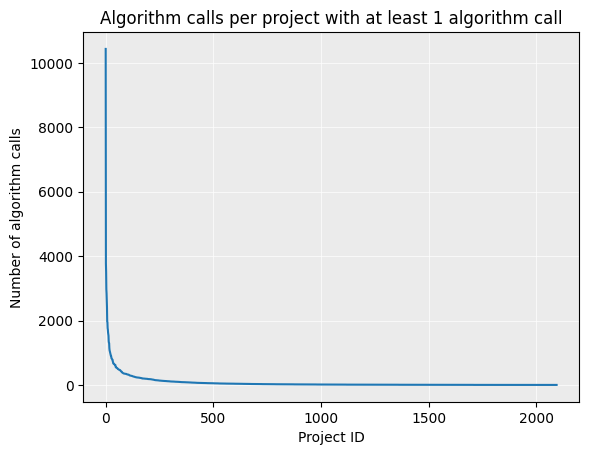

In [85]:
# number of algos used per project
# unique_values, frequencies = np.unique(nr_of_algos, return_counts=True)
nr_of_algos_per_project = sorted(nr_of_algos, reverse=True)
nr_of_algos_per_project = [x for x in nr_of_algos_per_project if x > 0]

# Step 4: Plot the frequencies
fig, ax = plt.subplots(1, 1)
fig.patch.set_facecolor('xkcd:white')

plt.grid(color='w', linestyle='-', linewidth=0.5)
ax.set_facecolor((0.92, 0.92, 0.92))

plt.plot(nr_of_algos_per_project)

# plt.bar(nr_of_algos_per_project, align='center', alpha=0.5)
plt.xlabel('Project ID')
plt.ylabel('Number of algorithm calls')
plt.title('Algorithm calls per project with at least 1 algorithm call')
# plt.xticks([])
# plt.grid(True)
plt.savefig(f'{DATA_ANALYSIS_FOLDER}/plots/algo_calls_at_least_1.pdf', dpi=500, bbox_inches='tight')
plt.show()


In [86]:
print({k : v for k, v in nr_of_algo_uses.items() if v > 10})
print(sorted(nr_of_algo_uses.items(), key=lambda x: x[1], reverse=True))

{'std::for_each': 3019, 'std::all_of': 706, 'std::any_of': 1138, 'std::none_of': 163, 'std::find': 8165, 'std::find_if': 4665, 'std::find_if_not': 108, 'std::find_end': 16, 'std::find_first_of': 37, 'std::adjacent_find': 86, 'std::count': 548, 'std::count_if': 380, 'std::mismatch': 56, 'std::equal': 820, 'std::search': 96, 'std::copy': 7887, 'std::copy_if': 257, 'std::copy_n': 3206, 'std::copy_backward': 381, 'std::move': 624, 'std::move_backward': 134, 'std::swap': 16445, 'std::swap_ranges': 40, 'std::iter_swap': 325, 'std::transform': 5893, 'std::replace': 486, 'std::replace_if': 55, 'std::fill': 3138, 'std::fill_n': 9134, 'std::generate': 162, 'std::generate_n': 53, 'std::remove': 704, 'std::remove_if': 1143, 'std::remove_copy_if': 56, 'std::unique': 763, 'std::unique_copy': 16, 'std::reverse': 1738, 'std::reverse_copy': 91, 'std::rotate': 82, 'std::random_shuffle': 148, 'std::shuffle': 215, 'std::partition': 204, 'std::stable_partition': 62, 'std::partition_point': 26, 'std::sort':

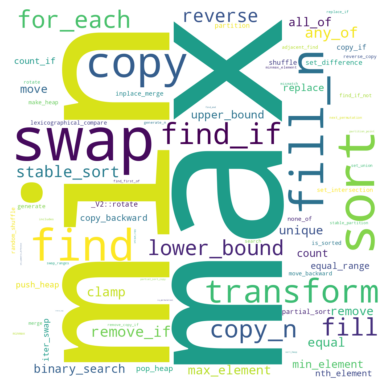

In [87]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


def generate_algo_calls_wordcloud():
    # Create a wordcloud object
    wordcloud = WordCloud(width = 1200, height = 1200, background_color='white')
    # wordcloud = WordCloud(width = 1200, height = 1200)

    # Generate the wordcloud from a text
    # text = "Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua."
    nr_of_algo_uses_without_std = {k.replace('std::', '') : v for k, v in nr_of_algo_uses.items()}
    wordcloud.generate_from_frequencies(nr_of_algo_uses_without_std)

    # Display the wordcloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

    wordcloud.to_file(f'{DATA_ANALYSIS_FOLDER}/wordcloud.png')

generate_algo_calls_wordcloud()


In [88]:
# Get SLOC for each project
file_list = [
    "debian-all-cpp-projects.json",
]

sloc_info = {}

for file_name in file_list:
    with open(f"{DATA_ANALYSIS_FOLDER}/../examples/{file_name}", "r") as fin:
        data = json.load(fin)["debian"]
        for project in data:
            cpp_lines = [x[1] for x in data[project]["codebase_data"]["sloc"] if x[0] == "cpp"]
            sloc_info[project] = cpp_lines[0]

# print(json.dumps(sloc_info, indent=4))

Total number of projects: 4311
4311


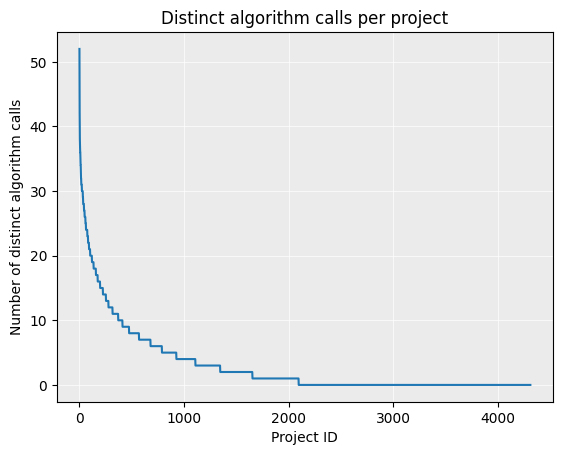

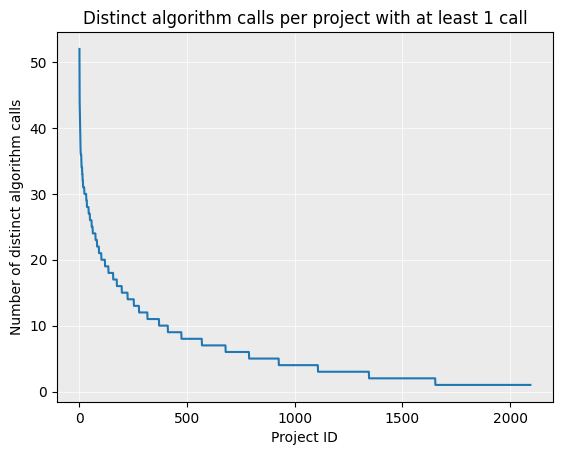

In [209]:
def plot_algo_calls_by_distinct_algos():
    # number of algos used per project
    # unique_values, frequencies = np.unique(nr_of_algos, return_counts=True)
    pname_and_nr_of_algos = []

    for project_name in project_names:
        project = stats[project_name]
        if project['overall_features'] is None:
            # print(f"{project_name} has empty overall_features")
            pname_and_nr_of_algos.append((project_name, 0))
            continue

        if 'algorithm type prevalence' not in project['overall_features']:
            # print(f"{project_name} has no algorithm type prevalence")
            pname_and_nr_of_algos.append((project_name, 0))
            continue
        # print(f'project name: {project_name}')
        if project['overall_features']['algorithm type prevalence'] is None:
            # print(f"{project_name} has empty algorithm type prevalence")
            pname_and_nr_of_algos.append((project_name, 0))
            continue
        pname_and_nr_of_algos.append((project_name, sum([min(1, v) for (_, v) in project['overall_features']['algorithm type prevalence'].items()])))
        # for algo_name, algo_uses in project['overall_features']['algorithm type prevalence'].items():
        #     nr_of_algo_uses[algo_name] += algo_uses

    # project_and_algo_uses = [(k, v) for k, v in pname_and_nr_of_algos.items()]
    project_and_algo_uses = sorted(pname_and_nr_of_algos, reverse=True, key = lambda x: x[1])
    # sloc_per_project = [sloc_info[project] for (project, _) in project_and_algo_uses]

    nr_of_algos_per_project = [project_and_algo_uses[i][1] for i in range(len(project_and_algo_uses))]
    nr_of_algos_per_project = sorted(nr_of_algos_per_project, reverse=True)

    print(f"Total number of projects: {len(nr_of_algos_per_project)}")
    print(len(project_names))

    # first_0 = nr_of_algos_per_project.index(0)
    # first_10 = nr_of_algos_per_project.index(10)

    # Step 4: Plot the frequencies
    fig, ax = plt.subplots(1, 1)
    fig.patch.set_facecolor('xkcd:white')

    plt.grid(color='w', linestyle='-', linewidth=0.5)
    ax.set_facecolor((0.92, 0.92, 0.92))

    plt.plot(nr_of_algos_per_project)
    # plt.axvline(x = first_0, color='r', linestyle='--')
    # plt.text(first_0 + 10, 100, '0 calls', color='black', fontsize=8, ha='left')

    # plt.axvline(x = first_10, color='r', linestyle='--')
    # plt.text(first_10 + 10, 100, '10 calls', color='black', fontsize=8, ha='left')

    # plt.bar(nr_of_algos_per_project, align='center', alpha=0.5)
    plt.xlabel('Project ID')
    plt.ylabel('Number of distinct algorithm calls')
    plt.title('Distinct algorithm calls per project')
    # plt.xticks([])
    # plt.grid(True)
    plt.savefig(f'{DATA_ANALYSIS_FOLDER}/plots/algo_calls_distinct.pdf', dpi=500, bbox_inches='tight')
    plt.show()

    fig, ax = plt.subplots(1, 1)
    fig.patch.set_facecolor('xkcd:white')

    plt.grid(color='w', linestyle='-', linewidth=0.5)
    ax.set_facecolor((0.92, 0.92, 0.92))

    nr_of_algos_per_project = [x for x in nr_of_algos_per_project if x > 0]
    plt.plot(nr_of_algos_per_project)
    # plt.axvline(x = first_0, color='r', linestyle='--')
    # plt.text(first_0 + 10, 100, '0 calls', color='black', fontsize=8, ha='left')

    # plt.axvline(x = first_10, color='r', linestyle='--')
    # plt.text(first_10 + 10, 100, '10 calls', color='black', fontsize=8, ha='left')

    # plt.bar(nr_of_algos_per_project, align='center', alpha=0.5)
    plt.xlabel('Project ID')
    plt.ylabel('Number of distinct algorithm calls')
    plt.title('Distinct algorithm calls per project with at least 1 call')
    # plt.xticks([])
    # plt.grid(True)
    plt.savefig(f'{DATA_ANALYSIS_FOLDER}/plots/algo_calls_distinct_at_least_1.pdf', dpi=500, bbox_inches='tight')
    plt.show()

plot_algo_calls_by_distinct_algos()


In [90]:
with open(f"{DATA_ANALYSIS_FOLDER}/data/algo_uses/nr_for_each_algo.txt", "w") as fout:
    for k, v in sorted(list(nr_of_algo_uses.items()), key=lambda x: x[1], reverse=True):
        fout.write(f"{k} {v}\n")

In [91]:
with open(f"{DATA_ANALYSIS_FOLDER}/data/algo_uses/nr_for_each_proj.txt", "w") as fout:
    lines = []
    for k, v in sorted(list(zip(project_names, nr_of_algos)), key=lambda x: x[1], reverse=True):
        if k in sloc_info:
            lines.append((k, v, sloc_info[k], v / sloc_info[k]))
        # fout.write(f"{k} {v} {sloc_info[k]} {v / sloc_info[k]}\n")
        else:
            lines.append((k, v, 0, 0))
            # fout.write(f"{k} {v}\n")
    
    print(lines[:10])
    for line in sorted(lines, key = lambda x: x[1], reverse=True):
        fout.write(f"{line[0]} {line[1]} {line[2]} {line[3]}\n")
        # fout.write(f"{line[0]} {line[1]}\n")

[('bagel', 10437, 1236565, 0.008440316521978223), ('opencv', 3768, 1079020, 0.0034920576078293266), ('quantlib', 3509, 389443, 0.009010304460473035), ('octave', 2973, 332823, 0.008932675926843998), ('rawtherapee', 2846, 255108, 0.011156059394452546), ('praat', 2649, 858076, 0.0030871391345288763), ('crawl', 2398, 326715, 0.007339730346020232), ('gdal', 1966, 1136033, 0.0017305835305840588), ('libmaus2', 1953, 300951, 0.006489428511618171), ('seqan2', 1764, 256886, 0.006866859229385798)]


In [92]:
with open(f"{DATA_ANALYSIS_FOLDER}/data/algo_uses/nr_for_each_proj_distinct.txt", "w") as fout:
    lines = []
    for k, v in project_to_distinct_algo_calls.items():
        if k in sloc_info:
            lines.append((k, v, sloc_info[k], v / sloc_info[k]))
        else:
            lines.append((k, v, 0, 0))
    
    lines = sorted(lines, key = lambda x: x[1], reverse=True)
    print(lines[:10])
    for line in lines:
        fout.write(f"{line[0]} {line[1]} {line[2]} {line[3]}\n")
        # fout.write(f"{line[0]} {line[1]}\n")

[('wesnoth-1.16', 52, 240905, 0.0002158527220273552), ('qt6-base', 44, 1766049, 2.4914371005561002e-05), ('dolphin-emu', 42, 528500, 7.947019867549669e-05), ('libtorrent-rasterbar', 39, 178209, 0.00021884416611955626), ('nlohmann-json3', 38, 101475, 0.00037447647203744765), ('kicad', 37, 633548, 5.840125767897618e-05), ('opencv', 36, 1079020, 3.3363607718114586e-05), ('cmake', 36, 250806, 0.00014353723595129304), ('inkscape', 36, 532425, 6.761515706437527e-05), ('warzone2100', 35, 529389, 6.61139540111336e-05)]


In [93]:
def list_algo_uses_for_projects(projects):
    for project_name in projects:
        with open(f"{DATA_ANALYSIS_FOLDER}/data/algo_uses_per_project/{project_name}.txt", "w") as fout:
            algo_calls = [(k, v) for k, v in stats[project_name]['overall_features']['algorithm type prevalence'].items() if v > 0]
            algo_calls = sorted(algo_calls, key=lambda x: x[1], reverse=True)

            fout.write(f"Distinct algo calls (> 0) in project: {len(algo_calls)}\n")
            fout.write("algo_name,total_algo_calls\n")
            for algo_name, algo_uses in algo_calls:
                fout.write(f"{algo_name.replace('std::','')},{algo_uses}\n")
            

list_algo_uses_for_projects(["bagel", "opencv", "quantlib", "octave", "rawtherapee"])

In [94]:
# with open("nr_for_each_algo_no_praat.txt", "w") as fout:
#     this_data = {k: v for k, v in nr_of_algo_uses.items()}
#     # for k, v in stats["praat"]["overall_features"]["algorithm type prevalence"].items():
#     #     this_data[k] -= v
#     for k, v in sorted(list(this_data.items()), key=lambda x: x[1], reverse=True):
#         fout.write(f"{k} {v}\n")

In [95]:
# Total number of projects
print(f"Total number of projects: {len(project_names)}")

# How many have less than X algos
X = 0
print(f"Projects with less than {X} algo usages: {len([x for x in nr_of_algos if x <= X])}")

Total number of projects: 4311
Projects with less than 0 algo usages: 2216


In [241]:
def plot_by_kind(algo_kind, algo_names):
    print(f"Plotting uses for {algo_kind}")
    values = [(name, nr_of_algo_uses[name]) for name in algo_names]
    values = sorted(values, key=lambda x: x[1], reverse=True)

    print("initial values:")
    print(values)

    print(f"Nr of algos that are not used for {algo_kind}: {len([x for x in values if x[1] == 0])}")
    
    zero_values = [x for x in values if x[1] == 0]
    if len(values) > 15:
        values = [x for x in values if x[1] > 0]
    # values.append( ('\n'.join([x[0] for x in zero_values]), 0) )

    values = [(x[0].replace('std::', ''), x[1]) for x in values]

    x_axis = [x[0] for x in values]
    y_axis = [x[1] for x in values]
    # Plot the usage
    # plt.figure(figsize=(7, 9))
    fig, ax = plt.subplots(1, 1)
    fig.patch.set_facecolor('xkcd:white')
    plt.grid(color='w', linestyle='-', linewidth=0.5, zorder=0)
    ax.grid(zorder=0)
    ax.set_facecolor((0.92, 0.92, 0.92))

    plt.bar(x_axis, y_axis, align='center', alpha=0.5, zorder=3)
    plt.xlabel('Algorithm name')
    plt.ylabel('Number of algorithm calls')
    plt.title(f'Frequency of \"{algo_kind}\" STL algorithms')
    plt.xticks(x_axis, rotation=90 if len(x_axis) > 6 else 0)
    # plt.grid(True)

    max_value = max([value[1] for value in values])
    for i, value in enumerate(values):
        plt.text(i, value[1] + 0.008 * max_value, str(value[1]), ha='center')
    
    # plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/{algo_kind.replace('/', ' or ')}.pdf", dpi=500, bbox_inches='tight')
    # plt.close(fig)
    plt.show()

Plotting uses for Batch operations
initial values:
[('std::for_each', 3019), ('std::for_each_n', 0)]
Nr of algos that are not used for Batch operations: 1


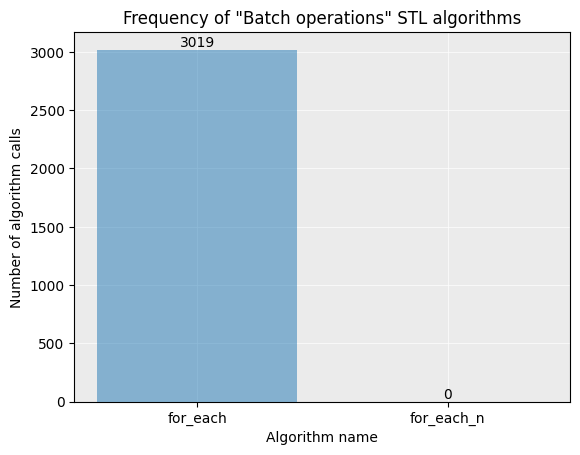

Plotting uses for Search operations
initial values:
[('std::find', 8165), ('std::find_if', 4665), ('std::any_of', 1138), ('std::equal', 820), ('std::all_of', 706), ('std::count', 548), ('std::count_if', 380), ('std::none_of', 163), ('std::find_if_not', 108), ('std::search', 96), ('std::adjacent_find', 86), ('std::mismatch', 56), ('std::find_first_of', 37), ('std::find_end', 16), ('std::search_n', 0)]
Nr of algos that are not used for Search operations: 1


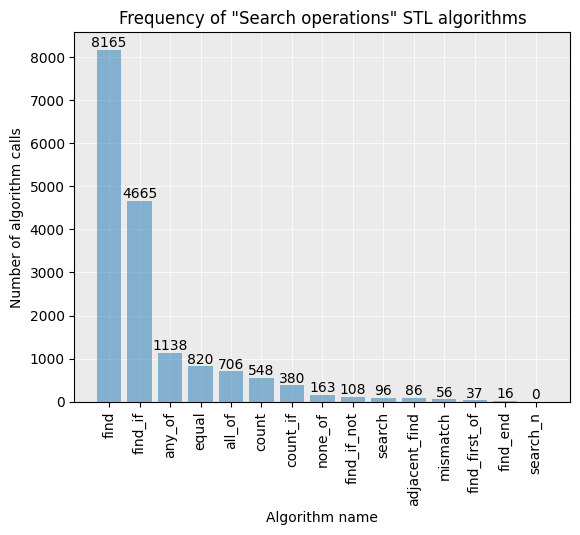

Plotting uses for Modifying sequence operations
initial values:
[('std::swap', 16445), ('std::fill_n', 9134), ('std::copy', 7887), ('std::transform', 5893), ('std::copy_n', 3206), ('std::fill', 3138), ('std::reverse', 1738), ('std::remove_if', 1143), ('std::unique', 763), ('std::remove', 704), ('std::move', 624), ('std::replace', 486), ('std::copy_backward', 381), ('std::iter_swap', 325), ('std::copy_if', 257), ('std::shuffle', 215), ('std::generate', 162), ('std::random_shuffle', 148), ('std::move_backward', 134), ('std::reverse_copy', 91), ('std::rotate', 82), ('std::remove_copy_if', 56), ('std::replace_if', 55), ('std::generate_n', 53), ('std::swap_ranges', 40), ('std::unique_copy', 16), ('std::remove_copy', 5), ('std::replace_copy_if', 3), ('std::sample', 3), ('std::replace_copy', 2), ('std::rotate_copy', 1), ('std::shift_left', 0), ('std::shift_right', 0)]
Nr of algos that are not used for Modifying sequence operations: 2


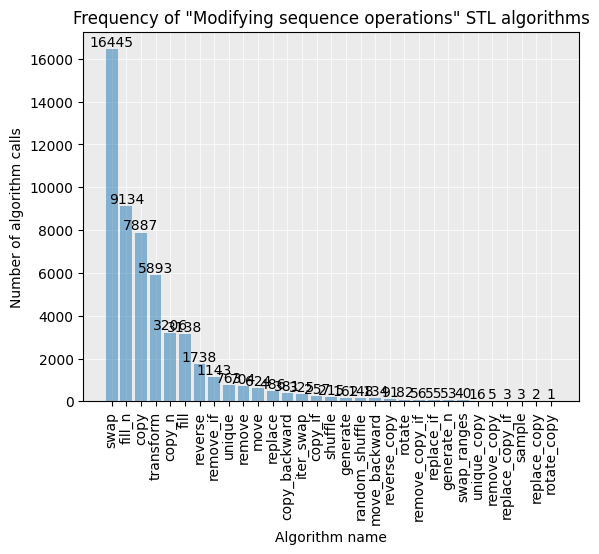

Plotting uses for Sorting and relation operations
initial values:
[('std::sort', 12061), ('std::lower_bound', 2274), ('std::stable_sort', 1275), ('std::binary_search', 650), ('std::upper_bound', 597), ('std::equal_range', 403), ('std::nth_element', 376), ('std::push_heap', 320), ('std::pop_heap', 303), ('std::set_difference', 221), ('std::partial_sort', 214), ('std::partition', 204), ('std::inplace_merge', 180), ('std::set_intersection', 166), ('std::make_heap', 143), ('std::is_sorted', 137), ('std::merge', 81), ('std::set_union', 64), ('std::stable_partition', 62), ('std::includes', 30), ('std::partition_point', 26), ('std::partial_sort_copy', 21), ('std::sort_heap', 18), ('std::set_symmetric_difference', 8), ('std::partition_copy', 2), ('std::is_heap', 1), ('std::is_partitioned', 0), ('std::is_sorted_until', 0), ('std::is_heap_until', 0)]
Nr of algos that are not used for Sorting and relation operations: 3


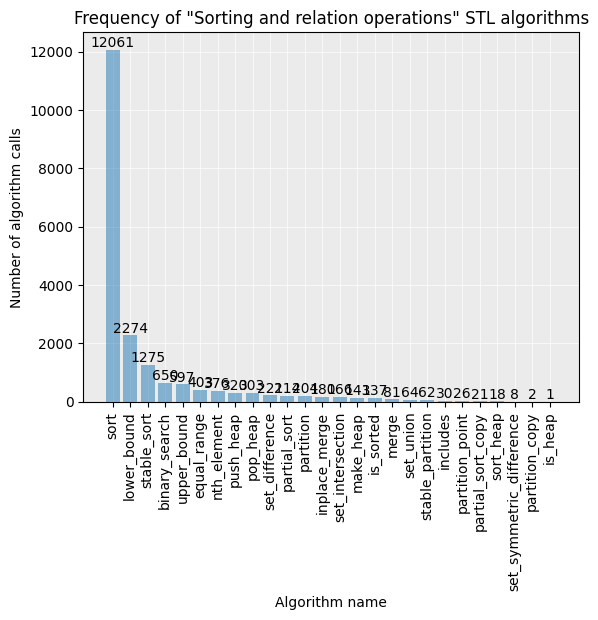

Plotting uses for Minimum/maximum operations
initial values:
[('std::max', 34642), ('std::min', 32771), ('std::clamp', 876), ('std::max_element', 840), ('std::min_element', 571), ('std::minmax_element', 56), ('std::minmax', 43)]
Nr of algos that are not used for Minimum/maximum operations: 0


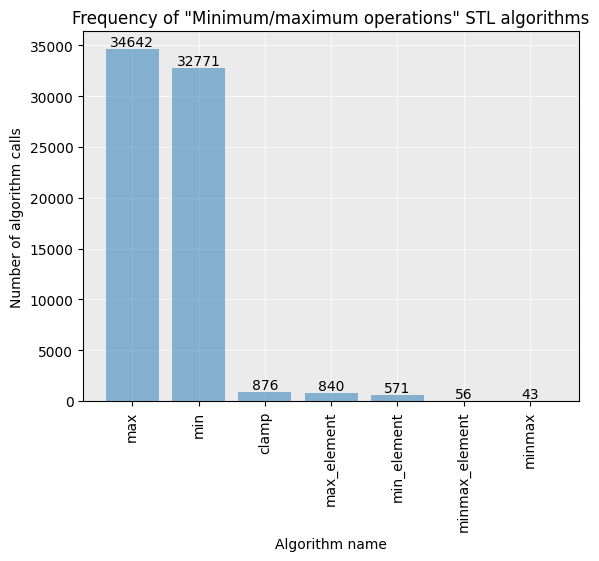

Plotting uses for Lexicographical comparison operations
initial values:
[('std::lexicographical_compare', 153), ('std::lexicographical_compare_three_way', 0)]
Nr of algos that are not used for Lexicographical comparison operations: 1


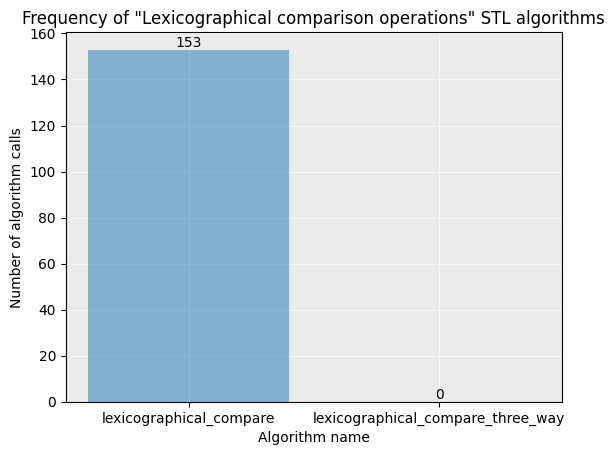

Plotting uses for Permutation operations
initial values:
[('std::next_permutation', 44), ('std::is_permutation', 12), ('std::prev_permutation', 2)]
Nr of algos that are not used for Permutation operations: 0


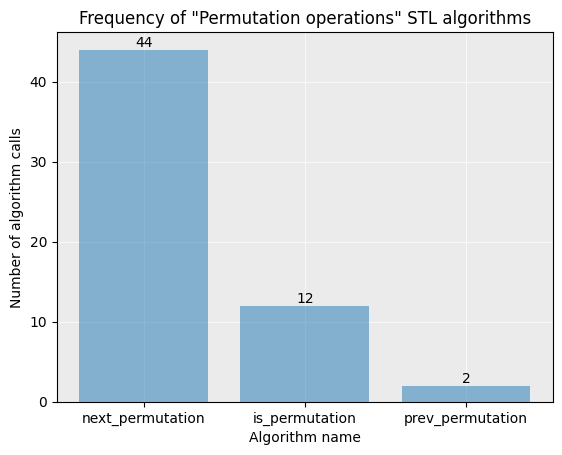

In [242]:
algo_names_by_kind = load_algo_names_by_kind()
for algo_kind, algo_names in algo_names_by_kind.items():
    plot_by_kind(algo_kind, algo_names)

In [98]:
def split_by_char(input, split_char):
    # Need to split while making sure that we are at the same level of < brackets
    assert len(split_char) == 1, "split_char must be a single character"
    level = 0
    current = ""
    result = []
    for c in input:
        if c == "<":
            level += 1
        elif c == ">":
            level -= 1
        if c == split_char and level == 0:
            result.append(current)
            current = ""
        else:
            current += c
    result.append(current)
    result = [x.strip() for x in result]
    return result

def parse_basic_string(type_str):
    # looks like std::basic_string<char, std::char_traits<char>, std::allocator<char> >
    # so basically std::basic_stirng<type, traits, allocator>

    if type_str == "std::basic_string<char, std::char_traits<char>, std::allocator<char> >":
        return "string"
    if type_str == "std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> >":
        return "wstring"
    if type_str == "std::basic_string<char8_t, std::char_traits<char8_t>, std::allocator<char8_t> >":
        return "u8string"
    if type_str == "std::basic_string<char16_t, std::char_traits<char16_t>, std::allocator<char16_t> >":
        return "u16string"
    if type_str == "std::basic_string<char32_t, std::char_traits<char32_t>, std::allocator<char32_t> >":
        return "u32string"
    return f"unknown basic_string <{type_str}>"

def parse_normal_iterator(type_str):
    # looks like normal_iterator<type *, container<type>>
    # or normal_iterator<type *, container<type, allocator<type>>>
    
    # trim the beginning and end >
    type_str = type_str[len("__gnu_cxx::__normal_iterator<"):-1]
    # split by ',' and strip whitespace at end
    parts = split_by_char(type_str, ',')

    # first parameter is a pointer to the type
    container_type = parts[1]

    return f"Iterator on {parse_type(container_type)}"

def parse_back_insert_iterator(type_str):
    # looks like std::back_insert_iterator<>
    # trim the beginning and end >
    type_str = type_str[len("std::back_insert_iterator<"):-1]
    parts = split_by_char(type_str, ',')
    return f"back_insert_iterator<{parse_type(parts[0])}>"

def parse_vector_type(type_str):
    # looks like std::vector <T, std::allocator<T>>
    # trim the beginning and end>
    type_str = type_str[len("std::vector<"):-1]
    parts = split_by_char(type_str, ',')

    return f"vector<{parse_type(parts[0])}>" 

def parse_type(type_str):
    if type_str.endswith("&"):
        return f"{parse_type(type_str[:-1].strip())}&"
    if type_str.startswith("__gnu_cxx::__normal_iterator<"):
        return parse_normal_iterator(type_str)
    if type_str.startswith("std::basic_string<"):
        return parse_basic_string(type_str)
    if type_str.startswith("std::vector"):
        return parse_vector_type(type_str)
    if type_str.startswith("std::back_insert_iterator<"):
        return parse_back_insert_iterator(type_str)

    # check if there is a layer of <>
    if type_str.count('<') < 1 or type_str.count('>') < 1:
        return type_str
    
    outer_type_str_l = type_str[:type_str.index('<') + 1]
    outer_type_str_r = type_str[type_str.rindex('>'):]
    inner_type_str = parse_type(type_str[type_str.index('<')+1 : type_str.rindex('>')])

    if outer_type_str_l.startswith("std::"):
        outer_type_str_l = outer_type_str_l[len("std::"):]

    return outer_type_str_l + inner_type_str + outer_type_str_r

long_ass_type = "__gnu_cxx::__normal_iterator<std::basic_string<char, std::char_traits<char>, std::allocator<char> > *, std::vector<std::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::allocator<std::basic_string<char, std::char_traits<char>, std::allocator<char> > > > >"
print(parse_type(long_ass_type))

Iterator on vector<string>


# Looking at the parameter type of the most popular algorithms

In [99]:

def investigate_parameter_instantiation_type(algo_names):
    print(f"Investigating parameter instantiation type for {algo_names}")

    instantiation_types = dict()
    for algo_name in algo_names:
        instantiation_types[algo_name] = defaultdict(int)


    # Go through every *.ast.json in the analyze folder
    # but skip those found in a project that doesn't have overall_stats
    files = glob.glob(f"{FEATURES_FOLDER}/**/*.ast.json", recursive = True)

    for i, file in enumerate(files):
        file_project_name = file.split("/")[6]
        if file_project_name not in stats:
            continue
        # if "telegram" in file:
            # print(f"Skipping the telegram-desktop project: {file}")
            # continue
        # print(f"File: {file}")
        try:
            with open(file, "r") as fin:
                data = json.load(fin)
        except Exception as e:
            print(f"Exception: {e}")
            print(f"Skipping file: {file}")
            continue
        
        if "ala" not in data or data["ala"] is None:
            continue

        global_locations_implicit = set()
        global_locations_explicit = set()

        for algo_name in algo_names:
            if data["ala"].get("templated func uses", None) is not None and algo_name in data["ala"]["templated func uses"]:
                for appearence in data["ala"]["templated func uses"][algo_name]:
                    if appearence["GlobalLocation"] in global_locations_implicit:
                        continue
                    # if len(appearence["arguments"]["non-type"]) == 0 or len(appearence["arguments"]["template"]) == 0:
                    #     continue
                    # if len(appearence["arguments"]["type"]) == 1:
                    #     continue
                    # instantiation_types[appearence["arguments"]["type"][0]] += 1
                    # instantiation_types[json.dumps(appearence["arguments"])] += 1
                    types_temp = deepcopy(appearence["arguments"]["type"])
                    types_temp = [parse_type(x) for x in types_temp]
                    instantiation_types[algo_name][json.dumps(types_temp)] += 1
                    global_locations_implicit.add(appearence["GlobalLocation"])
                    assert "../" not in appearence["GlobalLocation"], f"implicit GlobalLocation: {appearence['GlobalLocation']}, project = {file_project_name}"
            
            if data["ala"].get("explicit func insts", None) is not None and algo_name in data["ala"]["explicit func insts"]:
                for appearence in data["ala"]["explicit func insts"][algo_name]:
                    if appearence["GlobalLocation"] in global_locations_explicit:
                        continue
                    # if len(appearence["arguments"]["non-type"]) == 0 or len(appearence["arguments"]["template"]) == 0:
                    #     continue
                    # if len(appearence["arguments"]["type"]) == 1:
                    #     continue
                    # instantiation_types[appearence["arguments"]["type"][0]] += 1
                    # instantiation_types[json.dumps(appearence["arguments"])] += 1
                    types_temp = deepcopy(appearence["arguments"]["type"])
                    types_temp = [parse_type(x) for x in types_temp]
                    instantiation_types[algo_name][json.dumps(types_temp)] += 1
                    global_locations_explicit.add(appearence["GlobalLocation"])
                    assert "../" not in appearence["GlobalLocation"], f"explicit GlobalLocation: {appearence['GlobalLocation']}, project = {file_project_name}"
    
    for algo_name in algo_names:
        data = list(instantiation_types[algo_name].items())
        data = sorted(data, key = lambda x: x[1], reverse=True)
        # print(f"Number of different instantiation types: {len(instantiation_types)}")
        # for k,v in instantiation_types:
        #     print(f"{k} ::: {v}")
        
        with open(f"{DATA_ANALYSIS_FOLDER}/data/algo_parameter_type/{algo_name}.txt", "w") as fout:
            fout.write(f"Number of different instantiation types: {len(data)}\n")
            fout.write(f"Total number of apparitions: {sum([x[1] for x in data])}\n")
            for k, v in data:
                fout.write(f"{v}  {k}\n")


In [100]:
# investigate_parameter_instantiation_type(["std::move", "std::max", "std::min", "std::fill_n", "std::swap", "std::sort", "std::find", "std::copy", "std::find_if", "std::copy_n"])
# investigate_parameter_instantiation_type(["std::max"])

# investigate_parameter_instantiation_type("std::max")
# investigate_parameter_instantiation_type("std::min")
# investigate_parameter_instantiation_type("std::fill_n")
# investigate_parameter_instantiation_type("std::sort")
# investigate_parameter_instantiation_type("std::find")
# investigate_parameter_instantiation_type("std::copy")
# investigate_parameter_instantiation_type("std::find_if") # really diverse uses
# investigate_parameter_instantiation_type("std::transform") # really diverse uses
# investigate_parameter_instantiation_type("std::for_each")

# For each algorithm, plot how many distinct projects it appears in, grouped by kind

In [244]:
def plot_distinct_projects_by_kind(algo_kind, algo_names):
    print(f"Plotting uses for {algo_kind}")

    values = []
    for algo_name in algo_names:
        projects = [pname for pname, p in stats.items() if p.get("overall_features", None) is not None and p['overall_features'].get('algorithm type prevalence', None) is not None and p['overall_features']['algorithm type prevalence'].get(algo_name, 0) > 0]
        values.append((algo_name, len(projects)))


    # values = [(name, nr_of_algo_uses[name]) for name in algo_names]
    values = sorted(values, key=lambda x: x[1], reverse=True)

    print(f"Nr of algos that are not used for {algo_kind}: {len([x for x in values if x[1] == 0])}")
    
    zero_values = [x for x in values if x[1] == 0]
    if len(values) > 15:
        values = [x for x in values if x[1] > 0]
    # values.append( ('\n'.join([x[0] for x in zero_values]), 0) )

    values = [(x[0].replace('std::', ''), x[1]) for x in values]
    print("values before plot")
    print(values)

    x_axis = [x[0] for x in values]
    y_axis = [x[1] for x in values]
    fig, ax = plt.subplots(1, 1)
    fig.patch.set_facecolor('xkcd:white')

    plt.grid(color='w', linestyle='-', linewidth=0.5, zorder=0)
    ax.set_facecolor((0.92, 0.92, 0.92))

    # Plot the usage
    # plt.figure(figsize=(7, 9))
    plt.bar(x_axis, y_axis, align='center', alpha=0.5, zorder=3)
    plt.xlabel('Algorithm name')
    plt.ylabel('Number of distinct projects it appears in')
    plt.title(f'Frequency of \"{algo_kind}\" STL algorithms')
    plt.xticks(x_axis, rotation=90 if len(x_axis) > 6 else 0)
    # plt.grid(True)

    max_value = max([value[1] for value in values])
    for i, value in enumerate(values):
        plt.text(i, value[1] + 0.008 * max_value, str(value[1]), ha='center')
    
    # plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/{algo_kind.replace('/', ' or ')} in distinct projects.pdf", dpi=500, bbox_inches='tight')
    # plt.close(fig)
    plt.show()



Plotting uses for Batch operations
Nr of algos that are not used for Batch operations: 1
values before plot
[('for_each', 308), ('for_each_n', 0)]


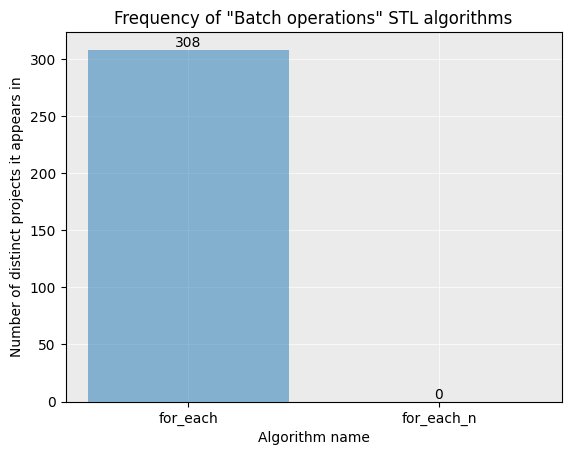

Plotting uses for Search operations
Nr of algos that are not used for Search operations: 1
values before plot
[('find', 808), ('find_if', 579), ('any_of', 215), ('equal', 205), ('count', 177), ('all_of', 147), ('count_if', 136), ('none_of', 63), ('search', 49), ('find_if_not', 46), ('adjacent_find', 38), ('mismatch', 37), ('find_first_of', 27), ('find_end', 14), ('search_n', 0)]


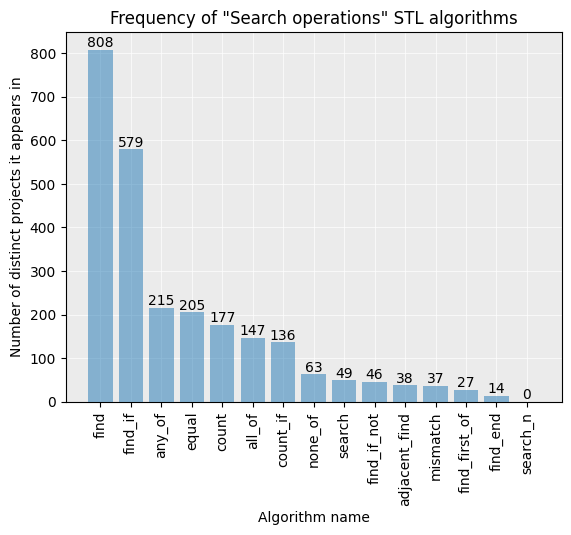

Plotting uses for Modifying sequence operations
Nr of algos that are not used for Modifying sequence operations: 2
values before plot
[('swap', 757), ('copy', 658), ('transform', 567), ('fill', 374), ('reverse', 370), ('remove_if', 294), ('unique', 236), ('remove', 230), ('replace', 178), ('fill_n', 153), ('copy_if', 92), ('move', 92), ('copy_n', 83), ('shuffle', 74), ('random_shuffle', 51), ('generate', 40), ('copy_backward', 35), ('iter_swap', 32), ('replace_if', 30), ('rotate', 30), ('generate_n', 21), ('reverse_copy', 20), ('remove_copy_if', 18), ('move_backward', 17), ('swap_ranges', 13), ('unique_copy', 9), ('remove_copy', 4), ('replace_copy', 2), ('replace_copy_if', 2), ('sample', 2), ('rotate_copy', 1)]


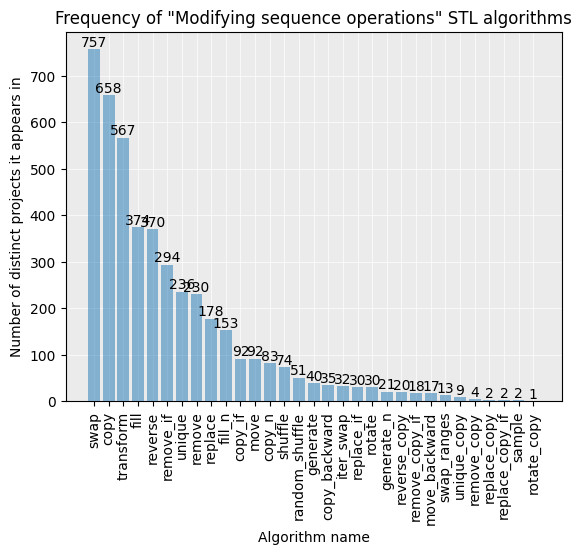

Plotting uses for Sorting and relation operations
Nr of algos that are not used for Sorting and relation operations: 3
values before plot
[('sort', 1114), ('lower_bound', 332), ('stable_sort', 256), ('upper_bound', 170), ('binary_search', 97), ('set_intersection', 85), ('set_difference', 85), ('nth_element', 78), ('pop_heap', 57), ('push_heap', 55), ('is_sorted', 47), ('make_heap', 46), ('partition', 41), ('equal_range', 40), ('partial_sort', 35), ('set_union', 35), ('stable_partition', 28), ('merge', 23), ('inplace_merge', 22), ('includes', 18), ('partial_sort_copy', 12), ('sort_heap', 11), ('set_symmetric_difference', 7), ('partition_point', 5), ('partition_copy', 2), ('is_heap', 1)]


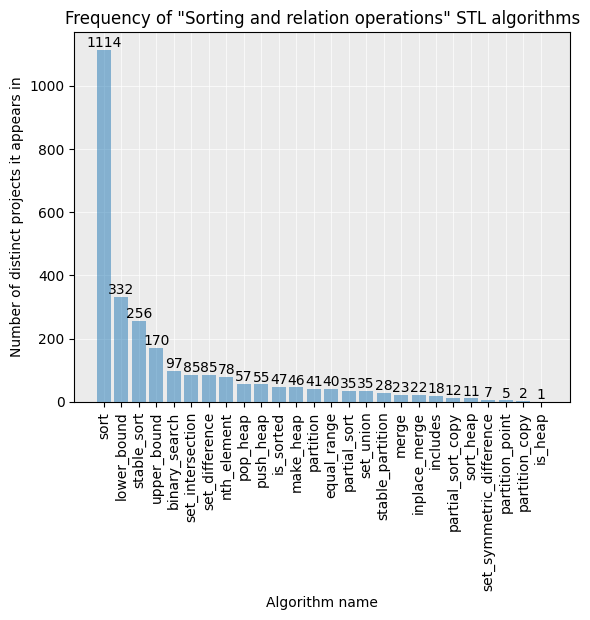

Plotting uses for Minimum/maximum operations
Nr of algos that are not used for Minimum/maximum operations: 0
values before plot
[('min', 1209), ('max', 1152), ('max_element', 231), ('min_element', 169), ('clamp', 47), ('minmax_element', 20), ('minmax', 12)]


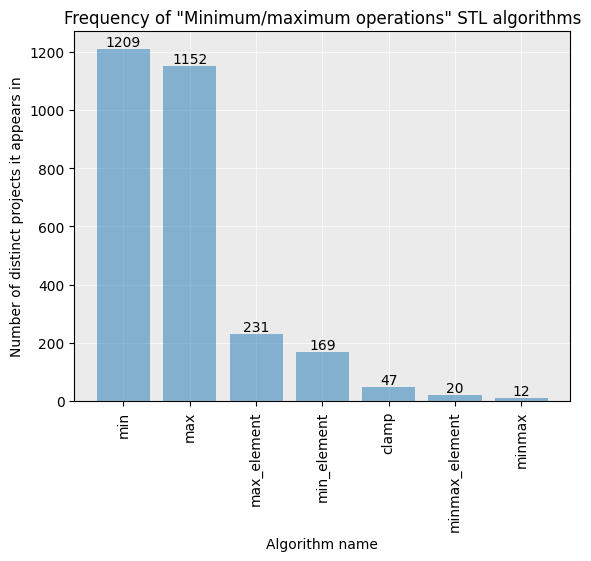

Plotting uses for Lexicographical comparison operations
Nr of algos that are not used for Lexicographical comparison operations: 1
values before plot
[('lexicographical_compare', 66), ('lexicographical_compare_three_way', 0)]


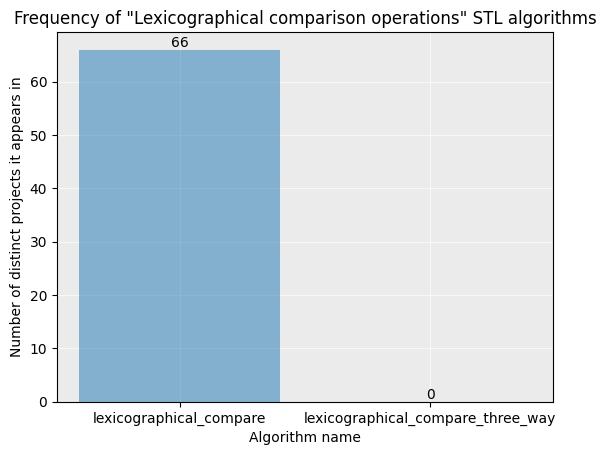

Plotting uses for Permutation operations
Nr of algos that are not used for Permutation operations: 0
values before plot
[('next_permutation', 20), ('is_permutation', 4), ('prev_permutation', 2)]


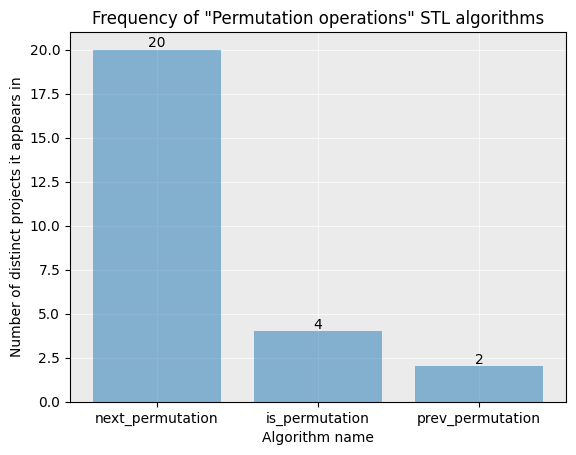

In [245]:
algo_names_by_kind = load_algo_names_by_kind()
for algo_kind, algo_names in algo_names_by_kind.items():
    plot_distinct_projects_by_kind(algo_kind, algo_names)

In [103]:
def box_plot_algo_usage(algo_name):
    # For each algorithm, count the number of times it appears in each project
    # Ignore the 0s
    # Box plot of when it is used, HOW MUCH is it actually used?

    print(f"Box plot for {algo_name}")

    values = []
    for pname, p in stats.items():
        if p.get("overall_features", None) is None:
            continue
        if p['overall_features'].get('algorithm type prevalence', None) is None:
            continue
        if p['overall_features']['algorithm type prevalence'].get(algo_name, None) is None:
            continue
        if p['overall_features']['algorithm type prevalence'][algo_name] == 0:
            continue
        values.append(p['overall_features']['algorithm type prevalence'][algo_name])
        
    fig, ax = plt.subplots(1, 1)
    fig.patch.set_facecolor('xkcd:white')

    plt.grid(color='w', linestyle='-', linewidth=0.5, zorder=0)
    ax.set_facecolor((0.92, 0.92, 0.92))

    plt.boxplot(values, patch_artist = True, showfliers = False, zorder=3)

    plt.title(f"Box plot for {algo_name} without outliers")
    plt.grid(True)
    plt.xticks([])
    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/box_plots/{algo_name}_no_outliers.pdf", dpi=500, bbox_inches='tight')
    plt.close(fig)
    # plt.show()

    fig, ax = plt.subplots(1, 1)
    fig.patch.set_facecolor('xkcd:white')

    plt.grid(color='w', linestyle='-', linewidth=0.5, zorder=0)
    ax.set_facecolor((0.92, 0.92, 0.92))

    plt.boxplot(values, patch_artist = True, showfliers = True, zorder=3)

    plt.title(f"Box plot for {algo_name} appearences with outliers")
    # plt.grid(True)
    plt.xticks([])
    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/box_plots/{algo_name}.pdf", dpi=500, bbox_inches='tight')
    plt.close(fig)
    # plt.show()

def box_plot_algo_usage_by_kind(algo_kind):
    pass

In [104]:
# box_plot_algo_usage(["std::max", "std::min", "std::sort"])
box_plot_algo_usage("std::max")
box_plot_algo_usage("std::min")
box_plot_algo_usage("std::swap")
box_plot_algo_usage("std::sort")
box_plot_algo_usage("std::find")
box_plot_algo_usage("std::copy")
box_plot_algo_usage("std::find_if")
box_plot_algo_usage("std::transform")
box_plot_algo_usage("std::for_each")
box_plot_algo_usage("std::move")

Box plot for std::max
Box plot for std::min
Box plot for std::swap
Box plot for std::sort
Box plot for std::find
Box plot for std::copy
Box plot for std::find_if
Box plot for std::transform
Box plot for std::for_each
Box plot for std::move


In [105]:


# projects_with_no_asts = dict()

# # go over all directories in analyze folder
# for project_name in os.listdir("/home/cdragancea/FBACode/analyze"):
#     if not os.path.isdir(join("/home/cdragancea/FBACode/analyze", project_name)):
#         continue

#     files_in_folder = os.listdir(join("/home/cdragancea/FBACode/analyze", project_name))
#     files_in_folder = [file for file in files_in_folder if file.endswith(".ast.json")]

#     if len(files_in_folder) == 0:
#         projects_with_no_asts[project_name] = 1

# print(len(projects_with_no_asts.keys()))

# with open("/home/cdragancea/FBACode/cache_no_asts.json", "w") as fout:
#     fout.write(json.dumps(projects_with_no_asts, indent = 2))

In [106]:
# lol = "null\nnull\n"

# with open("/home/cdragancea/FBACode/analyze/zutty/overall_stats", "r") as fin:
#     content = fin.read()

# print(content)
# print(lol == content)

In [107]:
# # go over all directories in analyze folder
# for project_name in os.listdir("/home/cdragancea/FBACode/analyze"):
#     if project_name not in projects_with_no_asts:
#         continue

#     if not exists(join("/home/cdragancea/FBACode/analyze", project_name, "overall_stats")):
#         projects_with_no_asts.pop(project_name)
#         continue

#     with open(join("/home/cdragancea/FBACode/analyze", project_name, "overall_stats"), "r") as fin:
#         content = fin.read()
    
#     if content != "null\nnull\n":
#         print(f"{project_name} doesn't have null null")


In [108]:

# with open("/home/cdragancea/FBACode/cache_no_asts.json", "w") as fout:
#     fout.write(json.dumps(projects_with_no_asts, indent = 2))

In [109]:
smart_ptr_usage = defaultdict(int)
smart_ptr_usage_distinct = defaultdict(int)
# nr_of_pointers_uses = [0 for pname in project_names]
nr_of_pointers_uses = []
SMART_PTR_NAMES = ["std::shared_ptr", "std::weak_ptr", "std::unique_ptr"]

with open(f"{DATA_ANALYSIS_FOLDER}/data/smart_pointers/smart-pointers-per-project.txt", "w") as fout:
    fout.write("project_name,shared_ptr,weak_ptr,unique_ptr\n")
    smart_ptr_per_project = []
    for project_name in project_names:
        project = stats[project_name]
        if project['overall_features'] is None:
            # print(f"{project_name} has empty overall_features")
            nr_of_pointers_uses.append(0)
            smart_ptr_per_project.append((project_name, 0, 0, 0))
            continue

        if 'utility type prevalence' not in project['overall_features']:
            # print(f"{project_name} has no utility type prevalence")
            nr_of_pointers_uses.append(0)
            smart_ptr_per_project.append((project_name, 0, 0, 0))
            continue
        # print(f'project name: {project_name}')
        if project['overall_features']['utility type prevalence'] is None:
            # print(f"{project_name} has empty utility type prevalence")
            nr_of_pointers_uses.append(0)
            smart_ptr_per_project.append((project_name, 0, 0, 0))
            continue
        nr_of_pointers_uses.append(sum([v for (_, v) in project['overall_features']['utility type prevalence'].items()]))
        for smart_ptr_name, smart_ptr_uses in project['overall_features']['utility type prevalence'].items():
            if smart_ptr_name in SMART_PTR_NAMES:
                smart_ptr_usage[smart_ptr_name] += smart_ptr_uses
        smart_ptr_per_project.append((project_name, project['overall_features']['utility type prevalence'].get("std::shared_ptr", 0), project['overall_features']['utility type prevalence'].get("std::weak_ptr", 0), project['overall_features']['utility type prevalence'].get("std::unique_ptr", 0)))

    smart_ptr_per_project.sort(key=lambda x: x[1] + x[2] + x[3], reverse=True)
    for project_name, shared_ptr, weak_ptr, unique_ptr in smart_ptr_per_project:
        fout.write(f"{project_name},{shared_ptr},{weak_ptr},{unique_ptr}\n")

In [110]:
print(smart_ptr_usage)

defaultdict(<class 'int'>, {'std::unique_ptr': 112324, 'std::shared_ptr': 195769, 'std::weak_ptr': 2306})


Plotting uses for smart pointers


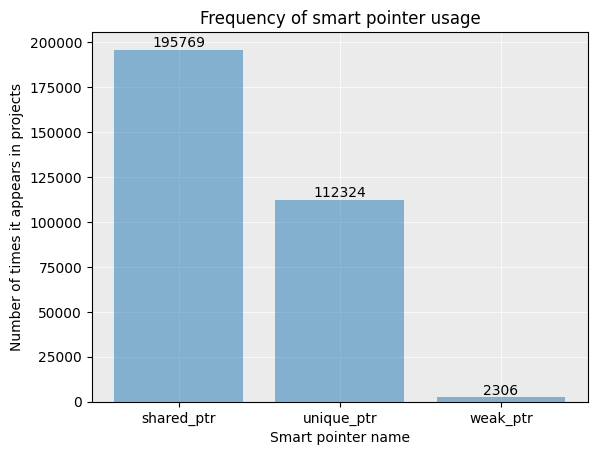

Plotting uses for smart pointers


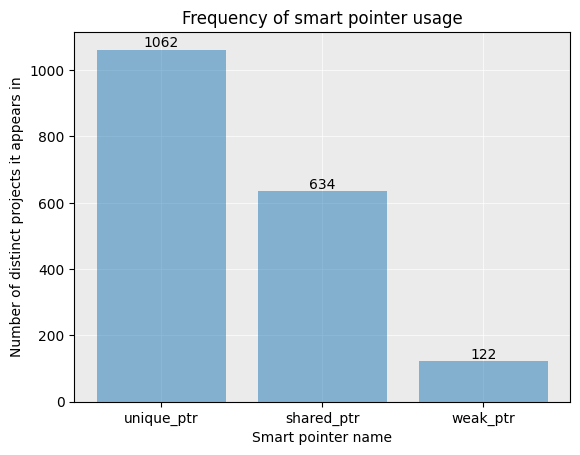

In [251]:
def plot_smart_ptr(smart_ptr_names):
    print(f"Plotting uses for smart pointers")
    
    values = []
    for smart_ptr in smart_ptr_names:
        projects = [p['overall_features']['utility type prevalence'][smart_ptr] for pname, p in stats.items() if p.get("overall_features", None) is not None and \
                    p['overall_features'].get('utility type prevalence', None) is not None and p['overall_features']['utility type prevalence'].get(smart_ptr, 0) > 0]
        values.append((smart_ptr, sum(projects)))


    # values = [(name, nr_of_algo_uses[name]) for name in algo_names]
    values = sorted(values, key=lambda x: x[1], reverse=True)

    values = [(x[0].replace('std::', ''), x[1]) for x in values]

    x_axis = [x[0] for x in values]
    y_axis = [x[1] for x in values]
    # Plot the usage
    # plt.figure(figsize=(7, 9))
    fig, ax = plt.subplots(1, 1)
    fig.patch.set_facecolor('xkcd:white')

    plt.grid(color='w', linestyle='-', linewidth=0.5, zorder=0)
    ax.set_facecolor((0.92, 0.92, 0.92))

    plt.bar(x_axis, y_axis, align='center', alpha=0.5, zorder=3)
    plt.xlabel('Smart pointer name')
    plt.ylabel('Number of times it appears in projects')
    plt.title(f'Frequency of smart pointer usage')
    plt.xticks(x_axis, rotation=90 if len(x_axis) > 6 else 0)
    plt.grid(True)

    max_value = max([x[1] for x in values])
    for i, value in enumerate(values):
        plt.text(i, value[1] + 0.008 * max_value, str(value[1]), ha='center')
    
    # plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/smart pointers in projects.pdf", dpi=500, bbox_inches='tight')
    plt.show()

def plot_smart_ptr_distinct(smart_ptr_names):
    print(f"Plotting uses for smart pointers")
    
    values = []
    for smart_ptr in smart_ptr_names:
        projects = [p['overall_features']['utility type prevalence'][smart_ptr] for pname, p in stats.items() if p.get("overall_features", None) is not None and \
                    p['overall_features'].get('utility type prevalence', None) is not None and p['overall_features']['utility type prevalence'].get(smart_ptr, 0) > 0]
        values.append((smart_ptr, len(projects)))


    # values = [(name, nr_of_algo_uses[name]) for name in algo_names]
    values = sorted(values, key=lambda x: x[1], reverse=True)

    values = [(x[0].replace('std::', ''), x[1]) for x in values]

    x_axis = [x[0] for x in values]
    y_axis = [x[1] for x in values]
    # Plot the usage
    # plt.figure(figsize=(7, 9))
    fig, ax = plt.subplots(1, 1)
    fig.patch.set_facecolor('xkcd:white')

    plt.grid(color='w', linestyle='-', linewidth=0.5, zorder=0)
    ax.set_facecolor((0.92, 0.92, 0.92))
    
    plt.bar(x_axis, y_axis, align='center', alpha=0.5, zorder=3)
    plt.xlabel('Smart pointer name')
    plt.ylabel('Number of distinct projects it appears in')
    plt.title(f'Frequency of smart pointer usage')
    plt.xticks(x_axis, rotation=90 if len(x_axis) > 6 else 0)
    plt.grid(True)

    max_value = max([x[1] for x in values])
    for i, value in enumerate(values):
        plt.text(i, value[1] + 0.008 * max_value, str(value[1]), ha='center')
    
    # plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/smart pointers in distinct projects.pdf", bbox_inches='tight')
    plt.show()

plot_smart_ptr(SMART_PTR_NAMES)
plot_smart_ptr_distinct(SMART_PTR_NAMES)

In [112]:
def box_plot_smart_ptr_usage(smart_ptr_name):
    # For each smart pointer, count the number of times it appears in each project
    # Ignore the 0s
    # Box plot of when it is used, HOW MUCH is it actually used?

    print(f"Box plot for {smart_ptr_name}")

    values = []
    for pname, p in stats.items():
        if p.get("overall_features", None) is None:
            continue
        if p['overall_features'].get('utility type prevalence', None) is None:
            continue
        if p['overall_features']['utility type prevalence'].get(smart_ptr_name, None) is None:
            continue
        if p['overall_features']['utility type prevalence'][smart_ptr_name] == 0:
            continue
        values.append(p['overall_features']['utility type prevalence'][smart_ptr_name])

    values = sorted(values)[:-5]
    
    fig, ax = plt.subplots(1, 1)
    fig.patch.set_facecolor('xkcd:white')

    plt.grid(color='w', linestyle='-', linewidth=0.5, zorder=0)
    ax.set_facecolor((0.92, 0.92, 0.92))

    plt.boxplot(values, patch_artist = True, showfliers = False, zorder=3)

    plt.title(f"Box plot for {smart_ptr_name} without outliers")
    # plt.grid(True)
    plt.xticks([])
    plt.show()

    fig, ax = plt.subplots(1, 1)
    fig.patch.set_facecolor('xkcd:white')

    plt.grid(color='w', linestyle='-', linewidth=0.5, zorder=0)
    plt.boxplot(values, patch_artist = True, showfliers = True, zorder=3)

    plt.title(f"Box plot for {smart_ptr_name} with outliers")
    # plt.grid(True)
    plt.xticks([])
    plt.close(fig)
    # plt.show()

Box plot for std::shared_ptr


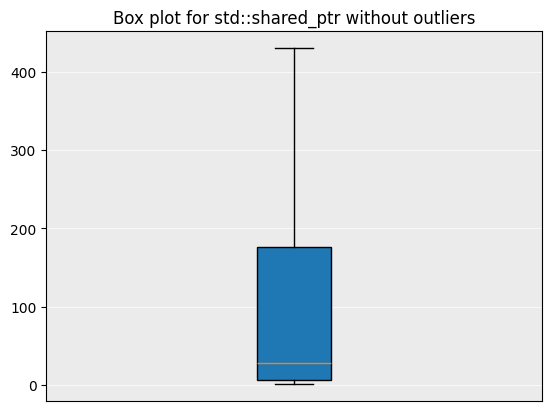

Box plot for std::weak_ptr


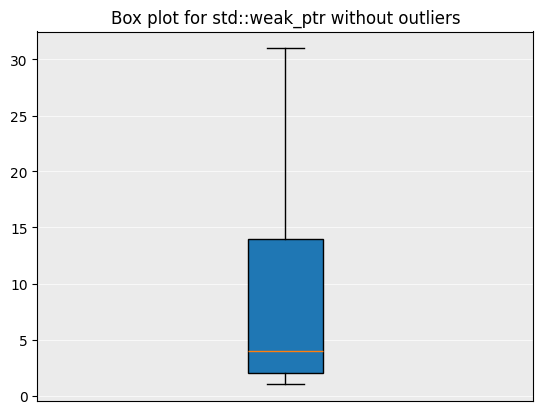

Box plot for std::unique_ptr


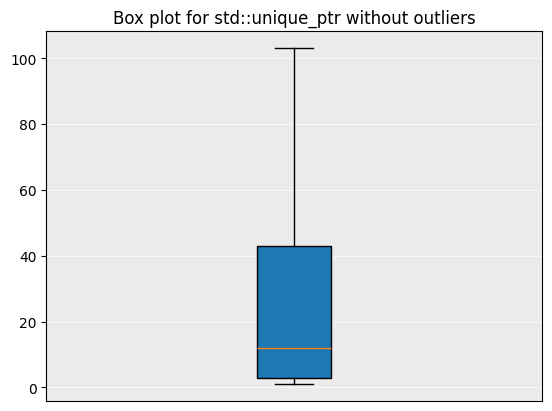

In [113]:
box_plot_smart_ptr_usage("std::shared_ptr")
box_plot_smart_ptr_usage("std::weak_ptr")
box_plot_smart_ptr_usage("std::unique_ptr")

In [114]:

def get_venn_smart_ptr_usage():
    venn_smart_ptr_usage = []
    for ss in range(1, (1 << len(SMART_PTR_NAMES))):
        print_flag = False

        smart_ptr_names = [SMART_PTR_NAMES[i] for i in range(len(SMART_PTR_NAMES)) if ss & (1 << i) > 0]
        smart_ptr_names_absent = [SMART_PTR_NAMES[i] for i in range(len(SMART_PTR_NAMES)) if ss & (1 << i) == 0]
        if len(smart_ptr_names) == 0:
            continue
        count = 0

        for pname, p in stats.items():
            if p.get("overall_features", None) is None:
                continue
            if p['overall_features'].get('utility type prevalence', None) is None:
                continue
            flag = True
            for smart_ptr_name in smart_ptr_names:
                if p['overall_features']['utility type prevalence'].get(smart_ptr_name, None) is None:
                    flag = False
                    continue
                if p['overall_features']['utility type prevalence'][smart_ptr_name] == 0:
                    flag = False
                    continue
            for smart_ptr_name in smart_ptr_names_absent:
                if p['overall_features']['utility type prevalence'].get(smart_ptr_name, None) is None:
                    continue
                if p['overall_features']['utility type prevalence'][smart_ptr_name] == 0:
                    continue
                flag = False
            if flag:
                if not print_flag:
                    print_flag = True
                    print(f"Project {pname} uses only {smart_ptr_names}")
                count += 1
        venn_smart_ptr_usage.append(count)

    return tuple(venn_smart_ptr_usage)

def get_venn_smart_ptr_usage2():
    venn_smart_ptr_usage = [0 for _ in range(1 << len(SMART_PTR_NAMES))]

    for pname, p in stats.items():
        shared_ptr_count = 0
        weak_ptr_count = 0
        unique_ptr_count = 0

        if p.get("overall_features", None) is None:
            continue
        if p['overall_features'].get('utility type prevalence', None) is None:
            continue
        if p['overall_features']['utility type prevalence'].get("std::unique_ptr", 0) > 0:
            unique_ptr_count += 1
        if p['overall_features']['utility type prevalence'].get("std::shared_ptr", 0) > 0:
            shared_ptr_count += 1
        if p['overall_features']['utility type prevalence'].get("std::weak_ptr", 0) > 0:
            weak_ptr_count += 1

        if shared_ptr_count > 0 and weak_ptr_count > 0 and unique_ptr_count > 0:
            venn_smart_ptr_usage[7] += 1
        elif shared_ptr_count > 0 and weak_ptr_count > 0:
            venn_smart_ptr_usage[6] += 1
        elif shared_ptr_count > 0 and unique_ptr_count > 0:
            venn_smart_ptr_usage[5] += 1
        elif weak_ptr_count > 0 and unique_ptr_count > 0:
            venn_smart_ptr_usage[3] += 1
        elif shared_ptr_count > 0:
            venn_smart_ptr_usage[4] += 1
        elif weak_ptr_count > 0:
            venn_smart_ptr_usage[2] += 1
        elif unique_ptr_count > 0:
            venn_smart_ptr_usage[1] += 1
        else:
            venn_smart_ptr_usage[0] += 1
        # if unique_ptr_count > 0 and shared_ptr_count > 0 and weak_ptr_count > 0:
        #     venn_smart_ptr_usage[7] += 1
        # elif unique_ptr_count > 0 and shared_ptr_count > 0:
        #     venn_smart_ptr_usage[6] += 1
        # elif unique_ptr_count > 0 and weak_ptr_count > 0:
        #     venn_smart_ptr_usage[5] += 1
        # elif shared_ptr_count > 0 and weak_ptr_count > 0:
        #     venn_smart_ptr_usage[3] += 1
        # elif unique_ptr_count > 0:
        #     venn_smart_ptr_usage[4] += 1
        # elif shared_ptr_count > 0:
        #     venn_smart_ptr_usage[2] += 1
        # elif weak_ptr_count > 0:
        #     venn_smart_ptr_usage[1] += 1
        # else:
        #     venn_smart_ptr_usage[0] += 1

        # [Abc, aBc, ABc, abC, AbC, aBC, ABC]
    return [venn_smart_ptr_usage[4], venn_smart_ptr_usage[2], venn_smart_ptr_usage[6], venn_smart_ptr_usage[1], venn_smart_ptr_usage[5], venn_smart_ptr_usage[3], venn_smart_ptr_usage[7]]

In [115]:
print(stats['fastdds']['overall_features']['utility type prevalence'])
print(stats['fastdds']['overall_features']['utility instantiation type arguments']["std::bitset"])

{'std::unique_ptr': 264, 'std::bitset': 27, 'std::shared_ptr': 731, 'std::pair': 67, 'std::weak_ptr': 30, 'std::tuple': 1}
{'16UL': 4, '37UL': 22, '4UL': 1}


bitset appears in 139 projects
Total number of bitset uses: 2854
0,107
1,74
2,108
3,75
4,108
5,87
6,63
7,49
8,135
9,20
10,46
11,25
12,25
13,14
14,11
15,9
16,36
17,10
18,4
19,6
20,4
21,13
23,5
24,1
27,9
28,12
29,2
30,2
31,5
32,131
33,11
37,22
38,7
42,5
44,5
46,1
48,4
49,3
50,1
52,2
55,59
60,6
64,425
65,8
68,59
69,13
84,6
100,1
105,7
106,1
119,11
120,12
128,217
131,10
133,10
147,2
155,2
192,4
201,2
202,2
240,2
250,1
255,4
256,97
295,529
361,1
364,1
398,2
429,1
512,8
600,2
691,2
1024,1
2000,2
2048,9
4096,10
5600,2
32769,1
65536,10
262144,2
1000000,1
150000000,52
Number of byte multiples: 1270
Rest: 1584


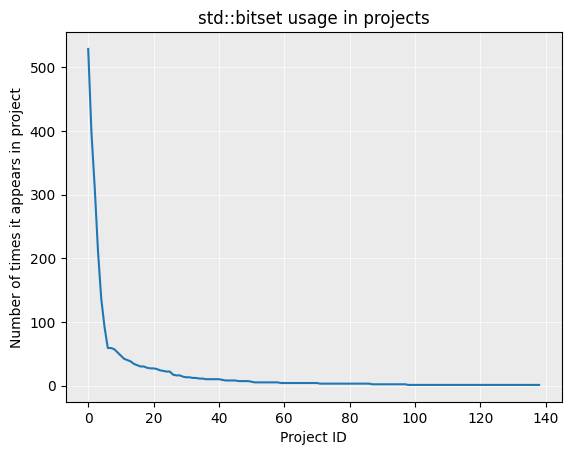

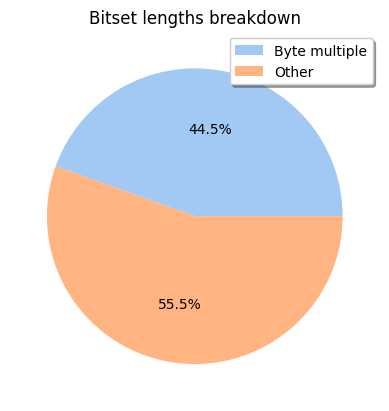

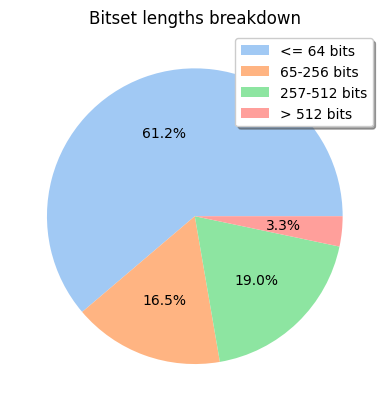

In [204]:
def plot_bitset_stuff():
    bitset_count = 0
    bitset_count_distinct = 0

    bitset_lens = defaultdict(int)
    bitset_uses = defaultdict(int)

    for pname, p in stats.items():
        if p.get("overall_features", None) is None:
            continue
        if p['overall_features'].get('utility type prevalence', None) is None:
            continue
        if p['overall_features']['utility type prevalence'].get("std::bitset", 0) > 0:
            bitset_count_distinct += 1
            bitset_count += p['overall_features']['utility type prevalence']["std::bitset"]
            bitset_uses[pname] = p['overall_features']['utility type prevalence']["std::bitset"]
        
        if p['overall_features'].get('utility instantiation type arguments', None) is None:
            continue
        if p['overall_features']['utility instantiation type arguments'].get("std::bitset", None) is None:
            continue
        for instantiation, count in p['overall_features']['utility instantiation type arguments']["std::bitset"].items():
            bitset_lens[instantiation] += count
        
    print(f"bitset appears in {bitset_count_distinct} projects")
    print(f"Total number of bitset uses: {bitset_count}")
    # print("Bitset lengths")
    # print(bitset_lens)

    # data = [(k, int(v[:-2])) for k, v in bitset_lens.items()]
    data = [(int(k[:-2]), v) for k, v in bitset_lens.items()]
    data = sorted(data, key=lambda x: x[0])
    
    is_byte_multiple = 0
    is_64_or_smaller = 0
    is_256_or_smaller = 0
    is_512_or_smaller = 0
    for k, v in data:
        print(f"{k},{v}")
        if k <= 64:
            is_64_or_smaller += v
        elif k <= 256:
            is_256_or_smaller += v
        elif k <= 512:
            is_512_or_smaller += v
        if k % 8 == 0:
            is_byte_multiple += v
            # print(f"{k} is a power of 2")

    print(f"Number of byte multiples: {is_byte_multiple}")
    print(f"Rest: {sum([x[1] for x in data]) - is_byte_multiple}")

    fig, ax = plt.subplots(1, 1)
    fig.patch.set_facecolor('xkcd:white')
    plt.grid(color='w', linestyle='-', linewidth=0.5, zorder=0)
    ax.set_facecolor((0.92, 0.92, 0.92))

    # plt.figure(figsize=(7, 9))
    plt.plot(sorted(list(bitset_uses.values()), reverse = True), zorder = 3)
    plt.xlabel('Project ID')
    plt.ylabel('Number of times it appears in project')
    plt.title(f'std::bitset usage in projects')
    # plt.xticks(x_axis, rotation=90 if len(x_axis) > 6 else 0)
    # plt.grid(True)

    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/bitset uses.pdf", bbox_inches='tight')
    # plt.close(fig)
    plt.show()

    def autopct_format(pct):
        return ('%1.1f%%' % pct) if pct > 0 else ''

    data = [is_byte_multiple, sum([x[1] for x in data]) - is_byte_multiple]
    labels = ['Byte multiple', 'Other']
    colors = sns.color_palette('pastel')[:len(data)]

    plt.pie(data, labels = None, colors = colors, autopct=autopct_format)
    # plt.legend(loc = 'upper right', labels = labels, bbox_to_anchor=(1.3, 1))
    plt.legend(loc = 'upper right', labels = labels, fancybox=True, shadow=True)
    plt.title('Bitset lengths breakdown')
    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/bitset length breakdown.pdf", bbox_inches='tight')
    plt.show()

    # plot if it is smaller than 256 bits
    data = [(int(k[:-2]), v) for k, v in bitset_lens.items()]
    data = sorted(data, key=lambda x: x[0])

    data = [is_64_or_smaller, is_256_or_smaller, is_512_or_smaller, sum([x[1] for x in data]) - is_256_or_smaller - is_512_or_smaller - is_64_or_smaller]
    labels = ['<= 64 bits', '65-256 bits', '257-512 bits', '> 512 bits']
    colors = sns.color_palette('pastel')[:len(data)]

    plt.pie(data, labels = None, colors = colors, autopct=autopct_format)
    # plt.legend(loc = 'upper right', labels = labels, bbox_to_anchor=(1.3, 1))
    plt.legend(loc = 'upper right', labels = labels, fancybox=True, shadow=True)
    plt.title('Bitset lengths breakdown')
    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/bitset length 256 breakdown.pdf", bbox_inches='tight')
    plt.show()


plot_bitset_stuff()

float, unsigned long is a pair
testing::internal::ValueArray<const char *, const char *> is a single type
pair appears in 1006 projects
Total number of pair uses: 66842
tuple appears in 316 projects
Total number of tuple uses: 28596
tuple lengths
defaultdict(<class 'int'>, {2: 8512, 1: 4339, 4: 1616, 3: 11384, 5: 636, 6: 401, 7: 187, 8: 176, 10: 69, 20: 22, 9: 137, 11: 105, 124: 1, 12: 52, 16: 36, 32: 2, 13: 77, 14: 66, 15: 60, 22: 21, 18: 45, 45: 5, 55: 4, 77: 8, 17: 46, 19: 38, 23: 22, 21: 23, 24: 16, 26: 8, 28: 13, 27: 17, 29: 12, 25: 7, 31: 6, 33: 4, 44: 9, 34: 6, 35: 6, 30: 9, 43: 1, 39: 1, 41: 2, 40: 1, 38: 1, 42: 7, 37: 1, 36: 1, 48: 4, 46: 2, 72: 5, 69: 1, 70: 4, 86: 5, 47: 5, 57: 5})
1,4339
2,8512
3,11384
4,1616
5,636
6,401
7,187
8,176
9,137
10,69
11,105
12,52
13,77
14,66
15,60
16,36
17,46
18,45
19,38
20,22
21,23
22,21
23,22
24,16
25,7
26,8
27,17
28,13
29,12
30,9
31,6
32,2
33,4
34,6
35,6
36,1
37,1
38,1
39,1
40,1
41,2
42,7
43,1
44,9
45,5
46,2
47,5
48,4
55,4
57,5
69,1
70,4
72,5


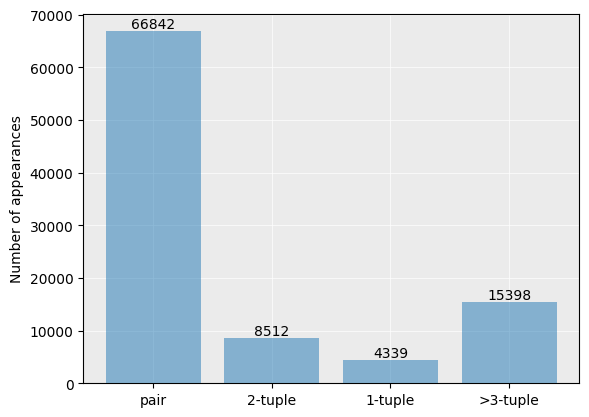

In [249]:
def plot_pair_tuple_stuff():
    def count_nr_types(type_str):
        depth = 0
        new_type_str = ""
        for c in type_str:

            if c == '<':
                depth += 1
            elif c == '>':
                depth -= 1
            elif depth == 0:
                new_type_str += c
        return len(new_type_str.split(','))

    pair_count = 0
    pair_count_distinct = 0
    pair_uses = defaultdict(int)
    pair_types = defaultdict(int)

    tuple_count = 0
    tuple_count_distinct = 0
    tuple_uses = defaultdict(int)
    tuple_types = defaultdict(int)
    tuple_lens = defaultdict(int)

    for pname, p in stats.items():
        if p.get("overall_features", None) is None:
            continue
        if p['overall_features'].get('utility type prevalence', None) is None:
            continue
        if p['overall_features']['utility type prevalence'].get("std::pair", 0) > 0:
            pair_count_distinct += 1
            pair_count += p['overall_features']['utility type prevalence']["std::pair"]
            pair_uses[pname] = p['overall_features']['utility type prevalence']["std::pair"]
        
        if p['overall_features'].get('utility instantiation type arguments', None) is None:
            continue
        if p['overall_features']['utility instantiation type arguments'].get("std::pair", None) is None:
            continue
        for instantiation, count in p['overall_features']['utility instantiation type arguments']["std::pair"].items():
            pair_types[instantiation] += count

    flag = True, True
    for pname, p in stats.items():
        if p.get("overall_features", None) is None:
            continue
        if p['overall_features'].get('utility type prevalence', None) is None:
            continue
        if p['overall_features']['utility type prevalence'].get("std::tuple", 0) > 0:
            tuple_count_distinct += 1
            tuple_count += p['overall_features']['utility type prevalence']["std::tuple"]
            tuple_uses[pname] = p['overall_features']['utility type prevalence']["std::tuple"]
        if p['overall_features'].get('utility instantiation type arguments', None) is None:
            continue
        if p['overall_features']['utility instantiation type arguments'].get("std::tuple", None) is None:
            continue
        for instantiation, count in p['overall_features']['utility instantiation type arguments']["std::tuple"].items():
            tuple_types[instantiation] += count
            tuple_lens[count_nr_types(instantiation)] += count

            if count_nr_types(instantiation) == 1 and flag[0]:
                print(f"{instantiation} is a single type")
                flag = (False, flag[1])
            if count_nr_types(instantiation) == 2 and flag[1]:
                print(f"{instantiation} is a pair")
                flag = (flag[0], False)
        
    print(f"pair appears in {pair_count_distinct} projects")
    print(f"Total number of pair uses: {pair_count}")

    print(f"tuple appears in {tuple_count_distinct} projects")
    print(f"Total number of tuple uses: {tuple_count}")
    print(f"tuple lengths")
    print(tuple_lens)

    data = [(int(k), v) for k, v in tuple_lens.items()]
    data = sorted(data, key=lambda x: x[0])

    for k, v in data:
        print(f"{k},{v}")

    # data = [(k, int(v[:-2])) for k, v in pair_lens.items()]
    data = [pair_count, tuple_lens[2], tuple_lens[1], sum(tuple_lens.values()) - tuple_lens[1] - tuple_lens[2]]
    labels = ['pair', '2-tuple', '1-tuple', '>3-tuple']
    
    x_axis = labels
    y_axis = data
    # Plot the usage
    fig, ax = plt.subplots(1, 1)
    fig.patch.set_facecolor('xkcd:white')

    plt.grid(color='w', linestyle='-', linewidth=0.5, zorder=0)
    ax.set_facecolor((0.92, 0.92, 0.92))
    # plt.figure(figsize=(7, 9))
    plt.bar(x_axis, y_axis, align='center', alpha=0.5, zorder=3)
    # plt.xlabel('Structure')
    plt.ylabel('Number of appearances')
    plt.xticks(x_axis)
    # plt.xticks(x_axis, rotation=90 if len(x_axis) > 6 else 0)
    # plt.grid(True)

    max_value = max(data)
    for i, value in enumerate(data):
        plt.text(i, value + 0.008 * max_value, str(value), ha='center')
    
    # plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/pair tuple counts.pdf", bbox_inches='tight')
    # plt.close(fig)
    plt.show()

plot_pair_tuple_stuff()

Project isl uses only ['std::shared_ptr']
Project hepmc3 uses only ['std::shared_ptr', 'std::weak_ptr']
Project phylonium uses only ['std::unique_ptr']
Project libcitygml uses only ['std::shared_ptr', 'std::unique_ptr']
Project fastdds uses only ['std::shared_ptr', 'std::weak_ptr', 'std::unique_ptr']


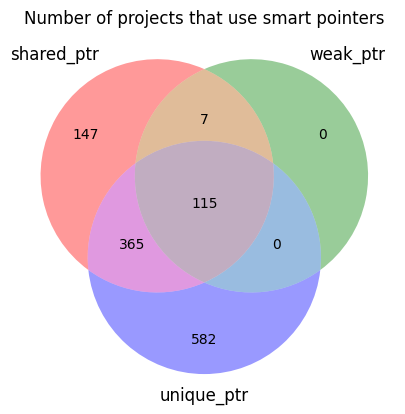

In [212]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn3, venn3_unweighted

# Example data
set1 = set(['A', 'B', 'C', 'D'])
set2 = set(['B', 'C', 'D', 'E'])

# Create Venn diagram
# venn2([set1, set2], ('Set 1', 'Set 2'))
venn3_unweighted(subsets = get_venn_smart_ptr_usage(), set_labels = tuple([x.replace("std::","") for x in SMART_PTR_NAMES]))




# Add labels
plt.title('Number of projects that use smart pointers')
# save plot
plt.savefig(f'{DATA_ANALYSIS_FOLDER}/plots/venn_smart_pointers.pdf')
plt.show()


In [162]:
def investigate_smart_ptr_parameter_instantiation_type(smart_ptr_names):
    print(f"Investigating parameter instantiation type for {smart_ptr_names}")

    instantiation_types = dict()
    for smart_ptr in smart_ptr_names:
        instantiation_types[smart_ptr] = defaultdict(int)


    # Go through every *.ast.json in the analyze folder
    files = glob.glob(f"{FEATURES_FOLDER}/**/*.ast.json", recursive = True)
    global_locations_implicit = set()
    global_locations_explicit = set()

    for file in files:
        file_project_name = file.split("/")[6]
        if file_project_name not in stats:
            continue
        # if "telegram" in file:
            # print(f"Skipping the telegram-desktop project: {file}")
            # continue
        # print(f"File: {file}")
        try:
            with open(file, "r") as fin:
                data = json.load(fin)
        except Exception as e:
            print(f"Exception: {e}")
            print(f"Skipping file: {file}")
            continue
        
        if data.get("ula", None) is None:
            continue


        for smart_ptr in smart_ptr_names:
            if data["ula"].get("templated class uses", None) is not None and smart_ptr in data["ula"]["templated class uses"]:
                for appearence in data["ula"]["templated class uses"][smart_ptr]:
                    if json.dumps(appearence) in global_locations_implicit:
                        continue
                    # if len(appearence["arguments"]["non-type"]) == 0 or len(appearence["arguments"]["template"]) == 0:
                    #     continue
                    # if len(appearence["arguments"]["type"]) == 1:
                    #     continue
                    # instantiation_types[appearence["arguments"]["type"][0]] += 1
                    # instantiation_types[json.dumps(appearence["arguments"])] += 1
                    types_temp = deepcopy(appearence["arguments"]["type"])
                    types_temp = [parse_type(x) for x in types_temp]
                    instantiation_types[smart_ptr][json.dumps(types_temp)] += 1
                    global_locations_implicit.add(json.dumps(appearence))
                    assert "../" not in appearence["GlobalLocation"], f"implicit Global location: {appearence['GlobalLocation']}, project name {file_project_name}"
            
            if data["ula"].get("explicit class insts", None) is not None and smart_ptr in data["ula"]["explicit class insts"]:
                for appearence in data["ula"]["explicit class insts"][smart_ptr]:
                    if json.dumps(appearence) in global_locations_explicit:
                        continue
                    # if len(appearence["arguments"]["non-type"]) == 0 or len(appearence["arguments"]["template"]) == 0:
                    #     continue
                    # if len(appearence["arguments"]["type"]) == 1:
                    #     continue
                    # instantiation_types[appearence["arguments"]["type"][0]] += 1
                    # instantiation_types[json.dumps(appearence["arguments"])] += 1
                    types_temp = deepcopy(appearence["arguments"]["type"])
                    types_temp = [parse_type(x) for x in types_temp]
                    instantiation_types[smart_ptr][json.dumps(types_temp)] += 1
                    global_locations_explicit.add(json.dumps(appearence))
                    assert "../" not in appearence["GlobalLocation"], f"explicit Global location: {appearence['GlobalLocation']}, project name {file_project_name}"
    
    for smart_ptr in smart_ptr_names:
        data = list(instantiation_types[smart_ptr].items())
        data = sorted(data, key = lambda x: x[1], reverse=True)
        # print(f"Number of different instantiation types: {len(instantiation_types)}")
        # for k,v in instantiation_types:
        #     print(f"{k} ::: {v}")
        
        with open(f"{DATA_ANALYSIS_FOLDER}/data/smart_ptr_parameter_type/{smart_ptr}.txt", "w") as fout:
            fout.write(f"Number of different instantiation types: {len(data)}\n")
            fout.write(f"Total number of apparitions: {sum([x[1] for x in data])}\n")
            for k, v in data:
                fout.write(f"{v}  {k}\n")


In [163]:
investigate_smart_ptr_parameter_instantiation_type(SMART_PTR_NAMES)

Investigating parameter instantiation type for ['std::shared_ptr', 'std::weak_ptr', 'std::unique_ptr']


In [121]:
lol = [pname for pname, p in stats.items() if p.get("overall_features", None) is not None and p['overall_features'].get('algorithm type prevalence', None) is not None and p['overall_features']['algorithm type prevalence'].get("std::move", 0) > 0]
print(len(lol))

92


In [122]:
for_loop_usage = defaultdict(int)
for_loop_usage_distinct = defaultdict(int)
nr_of_loop_uses = []
LOOP_KINDS = ["for", "range-for", "while", "do-while"]

with open(f"{DATA_ANALYSIS_FOLDER}/data/loop_kinds/for-loops-per-project.txt", "w") as fout:
    fout.write("project_name,for,range-for,while,do-while\n")
    loop_kinds_per_project = []
    for project_name in project_names:
        project = stats[project_name]
        if project['overall_features'] is None:
            # print(f"{project_name} has empty overall_features")
            nr_of_loop_uses.append(0)
            loop_kinds_per_project.append((project_name, 0, 0, 0, 0))
            continue

        if 'loop kind prevalences' not in project['overall_features']:
            # print(f"{project_name} has no utility type prevalence")
            nr_of_loop_uses.append(0)
            loop_kinds_per_project.append((project_name, 0, 0, 0, 0))
            continue
        # print(f'project name: {project_name}')
        if project['overall_features']['loop kind prevalences'] is None:
            # print(f"{project_name} has empty utility type prevalence")
            nr_of_loop_uses.append(0)
            loop_kinds_per_project.append((project_name, 0, 0, 0, 0))
            continue
        nr_of_loop_uses.append(sum([v for (_, v) in project['overall_features']['loop kind prevalences'].items()]))
        for loop_name, loop_uses in project['overall_features']['loop kind prevalences'].items():
            if loop_name in LOOP_KINDS:
                for_loop_usage[loop_name] += loop_uses
        
        loop_kinds_per_project.append((project_name, project['overall_features']['loop kind prevalences'].get("for", 0), project['overall_features']['loop kind prevalences'].get("range-for", 0), project['overall_features']['loop kind prevalences'].get("while", 0), project['overall_features']['loop kind prevalences'].get("do-while", 0)))
    
    loop_kinds_per_project.sort(key=lambda x: x[1] + x[2] + x[3] + x[4], reverse=True)
    for project_name, for_loop, range_for, while_loop, do_while in loop_kinds_per_project:
        fout.write(f"{project_name},{for_loop},{range_for},{while_loop},{do_while}\n")

In [123]:
print(for_loop_usage)

defaultdict(<class 'int'>, {'do-while': 2091389, 'for': 2363959, 'range-for': 202491, 'while': 440948})


Plotting uses for loop kinds
Max for loop: (517031, 'mpich')


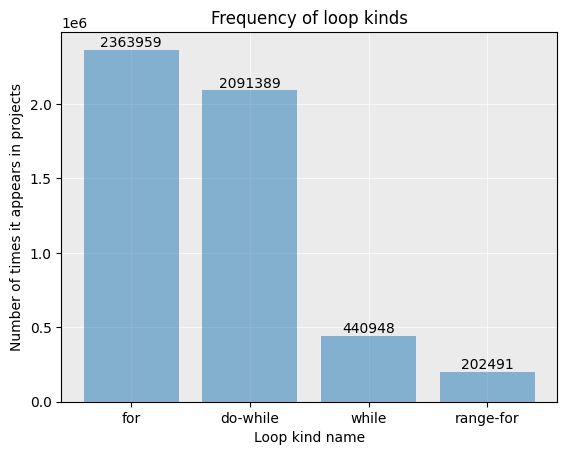

Plotting uses for loop kinds


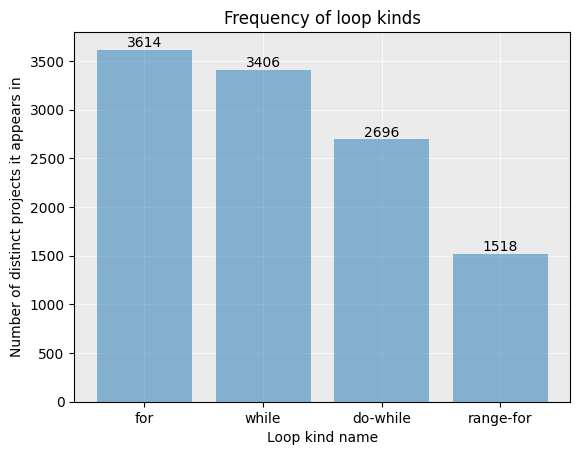

In [248]:
def plot_for_loops(loop_names):
    print(f"Plotting uses for loop kinds")

    max_for_loop = (0, None)
    
    values = []
    for loop_name in loop_names:
        projects = [p['overall_features']['loop kind prevalences'][loop_name] for pname, p in stats.items() if p.get("overall_features", None) is not None \
                    and p['overall_features'].get('loop kind prevalences', None) is not None and p['overall_features']['loop kind prevalences'].get(loop_name, 0) > 0]
        values.append((loop_name, sum(projects)))
        for pname, p in stats.items():
            if p.get("overall_features", None) is not None and p['overall_features'].get('loop kind prevalences', None) is not None \
                and p['overall_features']['loop kind prevalences'].get("for", 0) > max_for_loop[0]:
                max_for_loop = (p['overall_features']['loop kind prevalences'].get("for", 0), pname)

    print(f"Max for loop: {max_for_loop}")

    # values = [(name, nr_of_algo_uses[name]) for name in algo_names]
    values = sorted(values, key=lambda x: x[1], reverse=True)

    values = [(x[0].replace('std::', ''), x[1]) for x in values]

    x_axis = [x[0] for x in values]
    y_axis = [x[1] for x in values]
    
    # Plot the usage
    fig, ax = plt.subplots(1, 1)
    fig.patch.set_facecolor('xkcd:white')

    plt.grid(color='w', linestyle='-', linewidth=0.5, zorder=0)
    ax.set_facecolor((0.92, 0.92, 0.92))

    # plt.figure(figsize=(7, 9))
    plt.bar(x_axis, y_axis, align='center', alpha=0.5, zorder=3)
    plt.xlabel('Loop kind name')
    plt.ylabel('Number of times it appears in projects')
    plt.title(f'Frequency of loop kinds')
    plt.xticks(x_axis, rotation=90 if len(x_axis) > 6 else 0)
    plt.grid(True)

    max_value = max([x[1] for x in values])
    for i, value in enumerate(values):
        plt.text(i, value[1] + 0.008 * max_value, str(value[1]), ha='center')
    
    # plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/loop kinds in projects.pdf", bbox_inches='tight')
    # plt.close(fig)
    plt.show()

def plot_for_loops_distinct(loop_names):
    print(f"Plotting uses for loop kinds")
    
    values = []
    for loop_name in loop_names:
        projects = [p['overall_features']['loop kind prevalences'][loop_name] for pname, p in stats.items() if p.get("overall_features", None) is not None \
                    and p['overall_features'].get('loop kind prevalences', None) is not None and p['overall_features']['loop kind prevalences'].get(loop_name, 0) > 0]
        values.append((loop_name, len(projects)))


    # values = [(name, nr_of_algo_uses[name]) for name in algo_names]
    values = sorted(values, key=lambda x: x[1], reverse=True)

    values = [(x[0].replace('std::', ''), x[1]) for x in values]

    x_axis = [x[0] for x in values]
    y_axis = [x[1] for x in values]
    # Plot the usage
    fig, ax = plt.subplots(1, 1)
    fig.patch.set_facecolor('xkcd:white')

    plt.grid(color='w', linestyle='-', linewidth=0.5, zorder=0)
    ax.set_facecolor((0.92, 0.92, 0.92))
    # plt.figure(figsize=(7, 9))
    plt.bar(x_axis, y_axis, align='center', alpha=0.5, zorder=3)
    plt.xlabel('Loop kind name')
    plt.ylabel('Number of distinct projects it appears in')
    plt.title(f'Frequency of loop kinds')
    plt.xticks(x_axis, rotation=90 if len(x_axis) > 6 else 0)
    # plt.grid(True)

    max_value = max([x[1] for x in values])
    for i, value in enumerate(values):
        plt.text(i, value[1] + 0.008 * max_value, str(value[1]), ha='center')
    
    # plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/loop kinds in distinct projects.pdf", bbox_inches='tight')
    # plt.close(fig)
    plt.show()

plot_for_loops(LOOP_KINDS)
plot_for_loops_distinct(LOOP_KINDS)

Project fontmatrix uses only for
Project berkeley-express uses both for and range-for
Project exhale uses neither for nor range-for
Project pyosmium uses only range-for


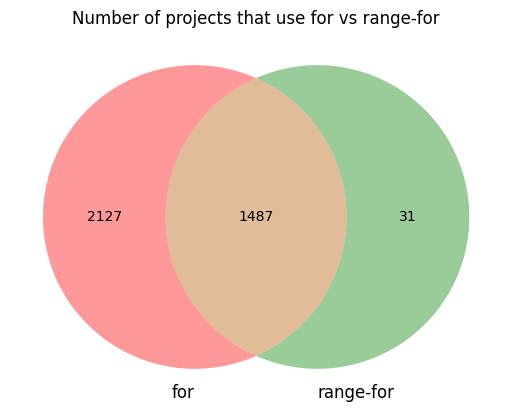

In [125]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn2_unweighted

def get_venn_for_loop_usage():
    for_vs_range_for = [0, 0, 0, 0]
    print_flag = [False, False, False, False]
    # just simple for loop
    for pname, project in stats.items():
        for_usage = 0
        range_for_usage = 0

        if project.get("overall_features", None) is not None and project['overall_features'].get('loop kind prevalences', None) is not None and project['overall_features']['loop kind prevalences'].get("for", 0) > 0:
            for_usage += 1
        
        if project.get("overall_features", None) is not None and project['overall_features'].get('loop kind prevalences', None) is not None and project['overall_features']['loop kind prevalences'].get("range-for", 0) > 0:
            range_for_usage += 1

        if for_usage > 0 and range_for_usage > 0:
            if not print_flag[3]:
                print_flag[3] = True
                print(f"Project {pname} uses both for and range-for")
            for_vs_range_for[3] += 1
        elif for_usage > 0:
            if not print_flag[1]:
                print_flag[1] = True
                print(f"Project {pname} uses only for")
            for_vs_range_for[2] += 1
        elif range_for_usage > 0:
            if not print_flag[2]:
                print_flag[2] = True
                print(f"Project {pname} uses only range-for")
            for_vs_range_for[1] += 1
        else:
            if not print_flag[0]:
                print_flag[0] = True
                print(f"Project {pname} uses neither for nor range-for")
            for_vs_range_for[0] += 1
    # [Ab, aB, AB]
    return [for_vs_range_for[2], for_vs_range_for[1], for_vs_range_for[3]]
    # return for_vs_range_for

# Example data
# set1 = set(['A', 'B', 'C', 'D'])
# set2 = set(['B', 'C', 'D', 'E'])

# Create Venn diagram
# venn2([set1, set2], ('Set 1', 'Set 2'))
venn2_unweighted(subsets = get_venn_for_loop_usage(), set_labels = ("for", "range-for"))




# Add labels
plt.title('Number of projects that use for vs range-for')
# save plot
plt.savefig(f'{DATA_ANALYSIS_FOLDER}/plots/for_vs_range_for.png')
plt.show()


In [126]:
alias_typedef_usage = defaultdict(int)
alias_typedef_usage_distinct = defaultdict(int)
nr_alias_typedef_uses = []
ALIAS_KINDS = ["typedef", "using", "templated typedef", "templated using"]

with open(f"{DATA_ANALYSIS_FOLDER}/data/alias_kinds/alias-uses-per-project.txt", "w") as fout:
    fout.write("project_name,typedef,alias,typedef template,alias templates\n")
    alias_kinds_per_project = []
    for project_name in project_names:
        project = stats[project_name]
        if project['overall_features'] is None:
            # print(f"{project_name} has empty overall_features")
            nr_alias_typedef_uses.append(0)
            alias_kinds_per_project.append((project_name, 0, 0, 0, 0))
            continue

        if 'prevalence of typedef/using' not in project['overall_features']:
            # print(f"{project_name} has no utility type prevalence")
            nr_alias_typedef_uses.append(0)
            alias_kinds_per_project.append((project_name, 0, 0, 0, 0))
            continue
        # print(f'project name: {project_name}')
        if project['overall_features']['prevalence of typedef/using'] is None:
            # print(f"{project_name} has empty utility type prevalence")
            nr_alias_typedef_uses.append(0)
            alias_kinds_per_project.append((project_name, 0, 0, 0, 0))
            continue
        nr_alias_typedef_uses.append(sum([v for (_, v) in project['overall_features']['prevalence of typedef/using'].items()]))
        for alias_name, alias_uses in project['overall_features']['prevalence of typedef/using'].items():
            if alias_name in ALIAS_KINDS:
                alias_typedef_usage[alias_name] += alias_uses
        
    alias_kinds_per_project.sort(key=lambda x: x[1] + x[2] + x[3] + x[4], reverse=True)
    for project_name, typedef, alias, typedef_template, alias_template in alias_kinds_per_project:
        fout.write(f"{project_name},{typedef},{alias},{typedef_template},{alias_template}\n")


print(alias_typedef_usage)

defaultdict(<class 'int'>, {'typedef': 590068, 'using': 136102, 'templated typedef': 4486, 'templated using': 5694})


Plotting uses for alias kinds


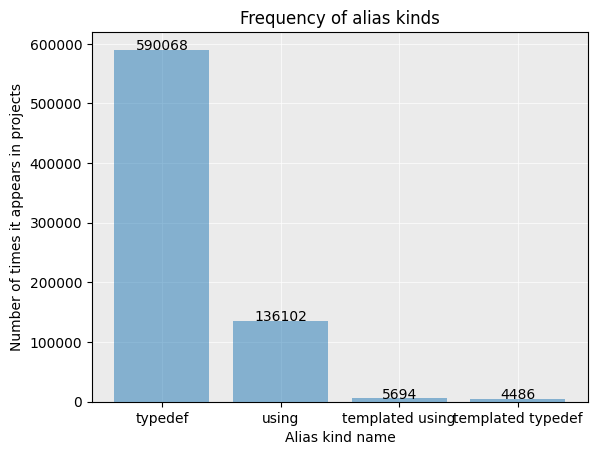

Plotting uses for loop kinds


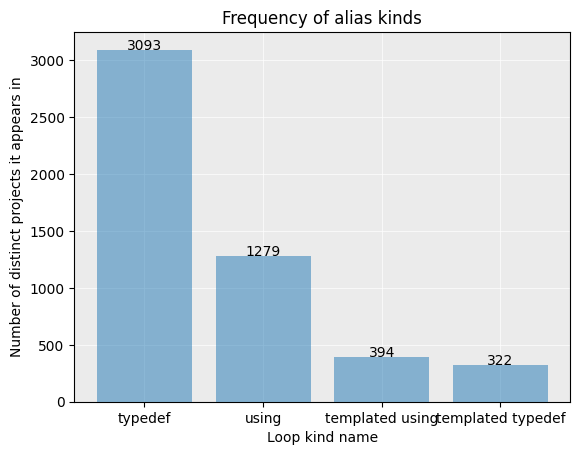

In [127]:
def plot_alias_typedef(alias_kinds):
    print(f"Plotting uses for alias kinds")
    
    values = []
    for alias_kind in alias_kinds:
        projects = [p['overall_features']['prevalence of typedef/using'][alias_kind] for pname, p in stats.items() if p.get("overall_features", None) is not None \
                    and p['overall_features'].get('prevalence of typedef/using', None) is not None and p['overall_features']['prevalence of typedef/using'].get(alias_kind, 0) > 0]
        values.append((alias_kind, sum(projects)))


    # values = [(name, nr_of_algo_uses[name]) for name in algo_names]
    values = sorted(values, key=lambda x: x[1], reverse=True)

    values = [(x[0].replace('std::', ''), x[1]) for x in values]

    x_axis = [x[0] for x in values]
    y_axis = [x[1] for x in values]
    # Plot the usage
    # plt.figure(figsize=(7, 9))
    fig, ax = plt.subplots(1, 1)
    fig.patch.set_facecolor('xkcd:white')

    plt.grid(color='w', linestyle='-', linewidth=0.5, zorder=0)
    ax.set_facecolor((0.92, 0.92, 0.92))

    plt.bar(x_axis, y_axis, align='center', alpha=0.5, zorder=3)
    plt.xlabel('Alias kind name')
    plt.ylabel('Number of times it appears in projects')
    plt.title(f'Frequency of alias kinds')
    plt.xticks(x_axis, rotation=90 if len(x_axis) > 6 else 0)
    # plt.grid(True)

    max_value = max([x[1] for x in values])
    for i, value in enumerate(values):
        plt.text(i, value[1] + 0.008 * max_value, str(value[1]), ha='center')
    
    # plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/alias kinds in projects.png", bbox_inches='tight')
    plt.show()

def plot_alias_typedef_distinct(alias_kinds):
    print(f"Plotting uses for loop kinds")
    
    values = []
    for alias_kind in alias_kinds:
        projects = [p['overall_features']['prevalence of typedef/using'][alias_kind] for pname, p in stats.items() if p.get("overall_features", None) is not None \
                    and p['overall_features'].get('prevalence of typedef/using', None) is not None and p['overall_features']['prevalence of typedef/using'].get(alias_kind, 0) > 0]
        values.append((alias_kind, len(projects)))


    # values = [(name, nr_of_algo_uses[name]) for name in algo_names]
    values = sorted(values, key=lambda x: x[1], reverse=True)

    values = [(x[0].replace('std::', ''), x[1]) for x in values]

    x_axis = [x[0] for x in values]
    y_axis = [x[1] for x in values]
    # Plot the usage
    # plt.figure(figsize=(7, 9))
    fig, ax = plt.subplots(1, 1)
    fig.patch.set_facecolor('xkcd:white')

    plt.grid(color='w', linestyle='-', linewidth=0.5, zorder=0)
    ax.set_facecolor((0.92, 0.92, 0.92))
    
    plt.bar(x_axis, y_axis, align='center', alpha=0.5, zorder=3)
    plt.xlabel('Loop kind name')
    plt.ylabel('Number of distinct projects it appears in')
    plt.title(f'Frequency of alias kinds')
    plt.xticks(x_axis, rotation=90 if len(x_axis) > 6 else 0)
    # plt.grid(True)

    max_value = max([x[1] for x in values])
    for i, value in enumerate(values):
        plt.text(i, value[1] + 0.008 * max_value, str(value[1]), ha='center')
    
    # plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/alias kinds in distinct projects.png", bbox_inches='tight')
    plt.show()

plot_alias_typedef(ALIAS_KINDS)
plot_alias_typedef_distinct(ALIAS_KINDS)

Project fontmatrix uses both typedef and using
Project fldigi uses only typedef
Project dicomscope uses neither typedef nor using
Project qt6ct uses only using


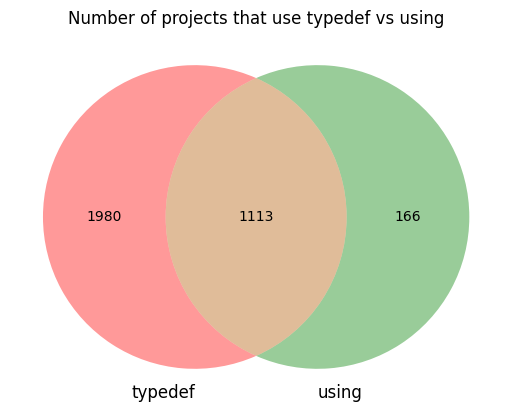

In [128]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn2_unweighted

def get_venn_alias_kind_usage():
    typedef_vs_using = [0, 0, 0, 0]
    print_flag = [False, False, False, False]

    # just simple for loop
    for pname, project in stats.items():
        typedef_usage = 0
        using_usage = 0

        if project.get("overall_features", None) is not None and project['overall_features'].get('prevalence of typedef/using', None) is not None and project['overall_features']['prevalence of typedef/using'].get("typedef", 0) > 0:
            typedef_usage += 1
        
        if project.get("overall_features", None) is not None and project['overall_features'].get('prevalence of typedef/using', None) is not None and project['overall_features']['prevalence of typedef/using'].get("using", 0) > 0:
            using_usage += 1
        
        if typedef_usage > 0 and using_usage > 0:
            if not print_flag[3]:
                print_flag[3] = True
                print(f"Project {pname} uses both typedef and using")
            typedef_vs_using[3] += 1
        elif typedef_usage > 0:
            if not print_flag[2]:
                print_flag[2] = True
                print(f"Project {pname} uses only typedef")
            typedef_vs_using[2] += 1
        elif using_usage > 0:
            if not print_flag[1]:
                print_flag[1] = True
                print(f"Project {pname} uses only using")
            typedef_vs_using[1] += 1
        else:
            if not print_flag[0]:
                print_flag[0] = True
                print(f"Project {pname} uses neither typedef nor using")
            typedef_vs_using[0] += 1

    # [Ab, aB, AB]
    return [typedef_vs_using[2], typedef_vs_using[1], typedef_vs_using[3]]
    # return typedef_vs_using

# Create Venn diagram
# venn2([set1, set2], ('Set 1', 'Set 2'))
venn2_unweighted(subsets = get_venn_alias_kind_usage(), set_labels = ("typedef", "using"))




# Add labels
plt.title('Number of projects that use typedef vs using')
# save plot
plt.savefig(f'{DATA_ANALYSIS_FOLDER}/plots/typedef_vs_using.png')
plt.show()


# Modern keywords usage analysis

Plotting uses for modern keywords


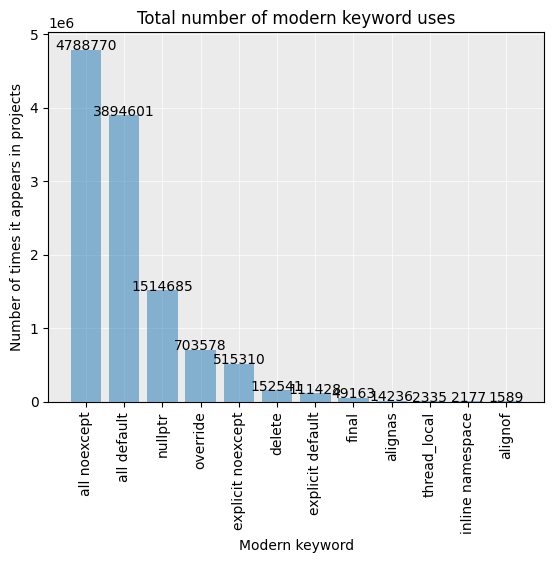

Plotting distinct uses for modern keywords


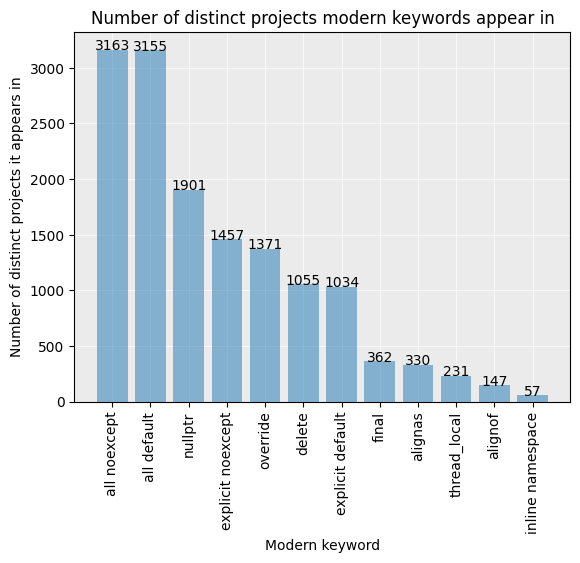

In [129]:
MODERN_KEYWORDS = ["alignas", "alignof", "all default", "explicit default", "delete", "final", "inline namespace", "all noexcept", "explicit noexcept", "nullptr", "thread_local", "override"]
# MODERN_KEYWORDS = ["default", "delete", "final", "noexcept"] # that have total_count
# MODERN_KEYWORDS = ["final"] # that have total_count

def plot_modern_keywords(keywords):
    print(f"Plotting uses for modern keywords")
    
    values = []
    for keyword in keywords:
        for project_name, p in stats.items():
            if p.get("overall_features", None) is not None \
                    and p['overall_features'].get('modern keywords prevalence', None) is not None and \
                        p['overall_features']['modern keywords prevalence'].get(keyword, None) is not None and \
                            "total count" not in p['overall_features']['modern keywords prevalence'][keyword]:
                print(f"Project {project_name} doesn't have total count for {keyword}")
                return
        projects = [p['overall_features']['modern keywords prevalence'][keyword]["total count"] for pname, p in stats.items() if p.get("overall_features", None) is not None \
                    and p['overall_features'].get('modern keywords prevalence', None) is not None and p['overall_features']['modern keywords prevalence'].get(keyword, None) is not None and p['overall_features']['modern keywords prevalence'][keyword].get("total count", 0) > 0]
        values.append((keyword, sum(projects)))


    # values = [(name, nr_of_algo_uses[name]) for name in algo_names]
    values = sorted(values, key=lambda x: x[1], reverse=True)

    values = [(x[0].replace('std::', ''), x[1]) for x in values]

    x_axis = [x[0] for x in values]
    y_axis = [x[1] for x in values]
    # Plot the usage
    # plt.figure(figsize=(7, 9))
    fig, ax = plt.subplots(1, 1)
    fig.patch.set_facecolor('xkcd:white')

    plt.grid(color='w', linestyle='-', linewidth=0.5, zorder=0)
    ax.set_facecolor((0.92, 0.92, 0.92))

    plt.bar(x_axis, y_axis, align='center', alpha=0.5, zorder=3)
    plt.xlabel('Modern keyword')
    plt.ylabel('Number of times it appears in projects')
    plt.title(f'Total number of modern keyword uses')
    plt.xticks(x_axis, rotation=90 if len(x_axis) > 6 else 0)
    # plt.grid(True)

    for i, value in enumerate(values):
        plt.text(i, value[1], str(value[1]), ha='center')
    
    # plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/modern keywords in projects.pdf", bbox_inches='tight')
    plt.show()

def plot_modern_keywords_distinct(keywords):
    print(f"Plotting distinct uses for modern keywords")
    
    values = []
    for keyword in keywords:
        for project_name, p in stats.items():
            if p.get("overall_features", None) is not None \
                    and p['overall_features'].get('modern keywords prevalence', None) is not None and \
                        p['overall_features']['modern keywords prevalence'].get(keyword, None) is not None and \
                            "total count" not in p['overall_features']['modern keywords prevalence'][keyword]:
                print(f"Project {project_name} doesn't have total count for {keyword}")
                return

        projects = [p['overall_features']['modern keywords prevalence'][keyword]["total count"] for pname, p in stats.items() if p.get("overall_features", None) is not None \
                    and p['overall_features'].get('modern keywords prevalence', None) is not None and p['overall_features']['modern keywords prevalence'].get(keyword, None) is not None and p['overall_features']['modern keywords prevalence'][keyword].get("total count", 0) > 0]
        values.append((keyword, len(projects)))


    # values = [(name, nr_of_algo_uses[name]) for name in algo_names]
    values = sorted(values, key=lambda x: x[1], reverse=True)

    values = [(x[0].replace('std::', ''), x[1]) for x in values]

    x_axis = [x[0] for x in values]
    y_axis = [x[1] for x in values]
    # Plot the usage
    # plt.figure(figsize=(7, 9))
    fig, ax = plt.subplots(1, 1)
    fig.patch.set_facecolor('xkcd:white')

    plt.grid(color='w', linestyle='-', linewidth=0.5, zorder=0)
    ax.set_facecolor((0.92, 0.92, 0.92))

    plt.bar(x_axis, y_axis, align='center', alpha=0.5, zorder=3)
    plt.xlabel('Modern keyword')
    plt.ylabel('Number of distinct projects it appears in')
    plt.title(f'Number of distinct projects modern keywords appear in')
    plt.xticks(x_axis, rotation=90 if len(x_axis) > 6 else 0)
    # plt.grid(True)

    for i, value in enumerate(values):
        plt.text(i, value[1], str(value[1]), ha='center')
    
    # plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/modern keywords in distinct projects.pdf", bbox_inches='tight')
    plt.show()

plot_modern_keywords(MODERN_KEYWORDS)
plot_modern_keywords_distinct(MODERN_KEYWORDS)

In [130]:
MODERN_KEYWORDS = ["alignas", "alignof", "default", "delete", "final", "inline namespace", "noexcept", "thread_local", "override", "explicit", "explicit default", "explicit noexcept", "all noexcept", "all default"]

def count_keyword_use_per_project(keywords):
    for keyword in keywords:
        with open(f"{DATA_ANALYSIS_FOLDER}/data/modern_keywords/" + keyword + " in projects.txt", "w") as fout:
            fout.write(f"Project name,Total count,Lines of C++\n")
            uses = [(pname, p['overall_features']['modern keywords prevalence'][keyword]["total count"]) for pname, p in stats.items() if p.get("overall_features", None) is not None and \
                    p['overall_features'].get('modern keywords prevalence', None) is not None and p['overall_features']['modern keywords prevalence'].get(keyword, None) is not None and \
                        "total count" in p['overall_features']['modern keywords prevalence'][keyword]]
            uses = sorted(uses, key=lambda x: x[1], reverse=True)
            total_use = 0
            for pname, use in uses:
                fout.write(f"{pname},{use},{sloc_info.get(pname, -1)}\n")
                total_use += use
            
            # print(f"Total use for {keyword}: {total_use}")
    
count_keyword_use_per_project(MODERN_KEYWORDS)

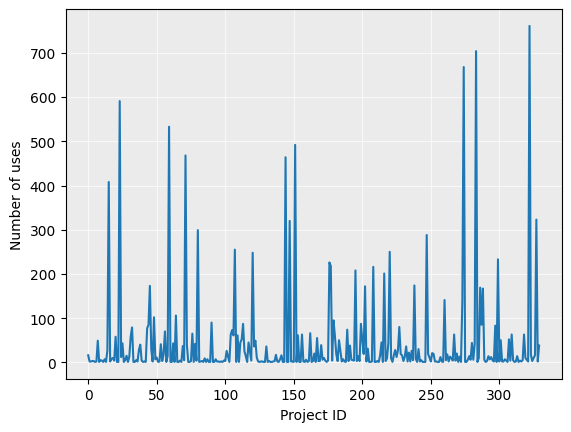

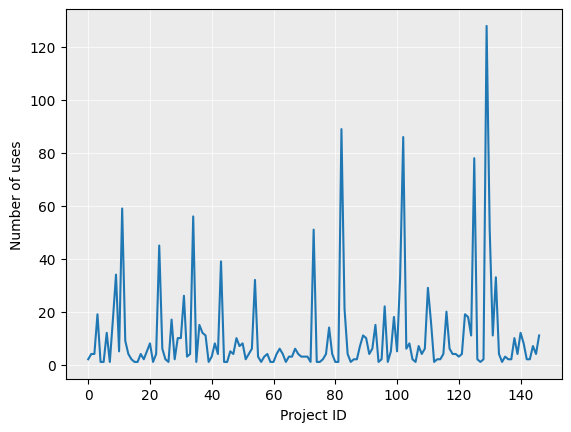

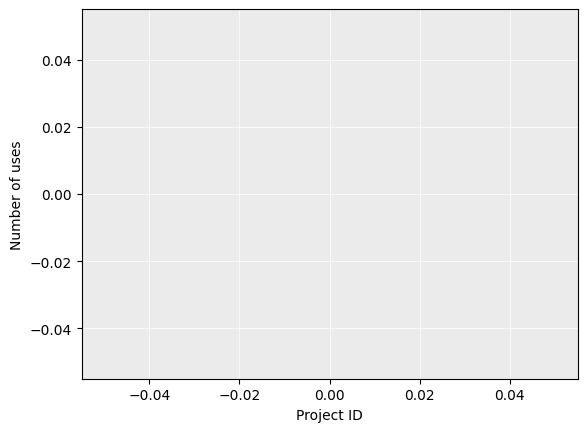

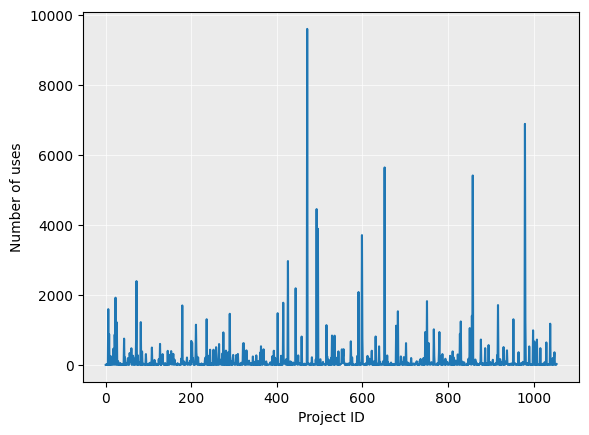

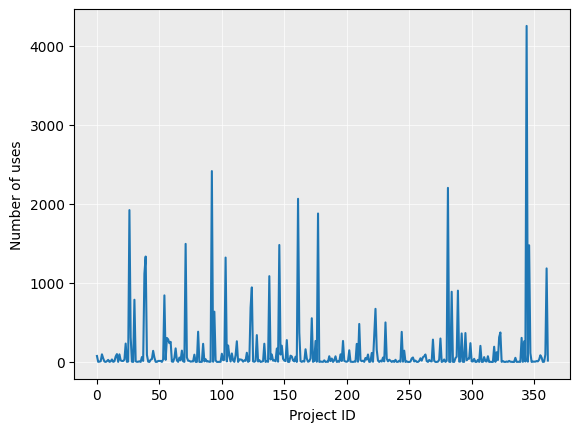

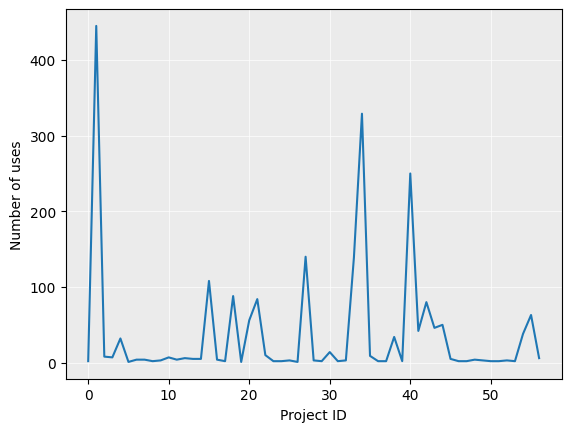

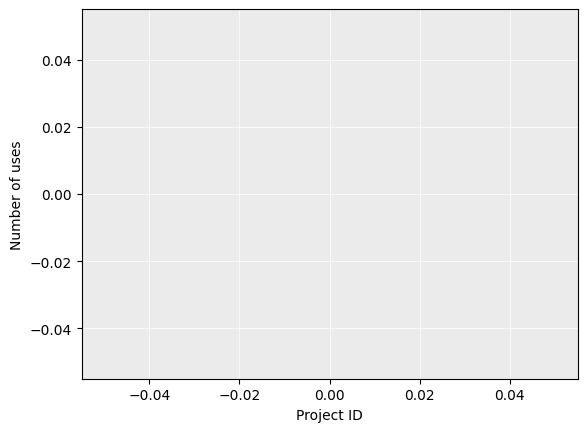

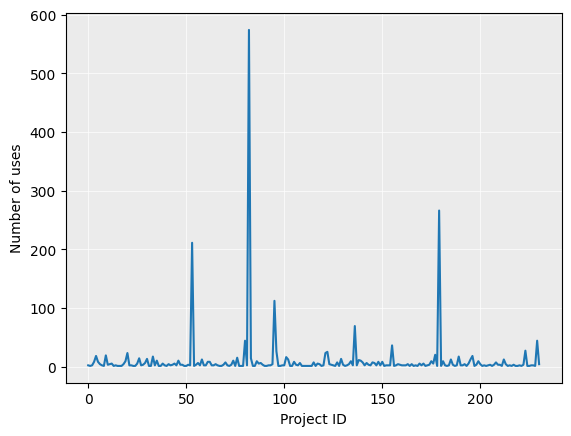

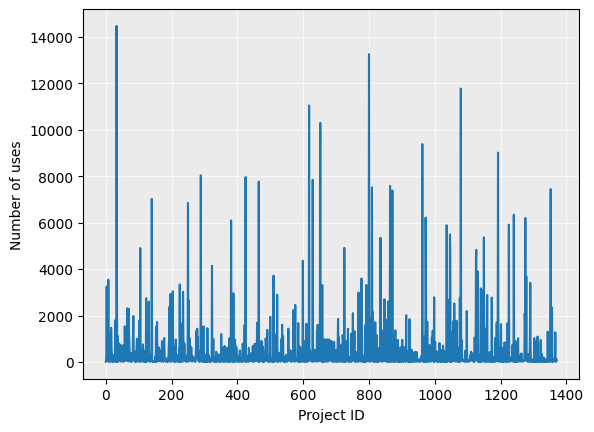

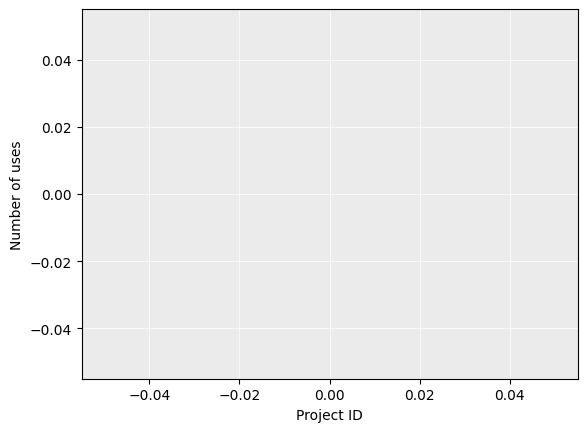

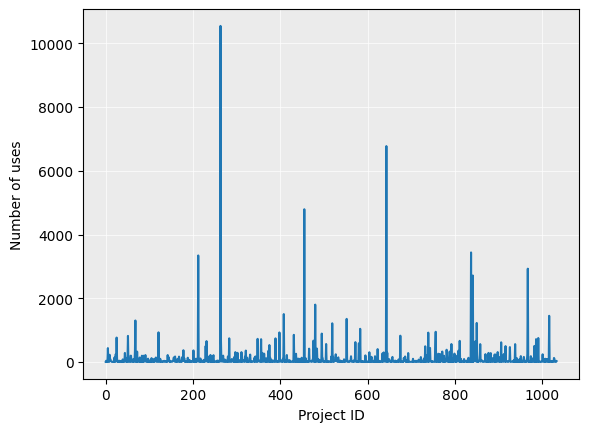

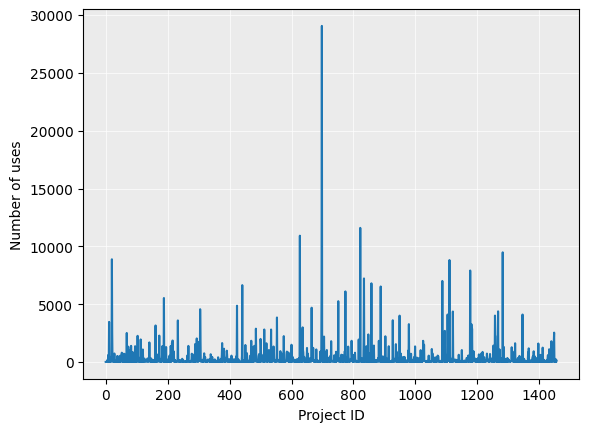

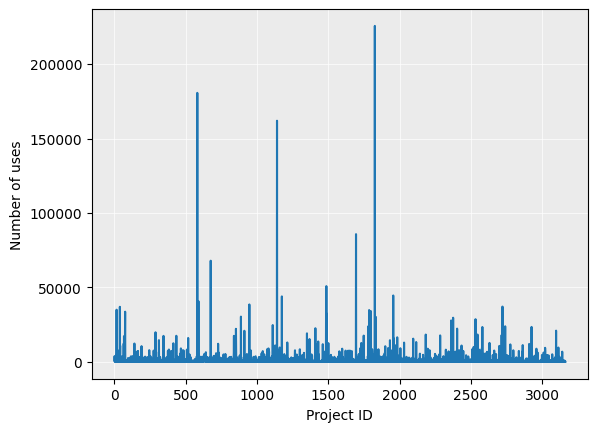

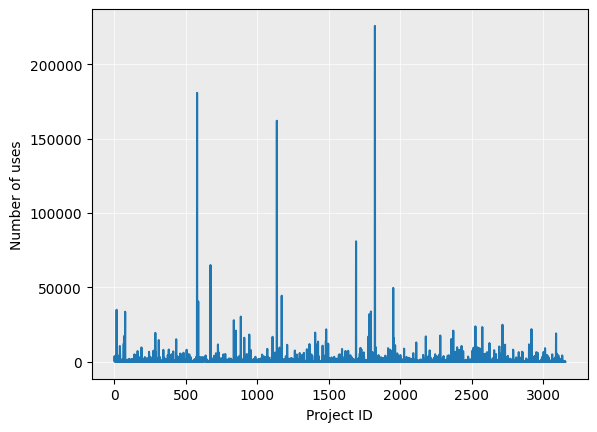

In [131]:
def plot_keyword_use_per_project(keywords):
    for keyword in keywords:
        data = []
        for project_name, project in stats.items():
            if project.get('overall_features', None) is None:
                continue
            if project['overall_features'].get('modern keywords prevalence', None) is None:
                continue
            if project['overall_features']['modern keywords prevalence'].get(keyword, None) is None:
                continue
            if project['overall_features']['modern keywords prevalence'][keyword].get("total count", 0) == 0:
                continue
            data.append((project_name, project['overall_features']['modern keywords prevalence'][keyword]["total count"]))
        
        data = [x[1] for x in data]

        fig, ax = plt.subplots(1, 1)
        fig.patch.set_facecolor('xkcd:white')

        plt.grid(color='w', linestyle='-', linewidth=0.5, zorder=0)
        ax.set_facecolor((0.92, 0.92, 0.92))

        plt.plot(data, zorder = 3)
        plt.xlabel('Project ID')
        plt.ylabel('Number of uses')
        # plt.xticks(x_axis, rotation=90 if len(x_axis) > 6 else 0)
        # plt.grid(True)

        # for i, value in enumerate(values):
        #     plt.text(i, value[1], str(value[1]), ha='center')
        
        # plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

        plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/{keyword} use in projects.pdf", bbox_inches='tight')
        plt.show()

# plot_keyword_use_per_project(MODERN_KEYWORDS)

Project fontmatrix uses only implicit
Project dicomscope uses neither explicit nor implicit
Project phylonium uses both explicit and implicit
Project suil uses only explicit
Project suil uses only explicit
Project cpuinfo uses only explicit
explicit_usage: 1034
explicit_vs_implicit: [1156, 2121, 2, 1032]


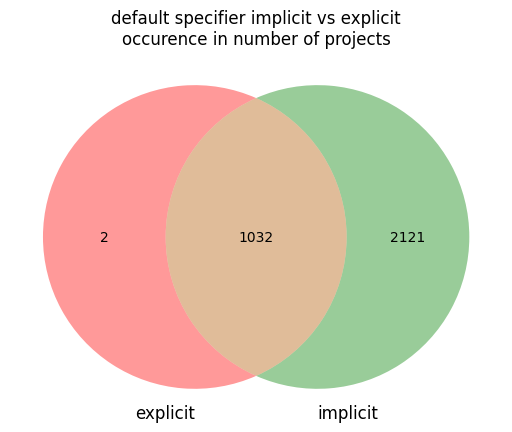

All default count: defaultdict(<class 'int'>, {'total count': 3894601, 'all default constructors': 245669, 'all default member functions': 1910843, 'all default functions': 88})
Explicit default count: defaultdict(<class 'int'>, {'total count': 111428, 'explicit default constructors': 27759, 'explicit default member functions': 56302, 'explicit default functions': 46})
Implicit default count: defaultdict(<class 'int'>, {'total count': 3783173, 'implicit default constructors': 217910, 'implicit default member functions': 1854541, 'implicit default functions': 42})
Explicit default appears in 1034 projects
default implict and explicit appear in 3155 projects


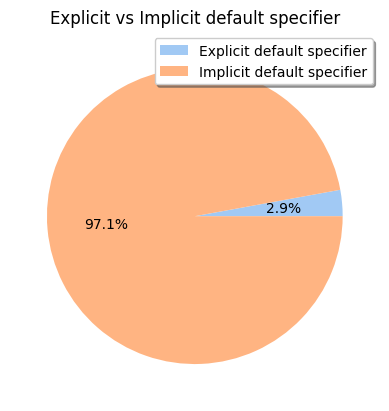

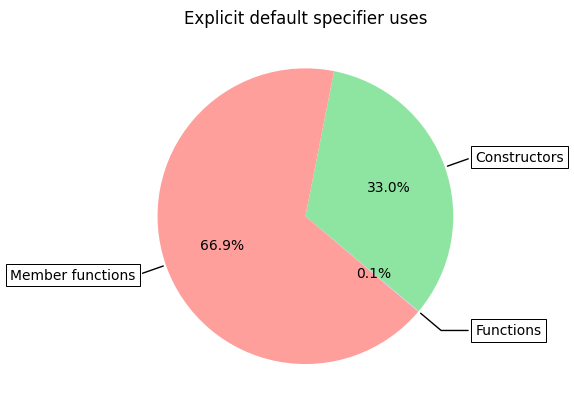

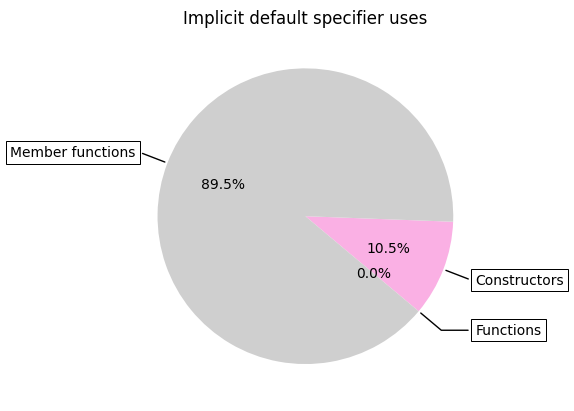

set()
1034 1034 0 1034 0


In [220]:
venn_set = set()
plots_set = set()

def plots_for_default_keyword():
    global plots_set

    explicit_count = defaultdict(int)
    implicit_count = defaultdict(int)
    all_count = defaultdict(int)

    explicit_projects_count = 0
    all_projects_count = 0

    def autopct_format(pct):
        return ('%1.1f%%' % pct) if pct > 0 else ''


    for project_name, p in stats.items():
        if p.get("overall_features", None) is not None and p['overall_features'].get('modern keywords prevalence', None) is not None and \
            p['overall_features']['modern keywords prevalence'].get("explicit default", None) is not None and \
                "total count" in p['overall_features']['modern keywords prevalence']["explicit default"]:
            for count_key, count_value in p['overall_features']['modern keywords prevalence']["explicit default"].items():
                explicit_count[count_key] += count_value
            if p['overall_features']['modern keywords prevalence']["explicit default"]["total count"] > 0:
                explicit_projects_count += 1
                plots_set.add(project_name)
        if p.get("overall_features", None) is not None and p['overall_features'].get('modern keywords prevalence', None) is not None and \
            p['overall_features']['modern keywords prevalence'].get("all default", None) is not None and \
                "total count" in p['overall_features']['modern keywords prevalence']["all default"]:
            
            for count_key, count_value in p['overall_features']['modern keywords prevalence']["all default"].items():
                all_count[count_key] += count_value
            if p['overall_features']['modern keywords prevalence']["all default"]["total count"] > 0:
                all_projects_count += 1
            # all_count += p['overall_features']['modern keywords prevalence']["all default"]["total count"]
    
    # for keys in explicit_count.keys():
    #     implicit_count[keys] = all_count[keys] - explicit_count[keys]

    implicit_count['total count'] = all_count['total count'] - explicit_count['total count']
    implicit_count['implicit default constructors'] = all_count['all default constructors'] - explicit_count['explicit default constructors']
    implicit_count['implicit default member functions'] = all_count['all default member functions'] - explicit_count['explicit default member functions']
    implicit_count['implicit default functions'] = all_count['all default functions'] - explicit_count['explicit default functions']

    print(f"All default count: {all_count}")
    print(f"Explicit default count: {explicit_count}")
    print(f"Implicit default count: {implicit_count}")

    print(f"Explicit default appears in {explicit_projects_count} projects")
    print(f"default implict and explicit appear in {all_projects_count} projects")

    # pie chart of explicit vs implicit default
    data = [explicit_count['total count'], implicit_count['total count']]
    labels = ['Explicit default specifier', 'Implicit default specifier']
    colors = sns.color_palette('pastel')[:len(data)]

    plt.pie(data, labels = None, colors = colors, autopct=autopct_format)
    # plt.legend(loc = 'upper right', labels = labels, bbox_to_anchor=(1.3, 1))
    plt.legend(loc = 'upper right', labels = labels, fancybox=True, shadow=True)
    plt.title('Explicit vs Implicit default specifier')
    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/Explicit vs Implicit default specifier.pdf", bbox_inches='tight')
    plt.show()

    # pie chart of explicit: constructor vs member function vs function
    data = [explicit_count['explicit default constructors'], explicit_count['explicit default member functions'], explicit_count['explicit default functions']]
    labels = ['Constructors', 'Member functions', 'Functions']
    colors = sns.color_palette('pastel')[2:2 + len(data)]

    # plt.pie(data, labels = None, colors = colors, autopct=autopct_format)
    wedges, texts, _ = plt.pie(data, startangle=-40, labels = None, colors = colors, autopct=autopct_format)

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
            bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        plt.annotate(labels[i], xy=(x, y), xytext=(1.15*np.sign(x), 1.2*y),
                    horizontalalignment=horizontalalignment, **kw)

    # plt.legend(loc = 'upper right', labels = labels, bbox_to_anchor=(1.3, 1))
    # plt.legend(loc = 'upper left', labels = labels, fancybox=True, shadow=True)
    plt.title('Explicit default specifier uses')
    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/Explicit default specifier uses.pdf", bbox_inches='tight')
    plt.show()

    # pie chart of implicit: constructor vs member function vs function
    data = [implicit_count['implicit default constructors'], implicit_count['implicit default member functions'], implicit_count['implicit default functions']]
    labels = ['Constructors', 'Member functions', 'Functions']
    colors = sns.color_palette('pastel')[6: 6 + len(data)]

    # plt.pie(data, labels = None, colors = colors, autopct=autopct_format)
    wedges, texts, _ = plt.pie(data, startangle=-40, labels = None, colors = colors, autopct=autopct_format)
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
            bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        plt.annotate(labels[i], xy=(x, y), xytext=(1.15*np.sign(x), 1.2*y),
                    horizontalalignment=horizontalalignment, **kw)
    # plt.legend(loc = 'upper right', labels = labels, bbox_to_anchor=(1.3, 1))
    # plt.legend(loc = 'upper left', labels = labels, fancybox=True, shadow=True)
    plt.title('Implicit default specifier uses')
    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/Implicit default specifier uses.pdf", bbox_inches='tight', dpi=500)
    plt.show()

def venn_for_default_keyword():
    # global venn_set
    def get_venn_default_usage():
        global venn_set
        explicit_vs_implicit = [0, 0, 0, 0]
        print_flag = [False, False, False, False]

        explicit_usage_count_t = 0

        # just simple for loop
        for pname, project in stats.items():
            explicit_usage = 0
            implicit_usage = 0

            if project.get("overall_features", None) is not None and project['overall_features'].get('modern keywords prevalence', None) is not None and project['overall_features']['modern keywords prevalence'].get("explicit default", None) is not None and project['overall_features']['modern keywords prevalence']['explicit default'].get('total count', 0) > 0:
                explicit_usage += 1
                explicit_usage_count_t += 1
                venn_set.add(pname)

            if project.get("overall_features", None) is not None and project['overall_features'].get('modern keywords prevalence', None) is not None and project['overall_features']['modern keywords prevalence'].get("explicit default", None) is not None and project['overall_features']['modern keywords prevalence']['explicit default'].get('total count', 0) < project['overall_features']['modern keywords prevalence']['all default']['total count']:
                implicit_usage += 1
            
            if explicit_usage > 0 and implicit_usage > 0:
                if not print_flag[3]:
                    print_flag[3] = True
                    print(f"Project {pname} uses both explicit and implicit")
                explicit_vs_implicit[3] += 1
            elif explicit_usage > 0:
                print(f"Project {pname} uses only explicit")
                if not print_flag[2]:
                    print_flag[2] = True
                    print(f"Project {pname} uses only explicit")
                explicit_vs_implicit[2] += 1
            elif implicit_usage > 0:
                if not print_flag[1]:
                    print_flag[1] = True
                    print(f"Project {pname} uses only implicit")
                explicit_vs_implicit[1] += 1
            else:
                if not print_flag[0]:
                    print_flag[0] = True
                    print(f"Project {pname} uses neither explicit nor implicit")
                explicit_vs_implicit[0] += 1

        print(f"explicit_usage: {explicit_usage_count_t}")
        print(f"explicit_vs_implicit: {explicit_vs_implicit}")
        # [Ab, aB, AB]
        return [explicit_vs_implicit[2], explicit_vs_implicit[1], explicit_vs_implicit[3]]
        # return explicit_vs_implicit
    venn2_unweighted(subsets = get_venn_default_usage(), set_labels = ("explicit", "implicit"))

    # Add labels
    plt.title('default specifier implicit vs explicit\noccurence in number of projects')
    # save plot
    plt.savefig(f'{DATA_ANALYSIS_FOLDER}/plots/default_implicit_vs_explicit.pdf', dpi=500, bbox_inches='tight')
    plt.show()
    # plt.show()

venn_for_default_keyword()
plots_for_default_keyword()

print(venn_set - plots_set)
print(len(venn_set), len(plots_set), len(venn_set - plots_set), len(venn_set & plots_set), len(plots_set - venn_set))

Project fontmatrix uses both explicit and implicit
Project dicomscope uses neither explicit nor implicit
Project rdfind uses only implicit
Project dragonbox uses only explicit
Project dragonbox uses only explicit
Project cpuinfo uses only explicit
explicit_usage: 1457
explicit_vs_implicit: [1148, 1706, 2, 1455]


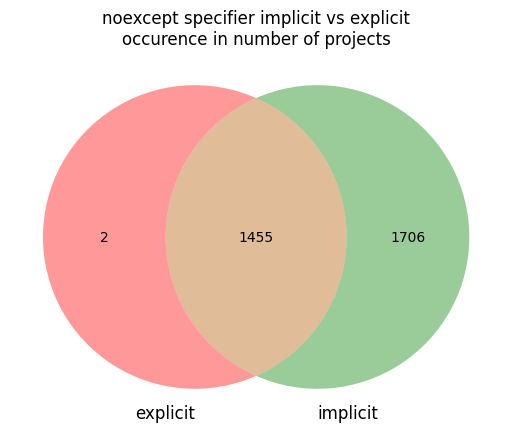

All noexcept count: defaultdict(<class 'int'>, {'total count': 4788770, 'specifier': 4786272, 'operator': 2498})
Explicit noexcept count: defaultdict(<class 'int'>, {'total count': 515310, 'specifier': 512812, 'operator': 2498})
Implicit noexcept count: defaultdict(<class 'int'>, {'total count': 4273460, 'specifier': 4273460, 'operator': 0})
Explicit noexcept appears in 1457 projects
noexcept implict and explicit appear in 3163 projects


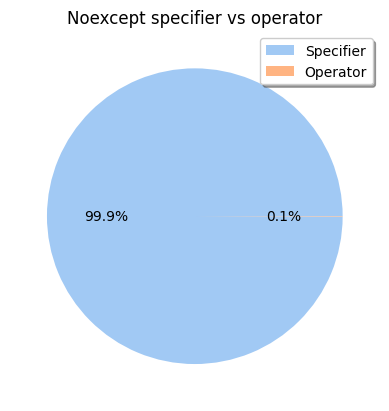

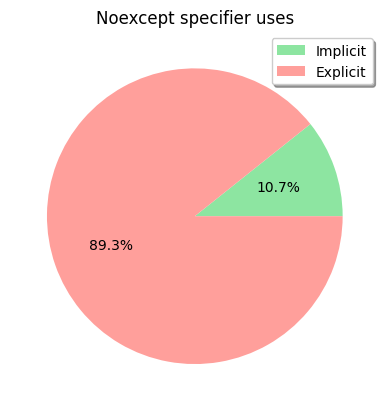

In [216]:
def plots_for_noexcept_keyword():
    explicit_count = defaultdict(int)
    implicit_count = defaultdict(int)
    all_count = defaultdict(int)

    explicit_projects_count = 0
    all_projects_count = 0

    def autopct_format(pct):
        return ('%1.1f%%' % pct) if pct > 0 else ''


    for project_name, p in stats.items():
        if p.get("overall_features", None) is not None and p['overall_features'].get('modern keywords prevalence', None) is not None and \
            p['overall_features']['modern keywords prevalence'].get("explicit noexcept", None) is not None and \
                "total count" in p['overall_features']['modern keywords prevalence']["explicit noexcept"]:
            for count_key, count_value in p['overall_features']['modern keywords prevalence']["explicit noexcept"].items():
                explicit_count[count_key] += count_value
            if p['overall_features']['modern keywords prevalence']["explicit noexcept"]["total count"] > 0:
                explicit_projects_count += 1
        if p.get("overall_features", None) is not None and p['overall_features'].get('modern keywords prevalence', None) is not None and \
            p['overall_features']['modern keywords prevalence'].get("all noexcept", None) is not None and \
                "total count" in p['overall_features']['modern keywords prevalence']["all noexcept"]:
            
            for count_key, count_value in p['overall_features']['modern keywords prevalence']["all noexcept"].items():
                all_count[count_key] += count_value
            if p['overall_features']['modern keywords prevalence']["all noexcept"]["total count"] > 0:
                all_projects_count += 1

            # all_count += p['overall_features']['modern keywords prevalence']["all default"]["total count"]
    
    # for keys in explicit_count.keys():
    #     implicit_count[keys] = all_count[keys] - explicit_count[keys]

    implicit_count['total count'] = all_count['total count'] - explicit_count['total count']
    implicit_count['specifier'] = all_count['specifier'] - explicit_count['specifier']
    implicit_count['operator'] = all_count['operator'] - explicit_count['operator']

    print(f"All noexcept count: {all_count}")
    print(f"Explicit noexcept count: {explicit_count}")
    print(f"Implicit noexcept count: {implicit_count}")

    print(f"Explicit noexcept appears in {explicit_projects_count} projects")
    print(f"noexcept implict and explicit appear in {all_projects_count} projects")

    # pie chart of specifier vs operator noexcept
    data = [all_count['specifier'], all_count['operator']]
    labels = ['Specifier', 'Operator']
    colors = sns.color_palette('pastel')[:len(data)]

    plt.pie(data, labels = None, colors = colors, autopct=autopct_format)
    # plt.legend(loc = 'upper right', labels = labels, bbox_to_anchor=(1.3, 1))
    plt.legend(loc = 'upper right', labels = labels, fancybox=True, shadow=True)
    plt.title('Noexcept specifier vs operator')
    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/Noexcept specifier vs operator.pdf", bbox_inches='tight')
    plt.show()

    # pie chart of noexcept specifier: implicit vs explicit
    data = [explicit_count['specifier'], implicit_count['specifier']]
    labels = ['Implicit', 'Explicit']
    colors = sns.color_palette('pastel')[2:2 + len(data)]

    plt.pie(data, labels = None, colors = colors, autopct=autopct_format)
    # plt.legend(loc = 'upper right', labels = labels, bbox_to_anchor=(1.3, 1))
    plt.legend(loc = 'upper right', labels = labels, fancybox=True, shadow=True)
    plt.title('Noexcept specifier uses')
    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/Noexcept specifier uses.pdf", bbox_inches='tight')
    plt.show()

    # # pie chart of noexcept operator: implicit vs explicit
    # data = [explicit_count['operator'], implicit_count['operator']]
    # labels = ['Implicit', 'Explicit']
    # colors = sns.color_palette('pastel')[4: 4 + len(data)]

    # plt.pie(data, labels = None, colors = colors, autopct=autopct_format)
    # # plt.legend(loc = 'upper right', labels = labels, bbox_to_anchor=(1.3, 1))
    # plt.legend(loc = 'upper right', labels = labels)
    # plt.title('Noexcept operator uses')
    # plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/Noexcept operator uses.png", bbox_inches='tight')
    # plt.show()

def venn_for_noexcept_keyword():
    # global venn_set
    def get_venn_noexcept_usage():
        global venn_set
        explicit_vs_implicit = [0, 0, 0, 0]
        print_flag = [False, False, False, False]

        explicit_usage_count_t = 0

        # just simple for loop
        for pname, project in stats.items():
            explicit_usage = 0
            implicit_usage = 0

            if project.get("overall_features", None) is not None and project['overall_features'].get('modern keywords prevalence', None) is not None and project['overall_features']['modern keywords prevalence'].get("explicit noexcept", None) is not None and project['overall_features']['modern keywords prevalence']['explicit noexcept'].get('total count', 0) > 0:
                explicit_usage += 1
                explicit_usage_count_t += 1
                venn_set.add(pname)

            if project.get("overall_features", None) is not None and project['overall_features'].get('modern keywords prevalence', None) is not None and project['overall_features']['modern keywords prevalence'].get("explicit default", None) is not None and project['overall_features']['modern keywords prevalence']['explicit noexcept'].get('total count', 0) < project['overall_features']['modern keywords prevalence']['all noexcept']['total count']:
                implicit_usage += 1
            
            if explicit_usage > 0 and implicit_usage > 0:
                if not print_flag[3]:
                    print_flag[3] = True
                    print(f"Project {pname} uses both explicit and implicit")
                explicit_vs_implicit[3] += 1
            elif explicit_usage > 0:
                print(f"Project {pname} uses only explicit")
                if not print_flag[2]:
                    print_flag[2] = True
                    print(f"Project {pname} uses only explicit")
                explicit_vs_implicit[2] += 1
            elif implicit_usage > 0:
                if not print_flag[1]:
                    print_flag[1] = True
                    print(f"Project {pname} uses only implicit")
                explicit_vs_implicit[1] += 1
            else:
                if not print_flag[0]:
                    print_flag[0] = True
                    print(f"Project {pname} uses neither explicit nor implicit")
                explicit_vs_implicit[0] += 1

        print(f"explicit_usage: {explicit_usage_count_t}")
        print(f"explicit_vs_implicit: {explicit_vs_implicit}")
        # [Ab, aB, AB]
        return [explicit_vs_implicit[2], explicit_vs_implicit[1], explicit_vs_implicit[3]]
        # return explicit_vs_implicit
    venn2_unweighted(subsets = get_venn_noexcept_usage(), set_labels = ("explicit", "implicit"))

    # Add labels
    plt.title('noexcept specifier implicit vs explicit\noccurence in number of projects')
    # save plot
    plt.savefig(f'{DATA_ANALYSIS_FOLDER}/plots/noexcept_implicit_vs_explicit.pdf', dpi=500, bbox_inches='tight')
    plt.show()
    # plt.show()

venn_for_noexcept_keyword()
plots_for_noexcept_keyword()

All default count: defaultdict(<class 'int'>, {'total count': 49163, 'final methods': 33123, 'final classes': 16040})
Final specifier appears in 362 projects
Project with most final specifier: (4248, 'manaplus')
[('manaplus', 4248), ('libmwaw', 2413), ('opencv', 2201), ('rumur', 2063), ('falcosecurity-libs', 1920), ('ignition-msgs', 1877), ('telegram-desktop', 1493), ('python-grpc-tools', 1479), ('mozc', 1475), ('libstaroffice', 1333)]


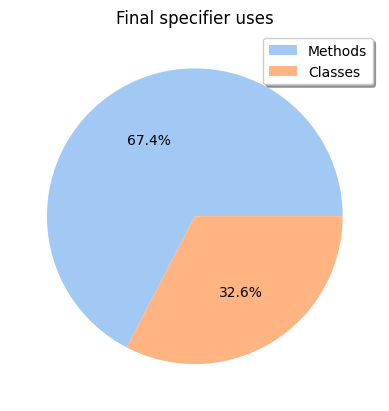

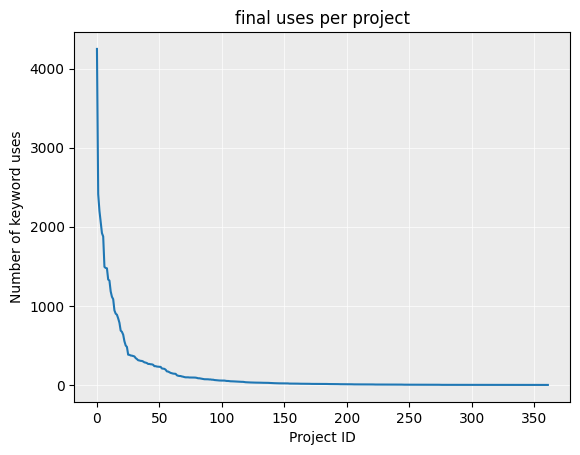

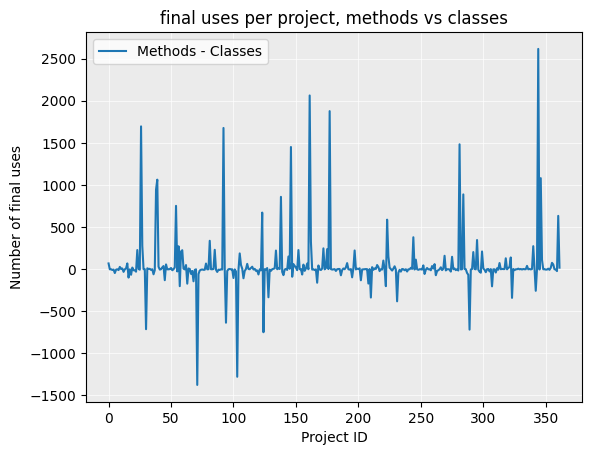

In [217]:
def plots_for_final_keyword():
    all_count = defaultdict(int)
    all_count_distinct = 0
    project_to_count = defaultdict(int)
    project_to_kind = dict()

    max_project = (0, None)

    def autopct_format(pct):
        return ('%1.1f%%' % pct) if pct > 0 else ''


    for project_name, p in stats.items():
        if p.get("overall_features", None) is not None and p['overall_features'].get('modern keywords prevalence', None) is not None and \
            p['overall_features']['modern keywords prevalence'].get("final", None) is not None and \
                "total count" in p['overall_features']['modern keywords prevalence']["final"]:
            for count_key, count_value in p['overall_features']['modern keywords prevalence']["final"].items():
                all_count[count_key] += count_value
            if p['overall_features']['modern keywords prevalence']["final"]["total count"] > max_project[0]:
                max_project = (p['overall_features']['modern keywords prevalence']["final"]["total count"], project_name)
            project_to_count[project_name] = p['overall_features']['modern keywords prevalence']["final"]["total count"]
            if p['overall_features']['modern keywords prevalence']["final"]["total count"] > 0:
                project_to_kind[project_name] = {
                    "methods": p['overall_features']['modern keywords prevalence']["final"]["final methods"],
                    "classes": p['overall_features']['modern keywords prevalence']["final"]["final classes"]
                }
                all_count_distinct += 1
        else:
            project_to_count[project_name] = 0
    
    print(f"All default count: {all_count}")
    print(f"Final specifier appears in {all_count_distinct} projects")
    print(f"Project with most final specifier: {max_project}")
    print(sorted([(k, v) for k, v in project_to_count.items() if v > 0], key=lambda x: x[1], reverse=True)[:10])

    # pie chart of method vs class final
    data = [all_count['final methods'], all_count['final classes']]
    labels = ['Methods', 'Classes']
    colors = sns.color_palette('pastel')[:len(data)]

    plt.pie(data, labels = None, colors = colors, autopct=autopct_format)
    # plt.legend(loc = 'upper right', labels = labels, bbox_to_anchor=(1.3, 1))
    plt.legend(loc = 'upper right', labels = labels, fancybox=True, shadow=True)
    plt.title('Final specifier uses')
    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/Final specifier uses.pdf", bbox_inches='tight')
    plt.show()

    # plot number of uses per project
    number_of_uses = sorted(project_to_count.values(), reverse=True)
    number_of_uses = [x for x in number_of_uses if x > 0]

    fig, ax = plt.subplots(1, 1)
    fig.patch.set_facecolor('xkcd:white')
    plt.grid(color='w', linestyle='-', linewidth=0.5, zorder = 0)
    ax.set_facecolor((0.92, 0.92, 0.92))
    plt.plot(number_of_uses, zorder = 3)

    plt.xlabel('Project ID')
    plt.ylabel('Number of keyword uses')
    plt.title('final uses per project')
    plt.savefig(f'{DATA_ANALYSIS_FOLDER}/plots/final uses.pdf', bbox_inches='tight')
    plt.show()

    # plot number of uses per project
    fig, ax = plt.subplots(1, 1)
    fig.patch.set_facecolor('xkcd:white')
    plt.grid(color='w', linestyle='-', linewidth=0.5, zorder = 0)
    ax.set_facecolor((0.92, 0.92, 0.92))

    values_list = [(v["methods"], v["classes"]) for k, v in project_to_kind.items()]
    plt.plot([x[0] - x[1] for x in values_list], zorder = 3, label='Methods - Classes')
    # plt.plot([x[0] for x in values_list], zorder = 3, label='Methods')
    # plt.plot([x[1] for x in values_list], zorder = 3, label='Classes')

    plt.xlabel('Project ID')
    plt.ylabel('Number of final uses')
    plt.title('final uses per project, methods vs classes')
    plt.legend()
    plt.savefig(f'{DATA_ANALYSIS_FOLDER}/plots/final uses methods vs classes.pdf', bbox_inches='tight')
    plt.show()

plots_for_final_keyword()

All default count: defaultdict(<class 'int'>, {'total count': 152541, 'delete constructors': 3994, 'delete member functions': 76138, 'delete functions': 3659})
Distinct projects: 1055


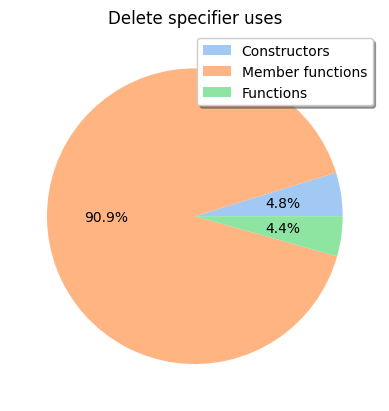

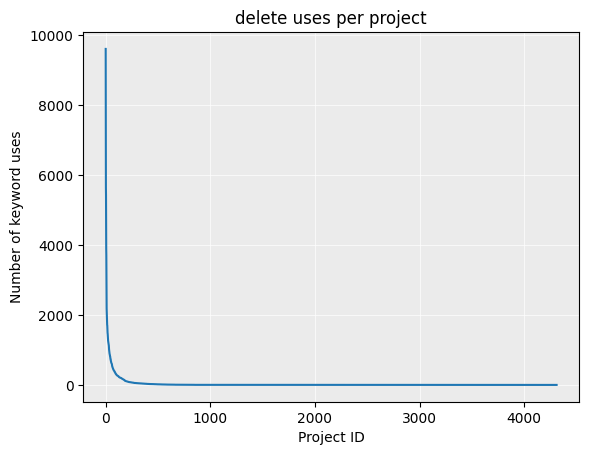

In [218]:
def plots_for_delete_keyword():
    all_count = defaultdict(int)
    all_count_distinct = 0
    project_to_count = defaultdict(int)

    def autopct_format(pct):
        return ('%1.1f%%' % pct) if pct > 0 else ''


    for project_name, p in stats.items():
        if p.get("overall_features", None) is not None and p['overall_features'].get('modern keywords prevalence', None) is not None and \
            p['overall_features']['modern keywords prevalence'].get("delete", None) is not None and \
                "total count" in p['overall_features']['modern keywords prevalence']["delete"]:
            for count_key, count_value in p['overall_features']['modern keywords prevalence']["delete"].items():
                all_count[count_key] += count_value
            project_to_count[project_name] = p['overall_features']['modern keywords prevalence']["delete"]["total count"]
            if p['overall_features']['modern keywords prevalence']["delete"]["total count"] > 0:
                all_count_distinct += 1
        else:
            project_to_count[project_name] = 0

    
    print(f"All default count: {all_count}")
    print(f"Distinct projects: {all_count_distinct}")

    # pie chart of delete: constructor vs member function vs function
    data = [all_count['delete constructors'], all_count['delete member functions'], all_count['delete functions']]
    labels = ['Constructors', 'Member functions', 'Functions']
    colors = sns.color_palette('pastel')[:len(data)]

    plt.pie(data, labels = None, colors = colors, autopct=autopct_format)
    # plt.legend(loc = 'upper right', labels = labels, bbox_to_anchor=(1.3, 1))
    plt.legend(loc = 'upper right', labels = labels, fancybox=True, shadow=True)
    plt.title('Delete specifier uses')
    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/Delete specifier uses.pdf", bbox_inches='tight')
    plt.show()

    # plot number of uses per project
    number_of_uses = sorted(project_to_count.values(), reverse=True)

    fig, ax = plt.subplots(1, 1)
    fig.patch.set_facecolor('xkcd:white')
    plt.grid(color='w', linestyle='-', linewidth=0.5, zorder = 0)
    ax.set_facecolor((0.92, 0.92, 0.92))
    plt.plot(number_of_uses, zorder = 3)

    plt.xlabel('Project ID')
    plt.ylabel('Number of keyword uses')
    plt.title('delete uses per project')
    plt.savefig(f'{DATA_ANALYSIS_FOLDER}/plots/delete uses.pdf', bbox_inches='tight')
    plt.show()

plots_for_delete_keyword()

All default count: defaultdict(<class 'int'>, {'contain override keyword': 703578, 'total count': 703578, 'number of functions that override': 1840945})
All count only explicit: defaultdict(<class 'int'>, {'contain override keyword': 703578, 'total count': 703578, 'number of functions that override': 1401560})
Distinct projects where override appears explicitly: 1371
Distinct projects where functions are overridden: 2556
max override project: (14474, 'ns3')


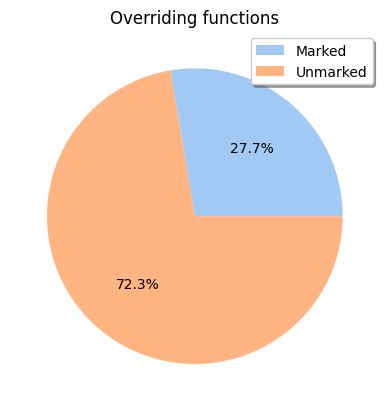

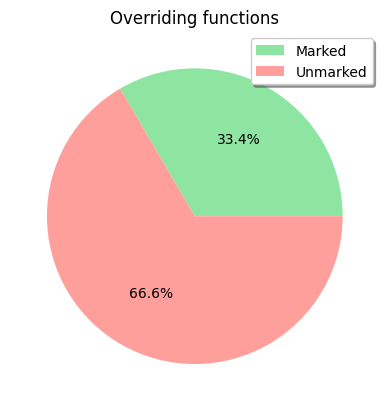

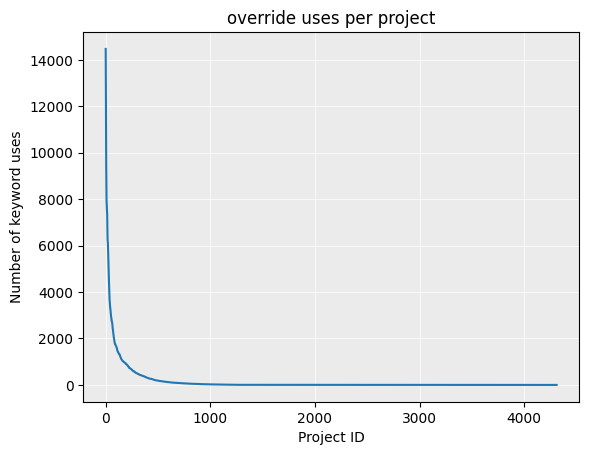

In [219]:
def plots_for_override_keyword():
    all_count = defaultdict(int)
    all_count_distinct = 0
    all_count_distinct_any = 0
    project_to_count = defaultdict(int)
    all_count_only_explicit = defaultdict(int)

    max_override_project = (0, None)

    def autopct_format(pct):
        return ('%1.1f%%' % pct) if pct > 0 else ''


    for project_name, p in stats.items():
        if p.get("overall_features", None) is not None and p['overall_features'].get('modern keywords prevalence', None) is not None and \
            p['overall_features']['modern keywords prevalence'].get("override", None) is not None and \
                "total count" in p['overall_features']['modern keywords prevalence']["override"]:
            project_to_count[project_name] = p['overall_features']['modern keywords prevalence']["override"]["contain override keyword"]
            for count_key, count_value in p['overall_features']['modern keywords prevalence']["override"].items():
                all_count[count_key] += count_value
            if p['overall_features']['modern keywords prevalence']["override"]["total count"] > max_override_project[0]:
                max_override_project = (p['overall_features']['modern keywords prevalence']["override"]["total count"], project_name)
            if p['overall_features']['modern keywords prevalence']["override"]["total count"] > 0:
                all_count_distinct += 1
                for count_key, count_value in p['overall_features']['modern keywords prevalence']["override"].items():
                    all_count_only_explicit[count_key] += count_value
            if p['overall_features']['modern keywords prevalence']["override"]["number of functions that override"] > 0:
                all_count_distinct_any += 1
        else:
            project_to_count[project_name] = 0
    
    print(f"All default count: {all_count}")
    print(f"All count only explicit: {all_count_only_explicit}")
    print(f"Distinct projects where override appears explicitly: {all_count_distinct}")
    print(f"Distinct projects where functions are overridden: {all_count_distinct_any}")
    print(f"max override project: {max_override_project}")

    # pie chart of "Overriding functions, marked vs unmarked"
    data = [all_count['total count'], all_count['number of functions that override']]
    labels = ['Marked', 'Unmarked']
    colors = sns.color_palette('pastel')[:len(data)]

    plt.pie(data, labels = None, colors = colors, autopct=autopct_format)
    # plt.legend(loc = 'upper right', labels = labels, bbox_to_anchor=(1.3, 1))
    plt.legend(loc = 'upper right', labels = labels, fancybox=True, shadow=True)
    plt.title('Overriding functions')
    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/Overriding functions.pdf", bbox_inches='tight')
    plt.show()

    # pie chart of "Overriding functions, marked vs unmarked" for projects that have at least 1 marked
    data = [all_count_only_explicit['total count'], all_count_only_explicit['number of functions that override']]
    labels = ['Marked', 'Unmarked']
    colors = sns.color_palette('pastel')[2:2 + len(data)]

    plt.pie(data, labels = None, colors = colors, autopct=autopct_format)
    # plt.legend(loc = 'upper right', labels = labels, bbox_to_anchor=(1.3, 1))
    plt.legend(loc = 'upper right', labels = labels, fancybox=True, shadow=True)
    plt.title('Overriding functions')
    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/Overriding functions at least 1 explicit.pdf", bbox_inches='tight')
    plt.show()

    # plot number of uses per project
    number_of_uses = sorted(project_to_count.values(), reverse=True)

    fig, ax = plt.subplots(1, 1)
    fig.patch.set_facecolor('xkcd:white')
    plt.grid(color='w', linestyle='-', linewidth=0.5, zorder = 0)
    ax.set_facecolor((0.92, 0.92, 0.92))
    plt.plot(number_of_uses, zorder = 3)

    plt.xlabel('Project ID')
    plt.ylabel('Number of keyword uses')
    plt.title('override uses per project')
    plt.savefig(f'{DATA_ANALYSIS_FOLDER}/plots/override uses.pdf', bbox_inches='tight')
    plt.show()

plots_for_override_keyword()

All default count: defaultdict(<class 'int'>, {'nullptr': 1514685, 'static_assert': 90507, 'inline namespace': 2177})
All default distinct count: defaultdict(<class 'int'>, {'nullptr': 1901, 'static_assert': 714, 'inline namespace': 57})
Max nullptr: (44402, 'gdal')


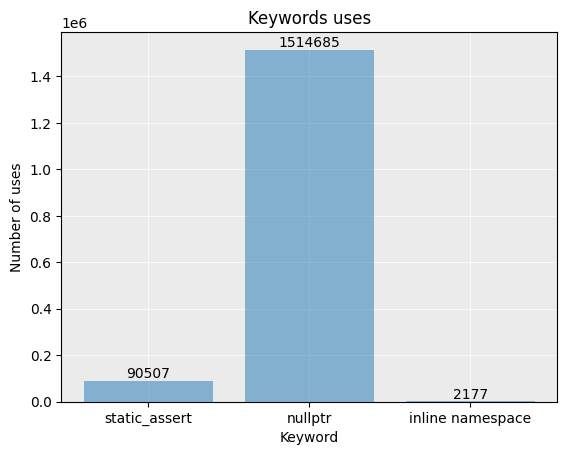

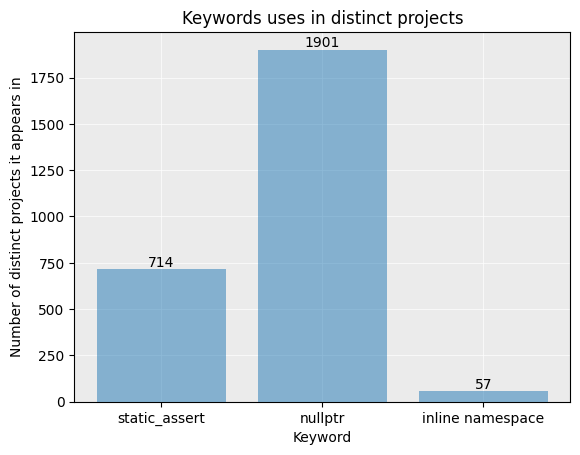

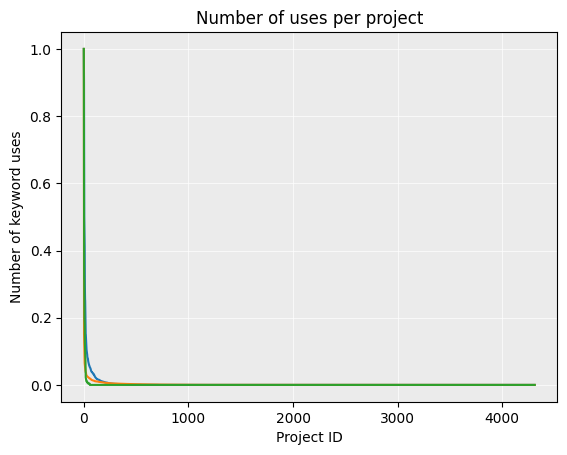

In [247]:
def plots_for_staticassert_nullptr_inlinenamespace_keyword():
    # bar chart of their uses
    all_count = defaultdict(int)
    all_count_distinct = defaultdict(int)

    project_to_count = {"static_assert": defaultdict(int), "nullptr": defaultdict(int), "inline namespace": defaultdict(int)}

    max_null_ptr = (0, None)

    for project_name, p in stats.items():
        if p.get("overall_features", None) is not None and p['overall_features'].get('modern keywords prevalence', None) is not None and \
            p['overall_features']['modern keywords prevalence'].get("static_assert", None) is not None and \
                p['overall_features']['modern keywords prevalence']["static_assert"].get("total count", 0) > 0:
            all_count['static_assert'] += p['overall_features']['modern keywords prevalence']["static_assert"]["total count"]
            all_count_distinct['static_assert'] += 1
            project_to_count["static_assert"][project_name] = p['overall_features']['modern keywords prevalence']["static_assert"]["total count"]
        else:
            project_to_count["static_assert"][project_name] = 0

        if p.get("overall_features", None) is not None and p['overall_features'].get('modern keywords prevalence', None) is not None and \
            p['overall_features']['modern keywords prevalence'].get("nullptr", None) is not None and \
                p['overall_features']['modern keywords prevalence']["nullptr"].get("total count", 0) > 0:
            all_count['nullptr'] += p['overall_features']['modern keywords prevalence']["nullptr"]["total count"]
            all_count_distinct['nullptr'] += 1
            project_to_count["nullptr"][project_name] = p['overall_features']['modern keywords prevalence']["nullptr"]["total count"]

            if p['overall_features']['modern keywords prevalence']["nullptr"]["total count"] > max_null_ptr[0] and project_name != "praat":
                max_null_ptr = (p['overall_features']['modern keywords prevalence']["nullptr"]["total count"], project_name)
        else:
            project_to_count["nullptr"][project_name] = 0

        if p.get("overall_features", None) is not None and p['overall_features'].get('modern keywords prevalence', None) is not None and \
            p['overall_features']['modern keywords prevalence'].get("inline namespace", None) is not None and \
                p['overall_features']['modern keywords prevalence']["inline namespace"].get("total count", 0) > 0:
            all_count['inline namespace'] += p['overall_features']['modern keywords prevalence']["inline namespace"]["total count"]
            all_count_distinct['inline namespace'] += 1
            project_to_count["inline namespace"][project_name] = p['overall_features']['modern keywords prevalence']["inline namespace"]["total count"]
        else:
            project_to_count["inline namespace"][project_name] = 0        
        
    print(f"All default count: {all_count}")
    print(f"All default distinct count: {all_count_distinct}")
    print(f"Max nullptr: {max_null_ptr}")

    # bar plot with absolute number of appearances
    x_axis = ["static_assert", "nullptr", "inline namespace"]
    y_axis = [all_count['static_assert'], all_count['nullptr'], all_count['inline namespace']]
    fig, ax = plt.subplots(1, 1)
    fig.patch.set_facecolor('xkcd:white')
    plt.grid(color='w', linestyle='-', linewidth=0.5, zorder=0)
    ax.set_facecolor((0.92, 0.92, 0.92))
    plt.bar(x_axis, y_axis, align='center', alpha=0.5, zorder=3)
    plt.xlabel('Keyword')
    plt.ylabel('Number of uses')
    plt.title(f'Keywords uses')
    plt.xticks(x_axis, rotation=90 if len(x_axis) > 6 else 0)

    max_value = max([value for value in y_axis])
    for i, value in enumerate(y_axis):
        plt.text(i, value + 0.008 * max_value, str(value), ha='center')
    
    # plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/static_assert nullptr inlinenamespace.pdf", bbox_inches='tight')
    plt.show()

    # bar plot with distinct number of projects the keyword appears in
    x_axis = ["static_assert", "nullptr", "inline namespace"]
    y_axis = [all_count_distinct['static_assert'], all_count_distinct['nullptr'], all_count_distinct['inline namespace']]
    fig, ax = plt.subplots(1, 1)
    fig.patch.set_facecolor('xkcd:white')
    plt.grid(color='w', linestyle='-', linewidth=0.5, zorder=0)
    ax.set_facecolor((0.92, 0.92, 0.92))
    plt.bar(x_axis, y_axis, align='center', alpha=0.5, zorder=3)
    plt.xlabel('Keyword')
    plt.ylabel('Number of distinct projects it appears in')
    plt.title(f'Keywords uses in distinct projects')
    plt.xticks(x_axis, rotation=90 if len(x_axis) > 6 else 0)

    max_value = max([value for value in y_axis])
    for i, value in enumerate(y_axis):
        plt.text(i, value + 0.008 * max_value, str(value), ha='center')
    
    # plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/static_assert nullptr inlinenamespace distinct projects.pdf", bbox_inches='tight')
    plt.show()

    # plot number of uses per project
    number_of_uses = dict()
    number_of_uses["static_assert"] = sorted(project_to_count["static_assert"].values(), reverse=True)
    number_of_uses["static_assert"] = [x / max(number_of_uses["static_assert"]) for x in number_of_uses["static_assert"]]
    number_of_uses["nullptr"] = sorted(project_to_count["nullptr"].values(), reverse=True)
    number_of_uses["nullptr"] = [x / max(number_of_uses["nullptr"]) for x in number_of_uses["nullptr"]]
    number_of_uses["inline namespace"] = sorted(project_to_count["inline namespace"].values(), reverse=True)
    number_of_uses["inline namespace"] = [x / max(number_of_uses["inline namespace"]) for x in number_of_uses["inline namespace"]]

    fig, ax = plt.subplots(1, 1)
    fig.patch.set_facecolor('xkcd:white')
    plt.grid(color='w', linestyle='-', linewidth=0.5, zorder = 0)
    ax.set_facecolor((0.92, 0.92, 0.92))
    plt.plot(number_of_uses["static_assert"], zorder = 3)
    plt.plot(number_of_uses["nullptr"], zorder = 3)
    plt.plot(number_of_uses["inline namespace"], zorder = 3)

    plt.xlabel('Project ID')
    plt.ylabel('Number of keyword uses')
    plt.title('Number of uses per project')
    plt.savefig(f'{DATA_ANALYSIS_FOLDER}/plots/static_assert uses.pdf', bbox_inches='tight')
    plt.show()

plots_for_staticassert_nullptr_inlinenamespace_keyword()

All count: 2335
All distinct count: 231
Data types count:
intptr_t: 2
char[100]: 3
int: 155
uint64_t: 4
size_t: 24
unsigned int: 20
const size_t: 4
char[512]: 2
char[16384]: 4
char[4096]: 5
char[5120]: 3
char *: 21
char[500]: 5
void *: 16
char[256]: 6
long: 81
uint32_t: 3
quint32: 1
char *[100]: 2
char[1024]: 9
int32_t: 2
__int_type: 1
char[8192]: 2
long long: 2
pid_t: 5
const char *: 16
float: 4
flint_cleanup_function_t *: 1
double *[64]: 2
double: 69
unsigned long: 8
volatile uint32: 6
int[4]: 1
char[11]: 1
ze_bool_t: 2
uint8_t[16]: 1
int64_t: 8
char[64]: 7
char[32]: 6
char[16]: 2
char[128]: 3
char[27]: 1
char[32][256]: 1
char[2][64]: 1
char[4][256]: 2
char[16][32]: 1
char[530]: 1
char[513]: 2
wchar_t *: 1
intmax_t: 1
uint32_t[624]: 1
char[1000]: 1
integer[4]: 2
integer: 74
char[2]: 1
int **: 1
int *: 7
double *: 4
double[36]: 1
igraph_integer_t: 3
char[2096]: 2
char[46]: 2
char[37]: 1
char[2049]: 1
char[25]: 1
size_t[256]: 3
long[256]: 3
char[200]: 1
size_t[5]: 1
simple data types: 

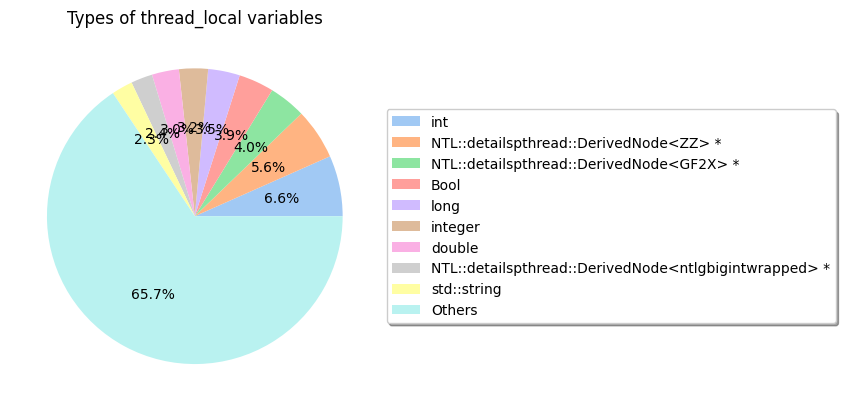

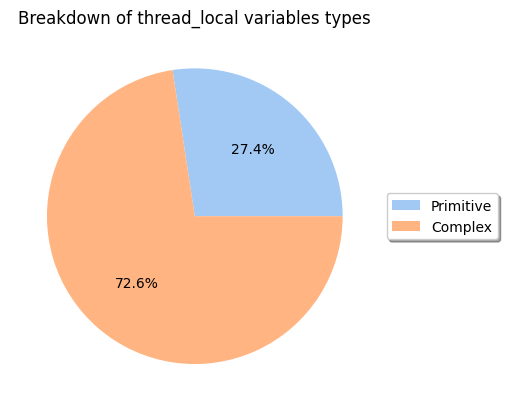

In [214]:
def plots_for_threadlocal_keyword():
    # bar chart of their uses
    all_count = 0
    all_count_distinct = 0
    data_types = defaultdict(int)

    for project_name, p in stats.items():
        if p.get("overall_features", None) is not None and p['overall_features'].get('modern keywords prevalence', None) is not None and \
            p['overall_features']['modern keywords prevalence'].get("thread_local", None) is not None:
            all_count += p['overall_features']['modern keywords prevalence']["thread_local"]["total count"]
            if p['overall_features']['modern keywords prevalence']["thread_local"]["total count"] > 0:
                all_count_distinct += 1
            for data_type, count in p['overall_features']['modern keywords prevalence']["thread_local"]["data types"].items():
                data_types[data_type] += count

    print(f"All count: {all_count}")
    print(f"All distinct count: {all_count_distinct}")
    print(f"Data types count:")
    # for k, v in sorted(data_types.items(), key = lambda x: x[1], reverse = True):
    #     print(f"{k}: {v}")

    simple_data_types = 0
    for (k, v) in data_types.items():
        if "::" in k or "<" in k or ">" in k or "real" in k or "interrupt" in k or "print" in k or "P" in k or "pointer" in k or "(" in k or ")" in k:
            continue
        if 'int' in k or 'size_t' in k or 'char' in k or 'long' in k or 'short' in k or "pid_t" in k or 'double' in k or 'float' in k or 'bool' in k or 'void' in k:
            print(f"{k}: {v}")
            simple_data_types += v
    
    print(f"simple data types: {simple_data_types}")
    print(f"rest data types: {all_count - simple_data_types}")

    def autopct_format(pct):
        return ('%1.1f%%' % pct) if pct > 0 else ''
    
    print(f"All default count: {all_count}")

    # pie chart of "Overriding functions, marked vs unmarked"
    len_data_types = 9
    sorted_data_types = sorted(data_types.items(), key = lambda x: x[1], reverse = True)

    data = [x[1] for x in sorted_data_types[:len_data_types]]
    data.append(all_count - sum(data))
    labels = [x[0] for x in sorted_data_types[:len_data_types]] + ['Others']
    labels = [x.replace("_", "") for x in labels]
    colors = sns.color_palette('pastel')[:len(data)]

    plt.pie(data, labels = None, colors = colors, autopct=autopct_format)
    # plt.legend(loc = 'upper right', labels = labels, bbox_to_anchor=(1, -2))
    plt.legend(labels, loc="center left", bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True, ncol=1)
    plt.subplots_adjust(right=0.75)
    # plt.legend(loc = 'upper right', labels = labels)
    plt.title('Types of thread_local variables')
    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/threadlocal data types.pdf", bbox_inches='tight')
    plt.show()

    data = [simple_data_types, all_count - simple_data_types]
    labels = ['Primitive', 'Complex']
    colors = sns.color_palette('pastel')[:len(data)]

    plt.pie(data, labels = None, colors = colors, autopct=autopct_format)
    # plt.legend(loc = 'upper right', labels = labels, bbox_to_anchor=(1, -2))
    plt.legend(labels, loc="center left", bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True, ncol=1)
    plt.subplots_adjust(right=0.75)
    # plt.legend(loc = 'upper right', labels = labels)
    plt.title('Breakdown of thread_local variables types')
    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/threadlocal data types primitive vs complex.pdf", bbox_inches='tight')
    plt.show()

plots_for_threadlocal_keyword()

All alignas count: 14236
Distinct alignas count: 330
Alignas value count:
0,613
1,774
2,93
4,507
8,2137
16,5942
32,2566
64,1374
128,116
256,84
512,6
1024,3
2048,3
4096,14
8192,4
All alignof count: 1589
Distinct alignof count: 147
Alignof value count:
0,349
1,120
2,50
4,165
8,584
16,230
32,18
64,14
128,58
4096,1


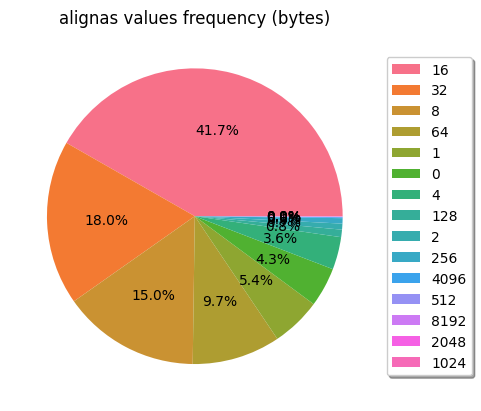

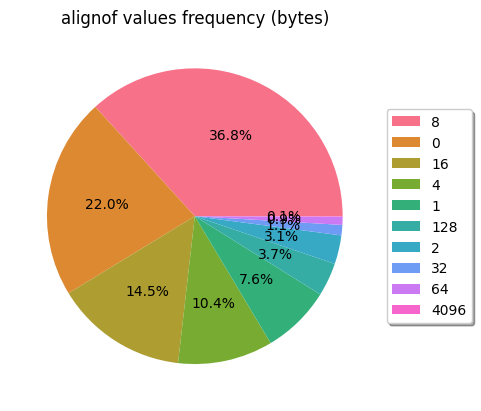

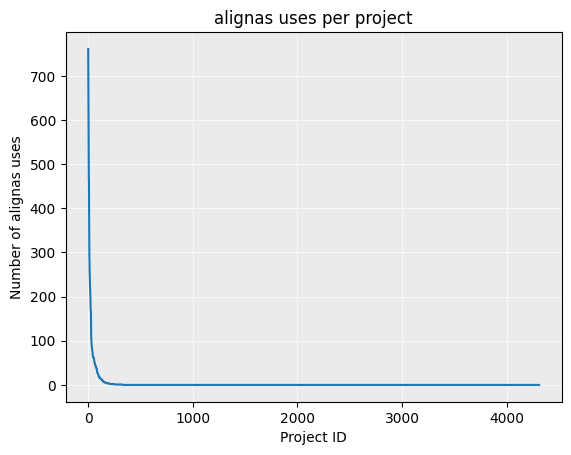

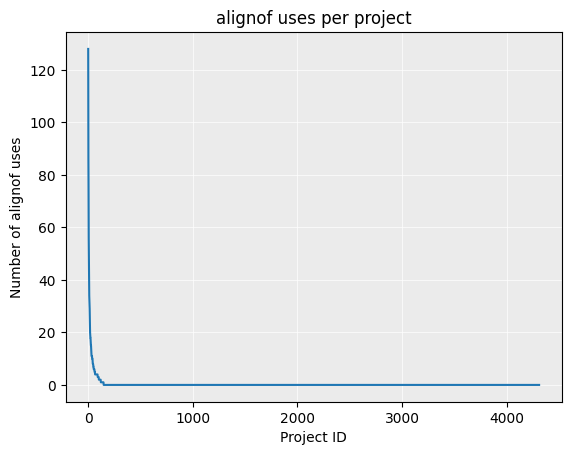

In [207]:
def plots_for_align_keyword():
    alignas_count = 0
    alignas_count_distinct = 0
    alignas_value_count = defaultdict(int)

    alignof_count = 0
    alignof_count_distinct = 0
    alignof_value_count = defaultdict(int)

    project_to_count = {"alignas": defaultdict(int), "alignof": defaultdict(int)}

    def autopct_format(pct):
        return ('%1.1f%%' % pct) if pct > 0 else ''


    for project_name, p in stats.items():
        if p.get("overall_features", None) is not None and p['overall_features'].get('modern keywords prevalence', None) is not None and \
            p['overall_features']['modern keywords prevalence'].get("alignas", None) is not None and \
                "total count" in p['overall_features']['modern keywords prevalence']["alignas"]:

            project_to_count['alignas'][project_name] = p['overall_features']['modern keywords prevalence']["alignas"]["total count"]
            alignas_count += p['overall_features']['modern keywords prevalence']["alignas"]["total count"]
            for count_key, count_value in p['overall_features']['modern keywords prevalence']["alignas"]["values to count"].items():
                alignas_value_count[count_key] += count_value
            if p['overall_features']['modern keywords prevalence']["alignas"]["total count"] > 0:
                alignas_count_distinct += 1
        else:
            project_to_count['alignas'][project_name] = 0

        if p.get("overall_features", None) is not None and p['overall_features'].get('modern keywords prevalence', None) is not None and \
            p['overall_features']['modern keywords prevalence'].get("alignof", None) is not None and \
                "total count" in p['overall_features']['modern keywords prevalence']["alignof"]:

            project_to_count['alignof'][project_name] = p['overall_features']['modern keywords prevalence']["alignof"]["total count"]
            alignof_count += p['overall_features']['modern keywords prevalence']["alignof"]["total count"]
            for count_key, count_value in p['overall_features']['modern keywords prevalence']["alignof"]["values to count"].items():
                alignof_value_count[count_key] += count_value
            if p['overall_features']['modern keywords prevalence']["alignof"]["total count"] > 0:
                alignof_count_distinct += 1
        else:
            project_to_count['alignof'][project_name] = 0
    
    print(f"All alignas count: {alignas_count}")
    print(f"Distinct alignas count: {alignas_count_distinct}")
    print(f"Alignas value count:")
    for (k, v) in sorted(alignas_value_count.items(), key = lambda x: int(x[0])):
        print(f"{k},{v}")

    print(f"All alignof count: {alignof_count}")
    print(f"Distinct alignof count: {alignof_count_distinct}")
    print(f"Alignof value count:")
    for (k, v) in sorted(alignof_value_count.items(), key = lambda x: int(x[0])):
        print(f"{k},{v}")

    # pie chart of alignas value count
    alignas_values_list = sorted(alignas_value_count.items(), key = lambda x: x[1], reverse = True)
    data = [x[1] for x in alignas_values_list]
    labels = [x[0] for x in alignas_values_list]
    colors = sns.color_palette('husl', n_colors=len(data))

    plt.pie(data, labels = None, colors = colors, autopct=autopct_format)
    plt.legend(loc = 'center left', labels = labels, bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
    plt.subplots_adjust(right=0.75)
    # plt.legend(loc = 'upper right', labels = labels)
    plt.title('alignas values frequency (bytes)')
    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/alignas value frequency.pdf", bbox_inches='tight')
    plt.show()

    # pie chart of alignof value count
    alignof_values_list = sorted(alignof_value_count.items(), key = lambda x: x[1], reverse = True)
    data = [x[1] for x in alignof_values_list]
    labels = [x[0] for x in alignof_values_list]
    colors = sns.color_palette('husl', n_colors= len(data))

    plt.pie(data, labels = None, colors = colors, autopct=autopct_format)
    plt.legend(loc = 'center left', labels = labels, bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
    plt.subplots_adjust(right=0.75)
    # plt.legend(loc = 'upper right', labels = labels)
    plt.title('alignof values frequency (bytes)')
    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/alignof value frequency.pdf", bbox_inches='tight')
    plt.show()

    # plot number of uses per project for alignas
    number_of_uses = sorted(project_to_count["alignas"].values(), reverse=True)

    fig, ax = plt.subplots(1, 1)
    fig.patch.set_facecolor('xkcd:white')
    plt.grid(color='w', linestyle='-', linewidth=0.5, zorder = 0)
    ax.set_facecolor((0.92, 0.92, 0.92))
    plt.plot(number_of_uses, zorder = 3)

    plt.xlabel('Project ID')
    plt.ylabel('Number of alignas uses')
    plt.title('alignas uses per project')
    plt.savefig(f'{DATA_ANALYSIS_FOLDER}/plots/alignas uses.pdf', dpi=500, bbox_inches='tight')
    plt.show()

    # plot number of uses per project for alignof
    number_of_uses = sorted(project_to_count["alignof"].values(), reverse=True)

    fig, ax = plt.subplots(1, 1)
    fig.patch.set_facecolor('xkcd:white')
    plt.grid(color='w', linestyle='-', linewidth=0.5, zorder = 0)
    ax.set_facecolor((0.92, 0.92, 0.92))
    plt.plot(number_of_uses, zorder = 3)

    plt.xlabel('Project ID')
    plt.ylabel('Number of alignof uses')
    plt.title('alignof uses per project')
    plt.savefig(f'{DATA_ANALYSIS_FOLDER}/plots/alignof uses.pdf', dpi=500, bbox_inches='tight')
    plt.show()

plots_for_align_keyword()

In [140]:
k = "threading::struct gcc_internal::ThreadDataPlaceholder"
if "int" in k:
    print("yes")
print(k.find("int"))

yes
22


In [141]:
# PROJECT_PATH = f"{FEATURES_FOLDER}/quantlib"

# overall_stats = dict()

# feature_files = glob.iglob(join(PROJECT_PATH, '**/*.ast.json'), recursive=True)
# global_locations = set()
# override_count = 0

# for file in feature_files:
#     with open(file, "r") as fin:
#         content = json.load(fin)

#     for override_app in content["mka"]["override"]:
#         if not override_app['isOverride']:
#             continue
#         location = override_app['GlobalLocation']
#         # if 'Spelling' not in location:
#         #     location = os.path.normpath(location)
#         if location not in global_locations:
#             global_locations.add(location)
#     override_count += len(content["mka"]["override"])

# print(override_count, len(global_locations))

# print([x for x in global_locations if not x.startswith('/')])

In [142]:
def normalize_global_locations():
    # Sample function to apply (e.g., convert to uppercase)
    def modify_value(value):
        return value.upper()

    # Recursive function to process the JSON object
    def process_json(obj):
        if isinstance(obj, dict):
            # Go through key-value pairs
            for key, value in obj.items():
                if key == "GlobalLocation" and isinstance(value, str):
                    # Apply the modification function to the value
                    obj[key] = modify_value(value)
                else:
                    # Recursively process dictionaries or lists
                    process_json(value)
        elif isinstance(obj, list):
            # If it's a list, recursively process each element
            for item in obj:
                process_json(item)

In [143]:
# def get_possible_duplicates(keyword):
#     path_variations = dict()

#     for file, features in files_map.items():
#         if features.get("mka", None) is None:
#             continue
#         for apps in features["mka"][keyword]:
#             normalized_path = os.path.normpath(apps["GlobalLocation"].split(' ')[0])

#             pretty_path = ""

#             if " <Spelling=" in apps["GlobalLocation"]:
#                 spelling_path = apps["GlobalLocation"].split(" <Spelling=")[1][1:-1] # remove the last character which is a >

#                 normalized_spelling_path = os.path.normpath(spelling_path)

#                 pretty_path = f"{normalized_path} <Spelling={normalized_spelling_path}>"
#             else:
#                 pretty_path = normalized_path

#             if pretty_path not in path_variations:
#                 path_variations[pretty_path] = set()
#             path_variations[pretty_path].add(apps["GlobalLocation"])
    
#     total_count = 0
#     for path, variations in path_variations.items():
#         total_count += len(variations)
#         if len(variations) > 1 and " <Spelling=" in path:
#             print(f"Path: {path}")
#             for var in variations:
#                 print(f"  {var}")
#     print(f"total_count2 = {total_count}")

# get_possible_duplicates("default")

In [144]:
# def count_without_path_duplicates(keyword):
#     global files_map2
#     visited = set()
#     total_count = 0

#     files_map2 = copy.deepcopy(files_map)

#     for file, features in files_map.items():
#         if features.get("mka", None) is None:
#             continue
#         for i, apps in enumerate(features["mka"][keyword]):
#             normalized_path = os.path.normpath(apps["GlobalLocation"].split(' ')[0])

#             pretty_path = ""

#             if " <Spelling=" in apps["GlobalLocation"]:
#                 spelling_path = apps["GlobalLocation"].split(" <Spelling=")[1][1:-1] # remove the last character which is a >

#                 normalized_spelling_path = os.path.normpath(spelling_path)

#                 pretty_path = f"{normalized_path} <Spelling={normalized_spelling_path}>"
#             else:
#                 pretty_path = normalized_path

#             # normalized_path_with_spelling = ' '.join([normalized_path] + apps["GlobalLocation"].split(' ')[1:])
#             files_map2[file]["mka"][keyword][i]["GlobalLocation"] = pretty_path

#             if pretty_path not in visited:
#                 visited.add(pretty_path)
#                 total_count += 1
    
#     print(f"Total {keyword} count: {total_count}")

# count_without_path_duplicates("default")

In [145]:
# def get_possible_duplicates(keyword):
#     path_variations = dict()

#     for file, features in files_map2.items():
#         if features.get("mka", None) is None:
#             continue
#         for apps in features["mka"][keyword]:
#             normalized_path = os.path.normpath(apps["GlobalLocation"].split(' ')[0])

#             pretty_path = ""

#             if " <Spelling=" in apps["GlobalLocation"]:
#                 spelling_path = apps["GlobalLocation"].split(" <Spelling=")[1][1:-1] # remove the last character which is a >

#                 normalized_spelling_path = os.path.normpath(spelling_path)

#                 pretty_path = f"{normalized_path} <Spelling={normalized_spelling_path}>"
#             else:
#                 pretty_path = normalized_path

#             if pretty_path not in path_variations:
#                 path_variations[pretty_path] = set()
#             path_variations[pretty_path].add(apps["GlobalLocation"])
    
#     for path, variations in path_variations.items():
#         if len(variations) > 1:
#             print(f"Path: {path}")
#             for var in variations:
#                 print(f"  {var}")

# get_possible_duplicates("default")

In [146]:
sloc_info['paraview']

3171290

In [147]:
stats['praat']['overall_features']['modern keywords prevalence']['nullptr']

{'total count': 227191}

Total async count: 221
Distinct async count: 62
Total atomic count: 5486
Distinct atomic count: 311
Total promise count: 319
Distinct promise count: 39
Total future count: 620
Distinct future count: 80
Total thread count: 5925
Distinct thread count: 329
Thread types count:
total count: 5925
as variable declarations: 4660
as temporary expressions: 631
as new pointer expressions: 501
as function return types: 133


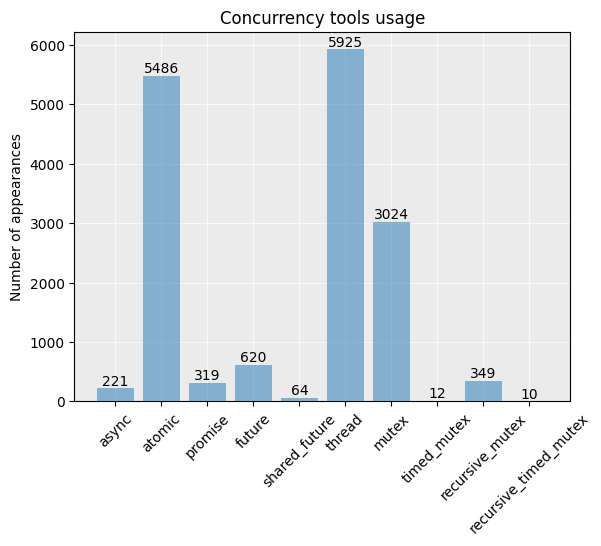

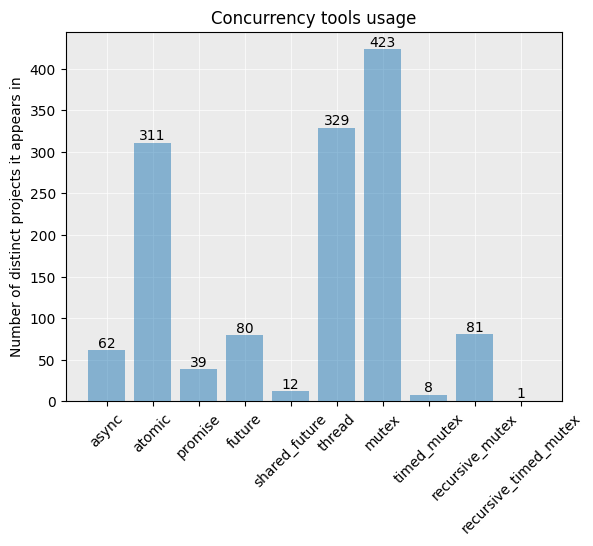

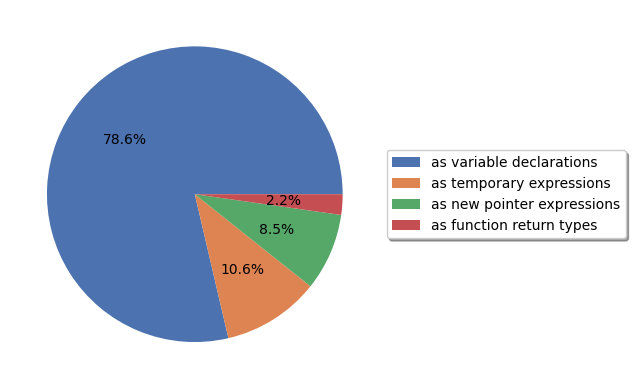

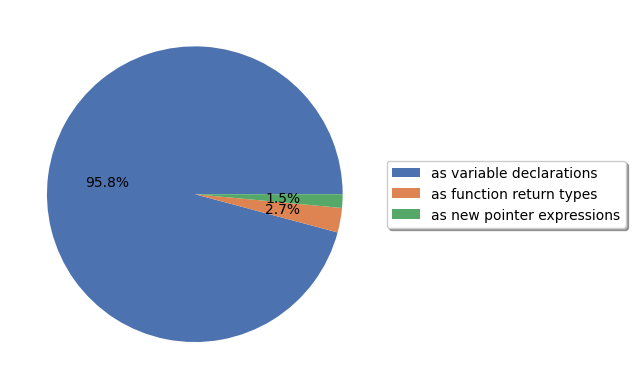

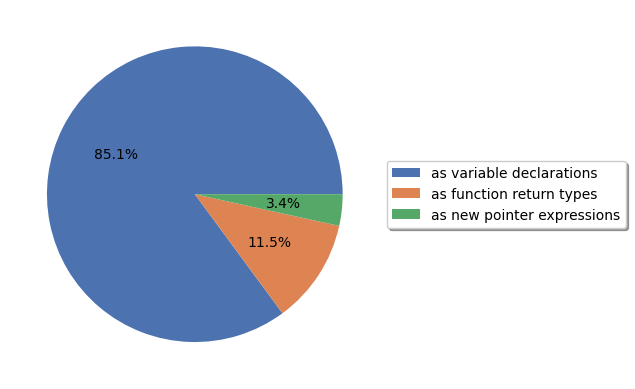

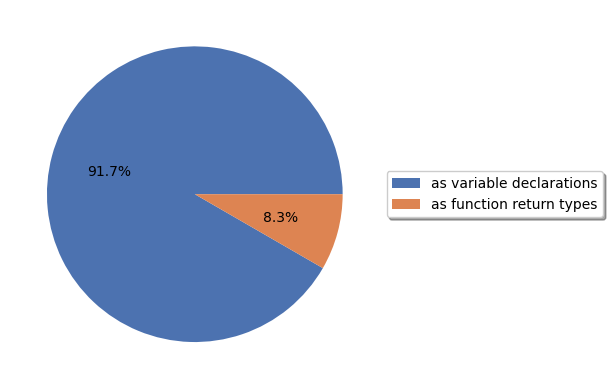

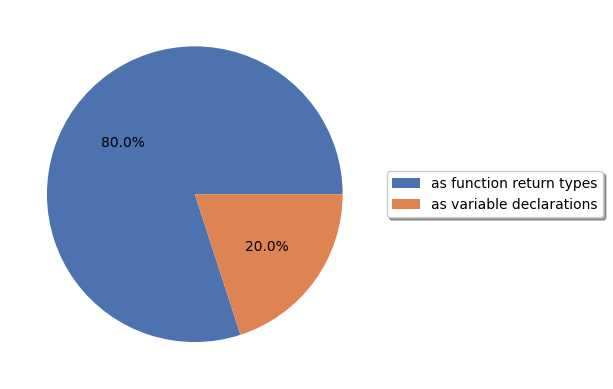

In [246]:
def plot_async_tools():
    def autopct_format(pct):
        return ('%1.1f%%' % pct) if pct > 0 else ''
        
    async_count = 0
    async_count_distinct = 0

    for pname, p in stats.items():
        if p.get("overall_features", None) is not None and p['overall_features'].get(f'async usage', None) is not None and \
            p['overall_features'][f'async usage'].get('tia templated func uses', None) is not None and \
                p['overall_features'][f'async usage']['tia templated func uses'].get(f"std::async", 0) > 0:
            async_count += p['overall_features']['async usage']["tia templated func uses"]["std::async"]
            async_count_distinct += 1
        if p.get("overall_features", None) is not None and p['overall_features'].get(f'async usage', None) is not None and \
            p['overall_features'][f'async usage'].get('tia explicit func insts', None) is not None and \
                p['overall_features'][f'async usage']['tia explicit func insts'].get(f"std::async", 0) > 0:
            async_count += p['overall_features']['async usage']["tia explicit func insts"]["std::async"]
            async_count_distinct += 1

    print(f"Total async count: {async_count}")
    print(f"Distinct async count: {async_count_distinct}")

    atomic_count = 0
    atomic_count_distinct = 0

    for pname, p in stats.items():
        if p.get("overall_features", None) is not None and p['overall_features'].get(f'atomic usage', None) is not None and \
            p['overall_features'][f'atomic usage'].get('tia templated class uses', None) is not None and \
                p['overall_features'][f'atomic usage']['tia templated class uses'].get(f"std::atomic", 0) > 0:
            atomic_count += p['overall_features']['atomic usage']["tia templated class uses"]["std::atomic"]
            atomic_count_distinct += 1
        if p.get("overall_features", None) is not None and p['overall_features'].get(f'atomic usage', None) is not None and \
            p['overall_features'][f'atomic usage'].get('tia explicit class insts', None) is not None and \
                p['overall_features'][f'atomic usage']['tia explicit class insts'].get(f"std::atomic", 0) > 0:
            atomic_count += p['overall_features']['atomic usage']["tia explicit class insts"]["std::atomic"]
            atomic_count_distinct += 1

    print(f"Total atomic count: {atomic_count}")
    print(f"Distinct atomic count: {atomic_count_distinct}")

    promise_count = 0
    promise_count_distinct = 0
    future_count = 0
    future_count_distinct = 0
    shared_future_count = 0
    shared_future_count_distinct = 0

    for pname, p in stats.items():
        if p.get("overall_features", None) is not None and p['overall_features'].get(f'promise, future usage', None) is not None and \
            p['overall_features'][f'promise, future usage'].get('tia templated class uses', None) is not None and \
                p['overall_features'][f'promise, future usage']['tia templated class uses'].get(f"std::promise", 0) > 0:
            promise_count += p['overall_features']['promise, future usage']["tia templated class uses"]["std::promise"]
            promise_count_distinct += 1
        if p.get("overall_features", None) is not None and p['overall_features'].get(f'promise, future usage', None) is not None and \
            p['overall_features'][f'promise, future usage'].get('tia explicit class insts', None) is not None and \
                p['overall_features'][f'promise, future usage']['tia explicit class insts'].get(f"std::promise", 0) > 0:
            promise_count += p['overall_features']['promise, future usage']["tia explicit class insts"]["std::promise"]
            promise_count_distinct += 1
        
        if p.get("overall_features", None) is not None and p['overall_features'].get(f'promise, future usage', None) is not None and \
            p['overall_features'][f'promise, future usage'].get('tia templated class uses', None) is not None and \
                p['overall_features'][f'promise, future usage']['tia templated class uses'].get(f"std::future", 0) > 0:
            future_count += p['overall_features']['promise, future usage']["tia templated class uses"]["std::future"]
            future_count_distinct += 1
        
        if p.get("overall_features", None) is not None and p['overall_features'].get(f'promise, future usage', None) is not None and \
            p['overall_features'][f'promise, future usage'].get('tia explicit class insts', None) is not None and \
                p['overall_features'][f'promise, future usage']['tia explicit class insts'].get(f"std::future", 0) > 0:
            future_count += p['overall_features']['promise, future usage']["tia explicit class insts"]["std::future"]
            future_count_distinct += 1
        
        if p.get("overall_features", None) is not None and p['overall_features'].get(f'promise, future usage', None) is not None and \
            p['overall_features'][f'promise, future usage'].get('tia templated class uses', None) is not None and \
                p['overall_features'][f'promise, future usage']['tia templated class uses'].get(f"std::shared_future", 0) > 0:
            shared_future_count += p['overall_features']['promise, future usage']["tia templated class uses"]["std::shared_future"]
            shared_future_count_distinct += 1
        
    
    print(f"Total promise count: {promise_count}")
    print(f"Distinct promise count: {promise_count_distinct}")
    print(f"Total future count: {future_count}")
    print(f"Distinct future count: {future_count_distinct}")

    thread_count = 0
    thread_count_distinct = 0
    thread_types = defaultdict(int)

    jthread_count = 0
    jthread_count_distinct = 0
    jthread_types = defaultdict(int)

    for pname, p in stats.items():
        if p.get("overall_features", None) is not None and p['overall_features'].get(f'thread usage', None) is not None:
            for thread_type, count in p['overall_features'][f'thread usage'].items():
                thread_types[thread_type] += count
            if sum(p['overall_features'][f'thread usage'].values()) > 0:
                thread_count_distinct += 1
                thread_count += sum(p['overall_features'][f'thread usage'].values())
        if p.get("overall_features", None) is not None and p['overall_features'].get(f'thread usage', None) is not None:
            for thread_type, count in p['overall_features'][f'thread usage'].items():
                jthread_types[thread_type] += count
            if sum(p['overall_features'][f'thread usage'].values()) > 0:
                jthread_count_distinct += 1
                jthread_count += sum(p['overall_features'][f'thread usage'].values())

    print(f"Total thread count: {thread_types['total count']}")
    print(f"Distinct thread count: {thread_count_distinct}")
    print(f"Thread types count:")
    for k, v in sorted(thread_types.items(), key = lambda x: x[1], reverse = True):
        print(f"{k}: {v}")

    with open(f"{DATA_ANALYSIS_FOLDER}/data/mutex_types.json", "r") as fin:
        mutex_types_file = json.load(fin)

    for mutex_kind, mutex_dict in mutex_types_file.items():
        mutex_types_file[mutex_kind]["total count"] = sum(mutex_dict.values()) - mutex_dict["distinct count"]

    mutex_count = mutex_types_file["std::mutex"]["total count"]
    timed_mutex_count = mutex_types_file["std::timed_mutex"]["total count"]
    recursive_mutex_count = mutex_types_file["std::recursive_mutex"]["total count"]
    recursive_timed_mutex_count = mutex_types_file["std::recursive_timed_mutex"]["total count"]

    mutex_count_distinct = mutex_types_file["std::mutex"]["distinct count"]
    timed_mutex_count_distinct = mutex_types_file["std::timed_mutex"]["distinct count"]
    recursive_mutex_count_distinct = mutex_types_file["std::recursive_mutex"]["distinct count"]
    recursive_timed_mutex_count_distinct = mutex_types_file["std::recursive_timed_mutex"]["distinct count"]

    # bar plot with all of them
    values = [("async", async_count), ("atomic", atomic_count), ("promise", promise_count), ("future", future_count), ("shared_future", shared_future_count), ("thread", thread_types["total count"]), ("mutex", mutex_count), ("timed_mutex", timed_mutex_count), ("recursive_mutex", recursive_mutex_count), ("recursive_timed_mutex", recursive_timed_mutex_count)]

    x_axis = [x[0] for x in values]
    y_axis = [x[1] for x in values]
    # Plot the usage
    # plt.figure(figsize=(7, 9))
    fig, ax = plt.subplots(1, 1)
    fig.patch.set_facecolor('xkcd:white')

    plt.grid(color='w', linestyle='-', linewidth=0.5, zorder=0)
    ax.set_facecolor((0.92, 0.92, 0.92))
    
    plt.bar(x_axis, y_axis, align='center', alpha=0.5, zorder=3)
    # plt.xlabel('Smart pointer name')
    plt.ylabel('Number of appearances')
    plt.title(f'Concurrency tools usage')
    plt.xticks(x_axis, rotation=45 if len(x_axis) > 6 else 0)
    # plt.grid(True)

    max_value = max([value[1] for value in values])
    for i, value in enumerate(values):
        plt.text(i, value[1] + 0.008 * max_value, str(value[1]), ha='center')
    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/cta usage.pdf", bbox_inches='tight')
    plt.show()

    # bar plot with distinct projects
    values = [("async", async_count_distinct), ("atomic", atomic_count_distinct), ("promise", promise_count_distinct), ("future", future_count_distinct), ("shared_future", shared_future_count_distinct), ("thread", thread_count_distinct), ("mutex", mutex_count_distinct), ("timed_mutex", timed_mutex_count_distinct), ("recursive_mutex", recursive_mutex_count_distinct), ("recursive_timed_mutex", recursive_timed_mutex_count_distinct)]

    x_axis = [x[0] for x in values]
    y_axis = [x[1] for x in values]
    fig, ax = plt.subplots(1, 1)
    fig.patch.set_facecolor('xkcd:white')

    plt.grid(color='w', linestyle='-', linewidth=0.5, zorder=0)
    ax.set_facecolor((0.92, 0.92, 0.92))
    
    plt.bar(x_axis, y_axis, align='center', alpha=0.5, zorder=3)
    # plt.xlabel('Smart pointer name')
    plt.ylabel('Number of distinct projects it appears in')
    plt.title(f'Concurrency tools usage')
    plt.xticks(x_axis, rotation=45 if len(x_axis) > 6 else 0)
    # plt.grid(True)

    max_value = max([value[1] for value in values])
    for i, value in enumerate(values):
        plt.text(i, value[1] + 0.008 * max_value, str(value[1]), ha='center')
    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/cta distinct usage.pdf", bbox_inches='tight')
    plt.show()

    # pie plot of thread
    thread_values_list = sorted(thread_types.items(), key = lambda x: x[1], reverse = True)
    data = [x[1] for x in thread_values_list if x[0] != "total count"]
    labels = [x[0] for x in thread_values_list if x[0] != "total count"]
    colors = sns.color_palette('deep')[:len(data)]

    plt.pie(data, labels = None, colors = colors, autopct=autopct_format)
    plt.legend(loc = 'center left', labels = labels, bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
    plt.subplots_adjust(right=0.75)
    # plt.legend(loc = 'upper right', labels = labels)
    # plt.title('Breakdown of std::thread usage types')
    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/thread usage breakdown.pdf", bbox_inches='tight')
    plt.show()

    # pie plot of mutex
    for mutex_type, mutex_dict in mutex_types_file.items():
        new_dict = copy.deepcopy(mutex_dict)
        new_dict.pop("distinct count")
        mutex_values_list = sorted(new_dict.items(), key = lambda x: x[1], reverse = True)
        data = [x[1] for x in mutex_values_list if x[0] != "total count"]
        labels = [x[0] for x in mutex_values_list if x[0] != "total count"]
        colors = sns.color_palette('deep')[:len(data)]

        plt.pie(data, labels = None, colors = colors, autopct=autopct_format)
        plt.legend(loc = 'center left', labels = labels, bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
        plt.subplots_adjust(right=0.75)
        # plt.legend(loc = 'upper right', labels = labels)
        # plt.title(f'Breakdown of {mutex_type} usage types')
        plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/{mutex_type} usage breakdown.pdf", bbox_inches='tight')
        plt.show()

plot_async_tools()

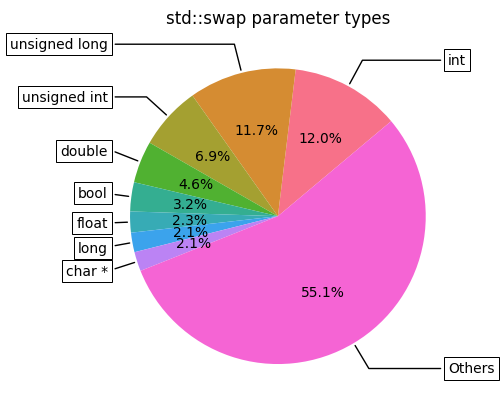

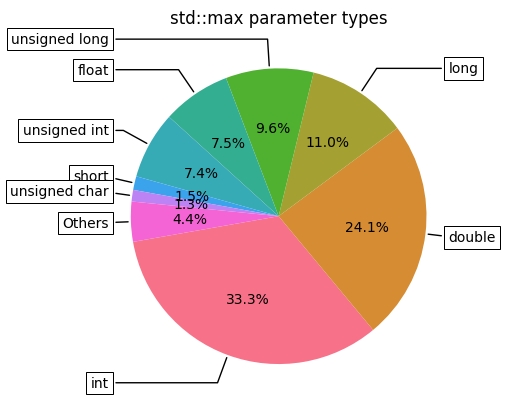

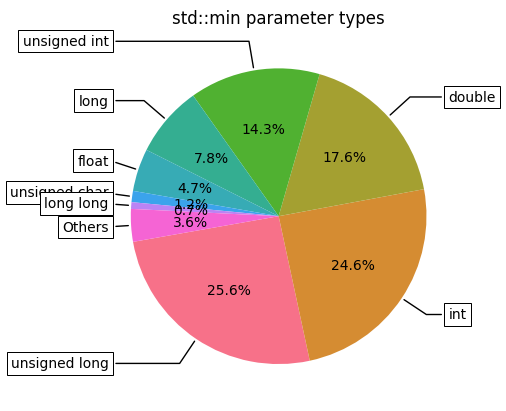

In [149]:
TOP_ALGOS = ["std::move", "std::max", "std::min", "std::fill_n", "std::swap", "std::sort", "std::find", "std::copy", "std::find_if", "std::copy_n"]
TOP_ALGOS = ["std::swap", "std::max", "std::min"]
START_ANGLES = [40, 190, 190]
LENGTHS = [8, 8, 8]

def autopct_format(pct):
    return ('%1.1f%%' % pct) if pct > 0 else ''

for i, algo in enumerate(TOP_ALGOS):
    # read file to get usage for each type
    with open(f"{DATA_ANALYSIS_FOLDER}/data/algo_parameter_type/{algo}.txt", "r") as fin:
        data = fin.readlines()[2:]
    # pie plot for the top types
    data = [(x.strip().split(" ")[0], ' '.join(x.strip().split(" ")[1:])) for x in data]
    data = [(x[0], x[1].strip()) for x in data]
    data = [(int(x[0]), x[1][2:-2]) for x in data]
    data = sorted(data, key = lambda x: x[0], reverse = True)

    sizes = [x[0] for x in data][:LENGTHS[i]] + [sum([x[0] for x in data[LENGTHS[i]:]])]
    labels =[x[1] for x in data][:LENGTHS[i]] + ['Others']
    colors = sns.color_palette('husl', n_colors = len(sizes))

    wedges, texts, _ = plt.pie(sizes, labels = None, colors = colors, autopct=autopct_format, startangle=START_ANGLES[i])
    # plt.legend(loc = 'center left', labels = labels, bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
    plt.subplots_adjust(right=0.75)
    plt.title(f'{algo} parameter types')
    
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
            bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        plt.annotate(labels[i], xy=(x, y), xytext=(1.15*np.sign(x), 1.2*y),
                    horizontalalignment=horizontalalignment, **kw)
    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/{algo} parameter types.pdf", bbox_inches='tight')
    plt.show()


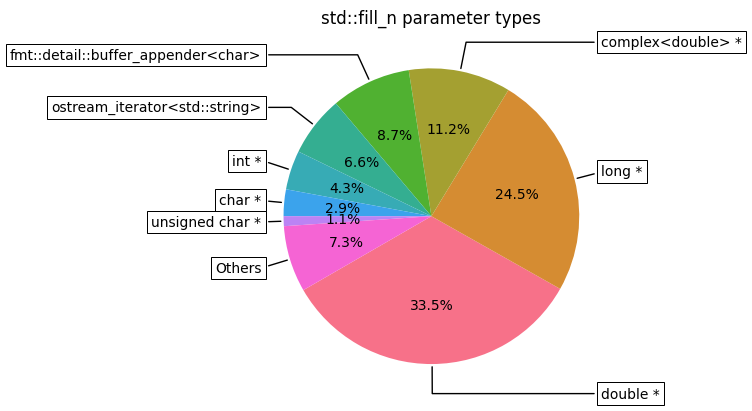

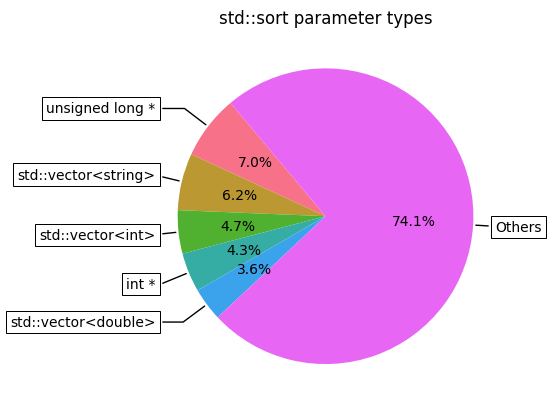

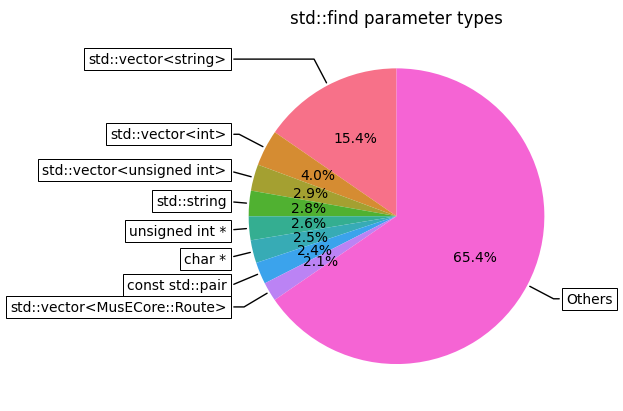

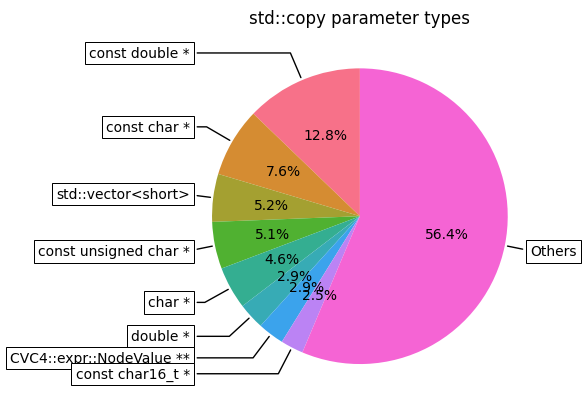

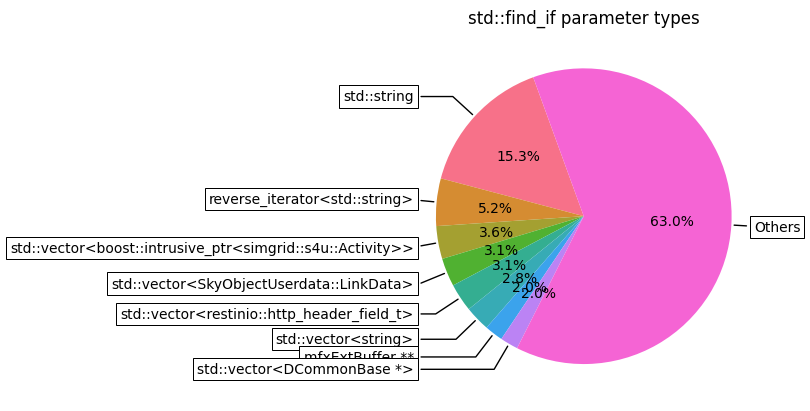

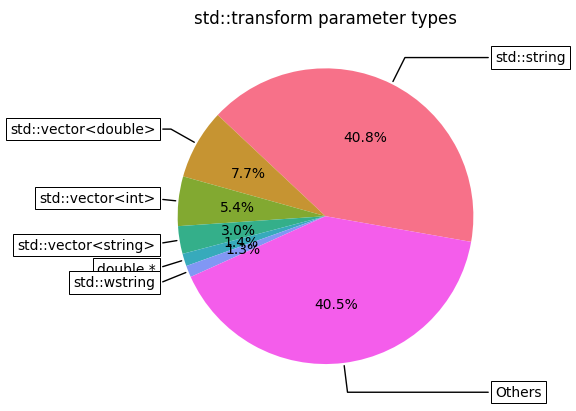

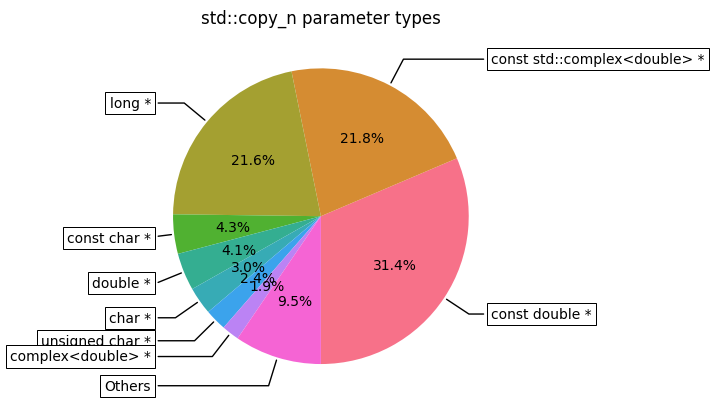

In [150]:
TOP_ALGOS = ["std::move", "std::max", "std::min", "std::fill_n", "std::swap", "std::sort", "std::find", "std::copy", "std::find_if", "std::copy_n"]
TOP_ALGOS = ["std::fill_n", "std::sort", "std::find", "std::copy", "std::find_if", "std::transform", "std::copy_n"]
START_ANGLES = [210, 130, 90, 90, 110, -10, -90]
LENGTHS = [8, 5, 8, 8, 8, 6, 8]

def autopct_format(pct):
    return ('%1.1f%%' % pct) if pct > 0 else ''

for i, algo in enumerate(TOP_ALGOS):
    # read file to get usage for each type
    with open(f"{DATA_ANALYSIS_FOLDER}/data/algo_parameter_type/{algo}.txt", "r") as fin:
        data = fin.readlines()[2:]
    # pie plot for the top types
    data = [(x.strip().split(" ")[0], ' '.join(x.strip().split(" ")[1:])) for x in data]
    data = [(x[0], x[1].strip()) for x in data]
    data = [(int(x[0]), json.loads(x[1])[0]) for x in data]

    data_dict = defaultdict(int)
    for k, v in data:
        data_dict[v] += k
    data = [(v, k) for k, v in data_dict.items()]

    data = [(int(x[0]), x[1]) for x in data]
    data = sorted(data, key = lambda x: x[0], reverse = True)

    sizes = [x[0] for x in data][:LENGTHS[i]] + [sum([x[0] for x in data[LENGTHS[i]:]])]
    labels =[x[1] for x in data][:LENGTHS[i]] + ['Others']
    labels = ["std::vector<nlohmann::json>" if "nlohmann" in x else x for x in labels]
    
    for idx, label in enumerate(labels):
        if label.startswith("Iterator on "):
            label = "std::" + label[12:]
            labels[idx] = label
        if "reverse_iterator" in label:
            label = "reverse_iterator<std::string>"
            labels[idx] = label
        if "ostream_iterator" in label:
            label = "ostream_iterator<std::string>"
            labels[idx] = label
        if "const std::pair" in label:
            label = "const std::pair"
            labels[idx] = label


    colors = sns.color_palette('husl', n_colors = len(sizes))

    wedges, texts, _ = plt.pie(sizes, labels = None, colors = colors, autopct=autopct_format, startangle=START_ANGLES[i])
    # plt.legend(loc = 'center left', labels = labels, bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
    plt.subplots_adjust(right=0.75)
    plt.title(f'{algo} parameter types')
    
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
            bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        plt.annotate(labels[i], xy=(x, y), xytext=(1.15*np.sign(x), 1.2*y),
                    horizontalalignment=horizontalalignment, **kw)
    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/{algo} parameter types.pdf", bbox_inches='tight')
    plt.show()


In [188]:
def process_mutex_types():
    mutex_types = {
        "std::mutex": defaultdict(int),
        "std::recursive_mutex": defaultdict(int),
        "std::timed_mutex": defaultdict(int),
        "std::recursive_timed_mutex": defaultdict(int),
    }

    global_location_sets = {
        "std::mutex": set(),
        "std::recursive_mutex": set(),
        "std::timed_mutex": set(),
        "std::recursive_timed_mutex": set(),
    }

    mutex_to_distinct_project = {
        "std::mutex": set(),
        "std::recursive_mutex": set(),
        "std::timed_mutex": set(),
        "std::recursive_timed_mutex": set(),
    }

    files = list(glob.iglob(join(FEATURES_FOLDER, '**/*.ast.json'), recursive=True))
    print(f"Processing {len(files)} files")

    for file_count, file in enumerate(files):
        if file_count % 1_000_000 == 0:
            print(f"Processed {file_count} files")

        project_name = file.split('/')[6]

        with open(file, "r") as fin:
            content = json.load(fin)
        
        if content.get("cta", None) is None:
            continue

        if content["cta"].get("mutex usage", None) is None:
            continue

        for usage_type, usage_type_dict in content["cta"]["mutex usage"].items():
            for mutex_type, apps in usage_type_dict.items():

                if len(apps) > 0 and project_name not in mutex_to_distinct_project[mutex_type]:
                    mutex_to_distinct_project[mutex_type].add(project_name)
                    mutex_types[mutex_type]["distinct count"] += 1

                for appearance in apps:
                    as_str = json.dumps(appearance)
                    if as_str in global_location_sets[mutex_type]:
                        continue
                    global_location_sets[mutex_type].add(as_str)
                    mutex_types[mutex_type][usage_type] += 1
        
    with open(f"{DATA_ANALYSIS_FOLDER}/data/mutex_types.json", "w") as fout:
        json.dump(mutex_types, fout, indent=4)

In [189]:
# process_mutex_types()

Processing 371259 files
Processed 0 files


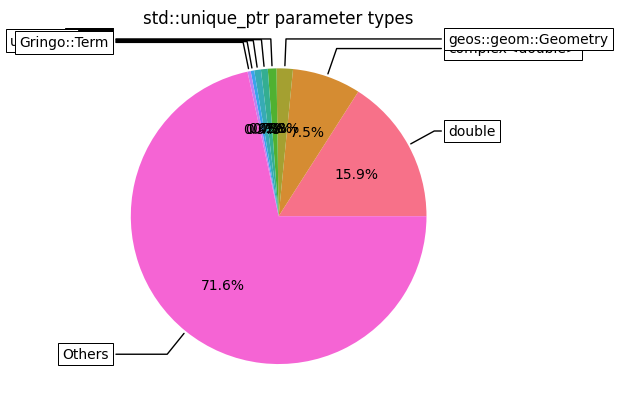

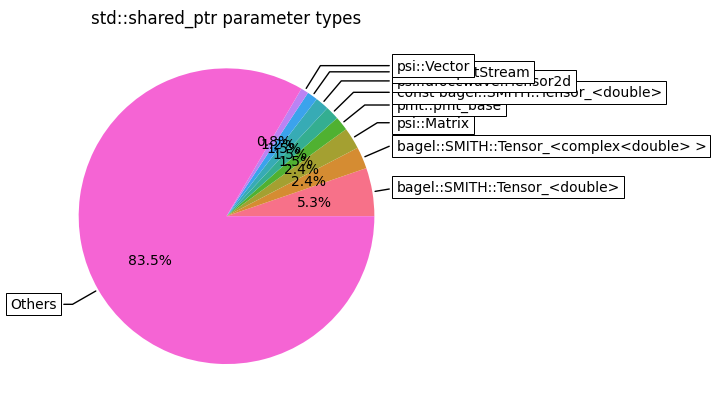

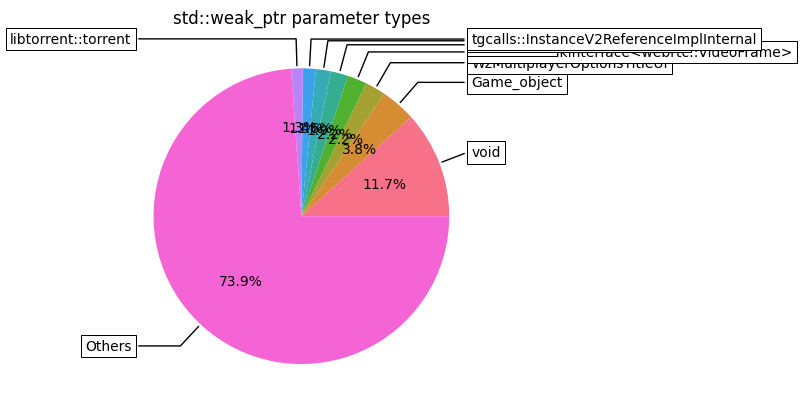

In [191]:
# TOP_ALGOS = ["std::move", "std::max", "std::min", "std::fill_n", "std::swap", "std::sort", "std::find", "std::copy", "std::find_if", "std::copy_n"]
# TOP_ALGOS = ["std::fill_n", "std::sort", "std::find", "std::copy", "std::find_if", "std::transform", "std::copy_n"]
SMART_POINTERS = ["std::unique_ptr", "std::shared_ptr", "std::weak_ptr"]
START_ANGLES = [0, 0, 0]
LENGTHS = [8, 8, 8]

def autopct_format(pct):
    return ('%1.1f%%' % pct) if pct > 0 else ''

for i, smart_ptr_type in enumerate(SMART_POINTERS):
    # read file to get usage for each type
    with open(f"{DATA_ANALYSIS_FOLDER}/data/smart_ptr_parameter_type/{smart_ptr_type}.txt", "r") as fin:
        data = fin.readlines()[2:]
    # pie plot for the top types
    data = [(x.strip().split(" ")[0], ' '.join(x.strip().split(" ")[1:])) for x in data]
    data = [(x[0], x[1].strip()) for x in data]
    data = [(int(x[0]), json.loads(x[1])[0]) for x in data]

    data_dict = defaultdict(int)
    for k, v in data:
        data_dict[v] += k
    data = [(v, k) for k, v in data_dict.items()]

    data = [(int(x[0]), x[1]) for x in data]
    data = sorted(data, key = lambda x: x[0], reverse = True)

    sizes = [x[0] for x in data][:LENGTHS[i]] + [sum([x[0] for x in data[LENGTHS[i]:]])]
    labels =[x[1] for x in data][:LENGTHS[i]] + ['Others']
    labels = ["std::vector<nlohmann::json>" if "nlohmann" in x else x for x in labels]
    
    for idx, label in enumerate(labels):
        if label.startswith("Iterator on "):
            label = "std::" + label[12:]
            labels[idx] = label
        if "reverse_iterator" in label:
            label = "reverse_iterator<std::string>"
            labels[idx] = label
        if "ostream_iterator" in label:
            label = "ostream_iterator<std::string>"
            labels[idx] = label
        if "const std::pair" in label:
            label = "const std::pair"
            labels[idx] = label


    colors = sns.color_palette('husl', n_colors = len(sizes))

    wedges, texts, _ = plt.pie(sizes, labels = None, colors = colors, autopct=autopct_format, startangle=START_ANGLES[i])
    # plt.legend(loc = 'center left', labels = labels, bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
    plt.subplots_adjust(right=0.75)
    plt.title(f'{smart_ptr_type} parameter types')
    
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
            bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        plt.annotate(labels[i], xy=(x, y), xytext=(1.15*np.sign(x), 1.2*y),
                    horizontalalignment=horizontalalignment, **kw)
    plt.savefig(f"{DATA_ANALYSIS_FOLDER}/plots/{smart_ptr_type} parameter types.pdf", bbox_inches='tight')
    plt.show()


In [196]:
# sort projects by use of std::fill_n
def sort_projects_by_fill_n():
    projects_and_count = []
    for pname, p in stats.items():
        if p.get("overall_features", None) is not None and p['overall_features'].get(f'algorithm type prevalence', None) is not None and \
            p['overall_features']['algorithm type prevalence'].get('std::fill_n', 0) > 0:
            projects_and_count.append((pname, p['overall_features']['algorithm type prevalence']['std::fill_n']))
        else:
            projects_and_count.append((pname, 0))
    
    projects_and_count = sorted(projects_and_count, key = lambda x: x[1], reverse = True)
    print(projects_and_count[:5])

sort_projects_by_fill_n()

[('bagel', 7867), ('octave', 339), ('dolfin', 222), ('seqan2', 74), ('onevpl-intel-gpu', 33)]


In [199]:
stats['bagel']['individual_features'].keys()

dict_keys(['/home/fba_code/analyze/src/integral/_hrr_a0_73.ast.json', '/home/fba_code/analyze/src/integral/_carsph_74.ast.json', '/home/fba_code/analyze/src/integral/_hrr_80_71.ast.json', '/home/fba_code/analyze/src/integral/_carsph_75.ast.json', '/home/fba_code/analyze/src/integral/_carsph_72.ast.json', '/home/fba_code/analyze/src/integral/_carsph_73.ast.json', '/home/fba_code/analyze/src/integral/glibint.ast.json', '/home/fba_code/analyze/src/integral/_hrr_c0_75.ast.json', '/home/fba_code/analyze/src/integral/_carsph_77.ast.json', '/home/fba_code/analyze/src/integral/_hrr_e0_77.ast.json', '/home/fba_code/analyze/src/integral/_hrr_d0_76.ast.json', '/home/fba_code/analyze/src/integral/_carsph_71.ast.json', '/home/fba_code/analyze/src/integral/_hrr_90_72.ast.json', '/home/fba_code/analyze/src/integral/libint.ast.json', '/home/fba_code/analyze/src/integral/_carsph_70.ast.json', '/home/fba_code/analyze/src/integral/_carsph_76.ast.json', '/home/fba_code/analyze/src/integral/_hrr_b0_74.ast.